In [1]:
import sys
sys.path.append("../src/")

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.distributions as dist
import umap

from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from probabilistic_flow_boosting.models.nodeflow import NodeFlow, NodeFlowDataModule
from probabilistic_flow_boosting.models.node_gmm import NodeGMM
from probabilistic_flow_boosting.extras.datasets.uci_dataset import UCIDataSet
from probabilistic_flow_boosting.pipelines.modeling.nodes.nodeflow import train_nodeflow

In [2]:
def get_parameters_nodegmm(model, X):
    context = model.tree_model(X)

    outputs = model.gauss_model.forward_layer(context)
    outputs = outputs.reshape(model.gauss_model.n_components, 3)
    
    logits, means, unconstrained_stds = (
        outputs[:, 0],
        outputs[:, 1],
        outputs[:, 2],
    )
    logits = torch.log_softmax(logits, dim=-1)
    stds = F.softplus(unconstrained_stds) + model.gauss_model.epsilon
    logits, means, stds = logits.detach().numpy(), means.detach().numpy(), stds.detach().numpy()

    exp_logits = np.exp(logits)
    weights = exp_logits / np.sum(exp_logits)
    
    return weights, means, stds


def generate_kde_plot_gaussian(model, datamodule, observation, num_samples: int = 1000):
    weights, means, stds = get_parameters_nodegmm(model, observation)
    x = np.linspace(min(means) - 3 * max(stds), max(means) + 3 * max(stds), 1000)
    
    # Calculate the PDF values at each data point by combining Gaussian components
    pdf_values = np.zeros_like(x)
    for i in range(len(means)):
        component_pdf = norm.pdf(x, loc=means[i], scale=stds[i])
        pdf_values += component_pdf * weights[i]
    
    x = datamodule.target_scaler.inverse_transform(x.reshape(-1, 1))  # Rescaling target variable.
    pdf_values *= np.abs(np.prod(datamodule.target_scaler.scale_))  # Rescaling PDF values.
    return x, pdf_values


def generate_samples_nodeflow(model, datamodule, observation, num_samples: int = 1000):
    samples = model._sample(observation, num_samples)

    samples_size = samples.shape
    samples: np.ndarray = samples.detach().cpu().numpy()
    samples: np.ndarray = samples.reshape((samples_size[0] * samples_size[1], samples_size[2]))
    samples: np.ndarray = datamodule.target_scaler.inverse_transform(samples)
    samples: np.ndarray = samples.reshape((samples_size[0], samples_size[1], samples_size[2]))
    samples: np.ndarray = samples.squeeze()
    return samples


In [3]:
uci_datasets = [
    # 'concrete', 
    # 'energy', 
    # 'kin8nm', 
    # 'naval-propulsion-plant', 
    # 'power-plant', 
    'protein-tertiary-structure', 
    'wine-quality-red', 
    # 'yacht'
]

protein-tertiary-structure 0
protein-tertiary-structure 1
protein-tertiary-structure 2
protein-tertiary-structure 3
protein-tertiary-structure 4
protein-tertiary-structure 5
protein-tertiary-structure 6
protein-tertiary-structure 7
protein-tertiary-structure 8
protein-tertiary-structure 9
protein-tertiary-structure 10
protein-tertiary-structure 11
protein-tertiary-structure 12
protein-tertiary-structure 13
protein-tertiary-structure 14
protein-tertiary-structure 15
protein-tertiary-structure 16
protein-tertiary-structure 17
protein-tertiary-structure 18
protein-tertiary-structure 19
wine-quality-red 0


/var/folders/yr/mfhy4qkx1m302d_yxw615jj00000gn/T/ipykernel_20137/1449618999.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


wine-quality-red 1
wine-quality-red 2
wine-quality-red 3
wine-quality-red 4
wine-quality-red 5
wine-quality-red 6
wine-quality-red 7
wine-quality-red 8
wine-quality-red 9
wine-quality-red 10
wine-quality-red 11
wine-quality-red 12
wine-quality-red 13
wine-quality-red 14
wine-quality-red 15
wine-quality-red 16
wine-quality-red 17
wine-quality-red 18
wine-quality-red 19


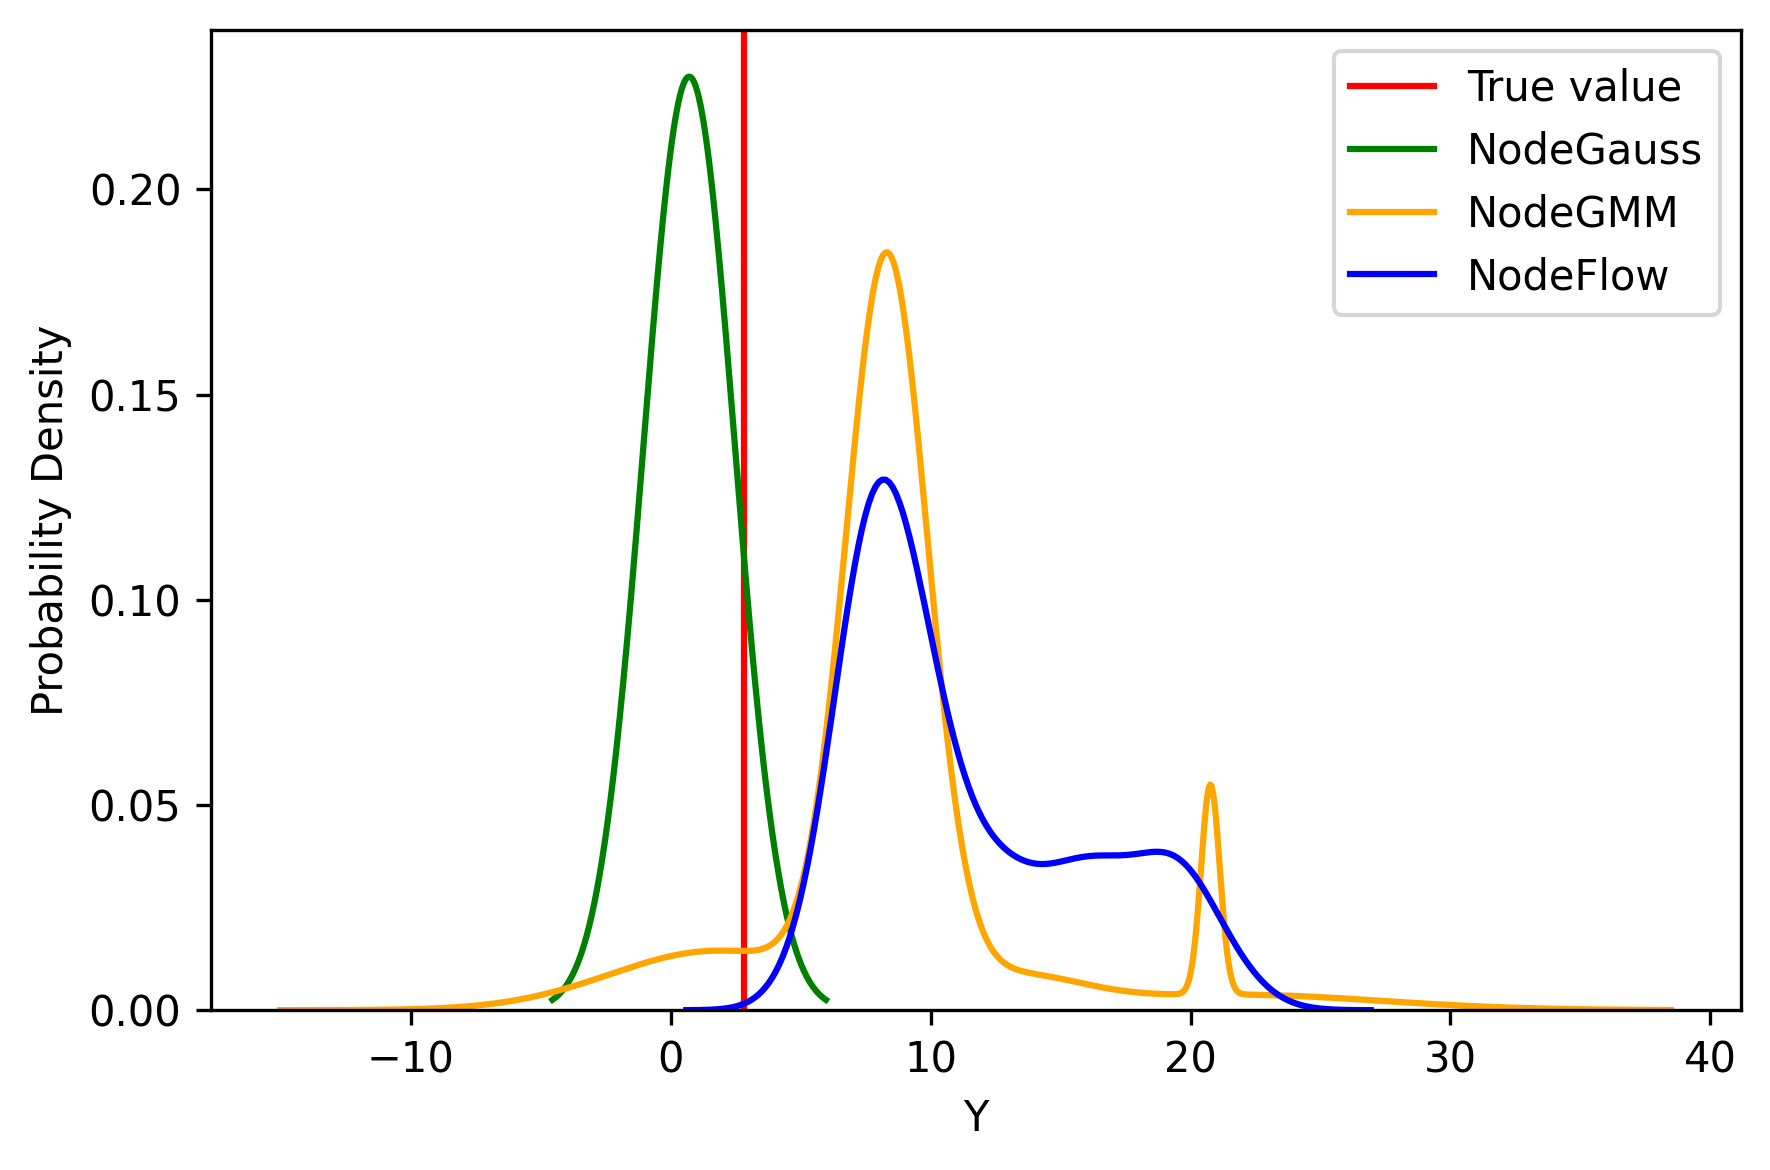

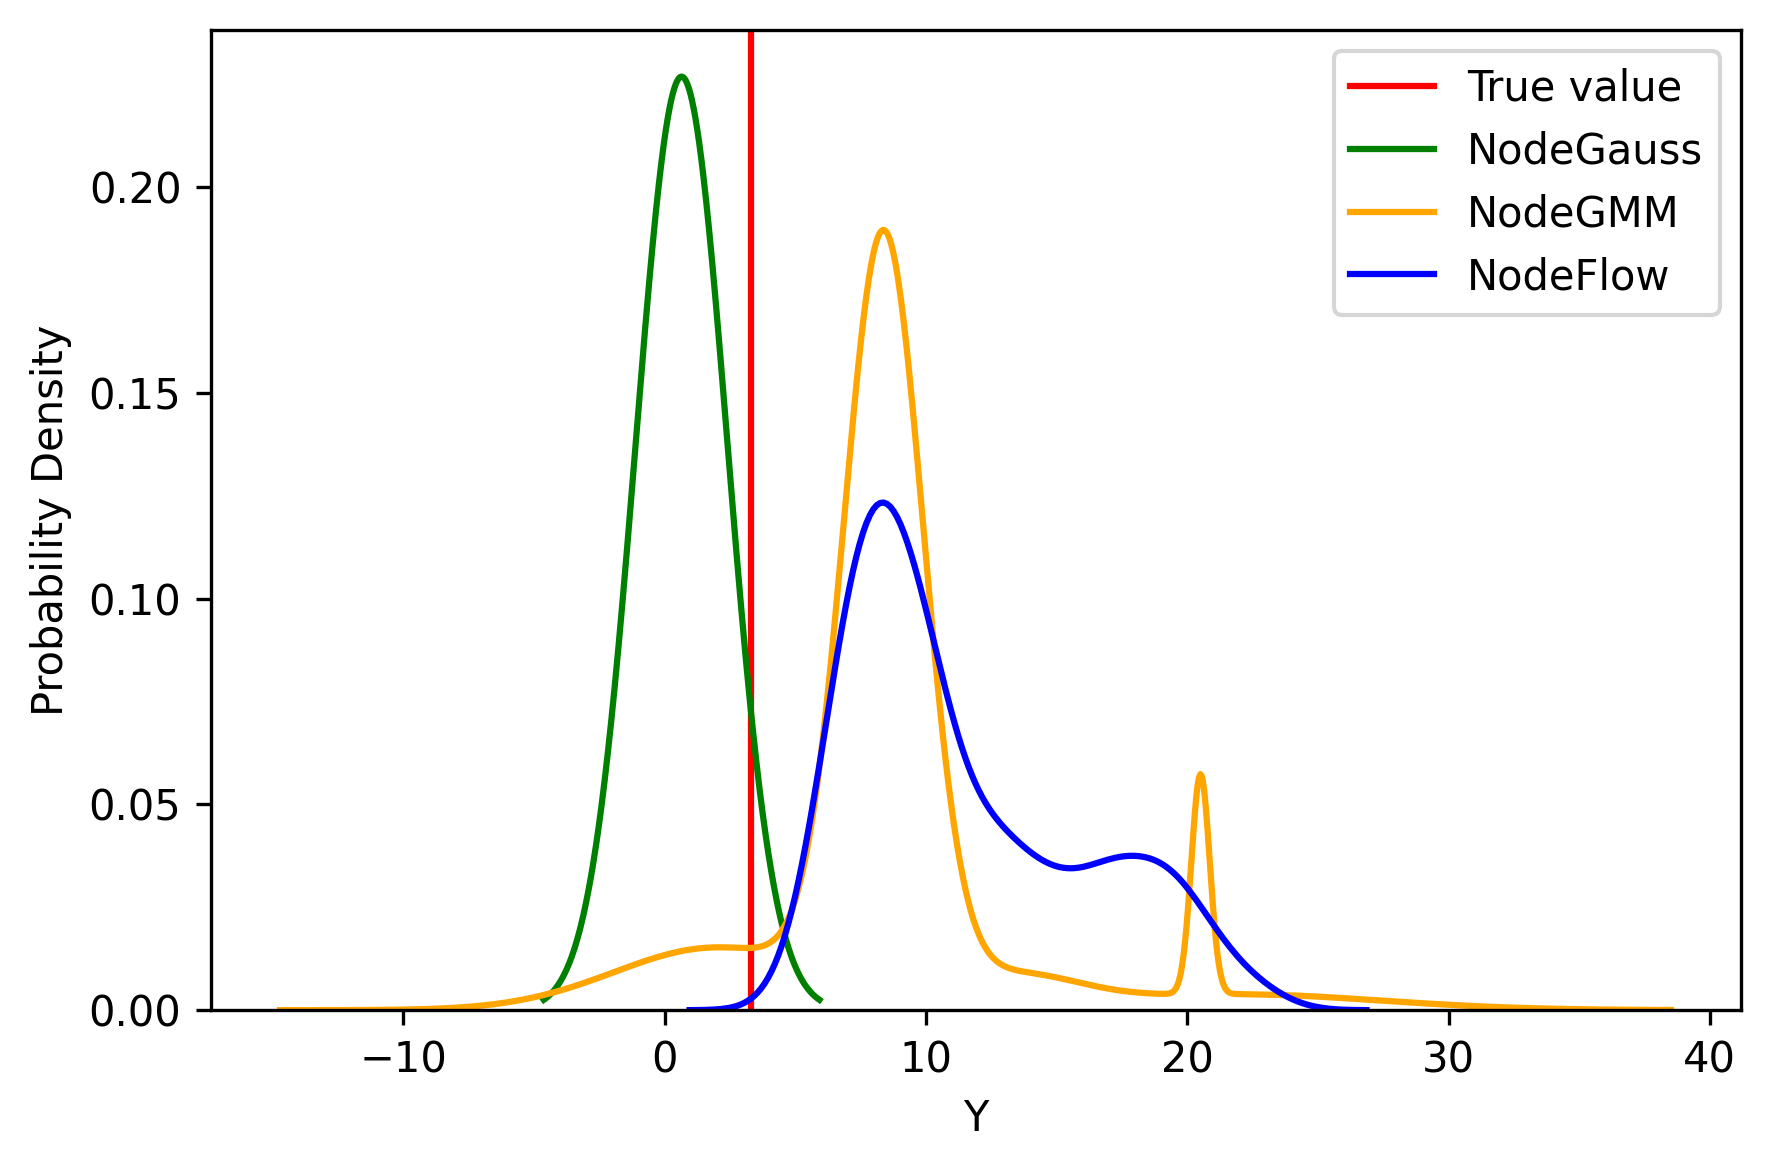

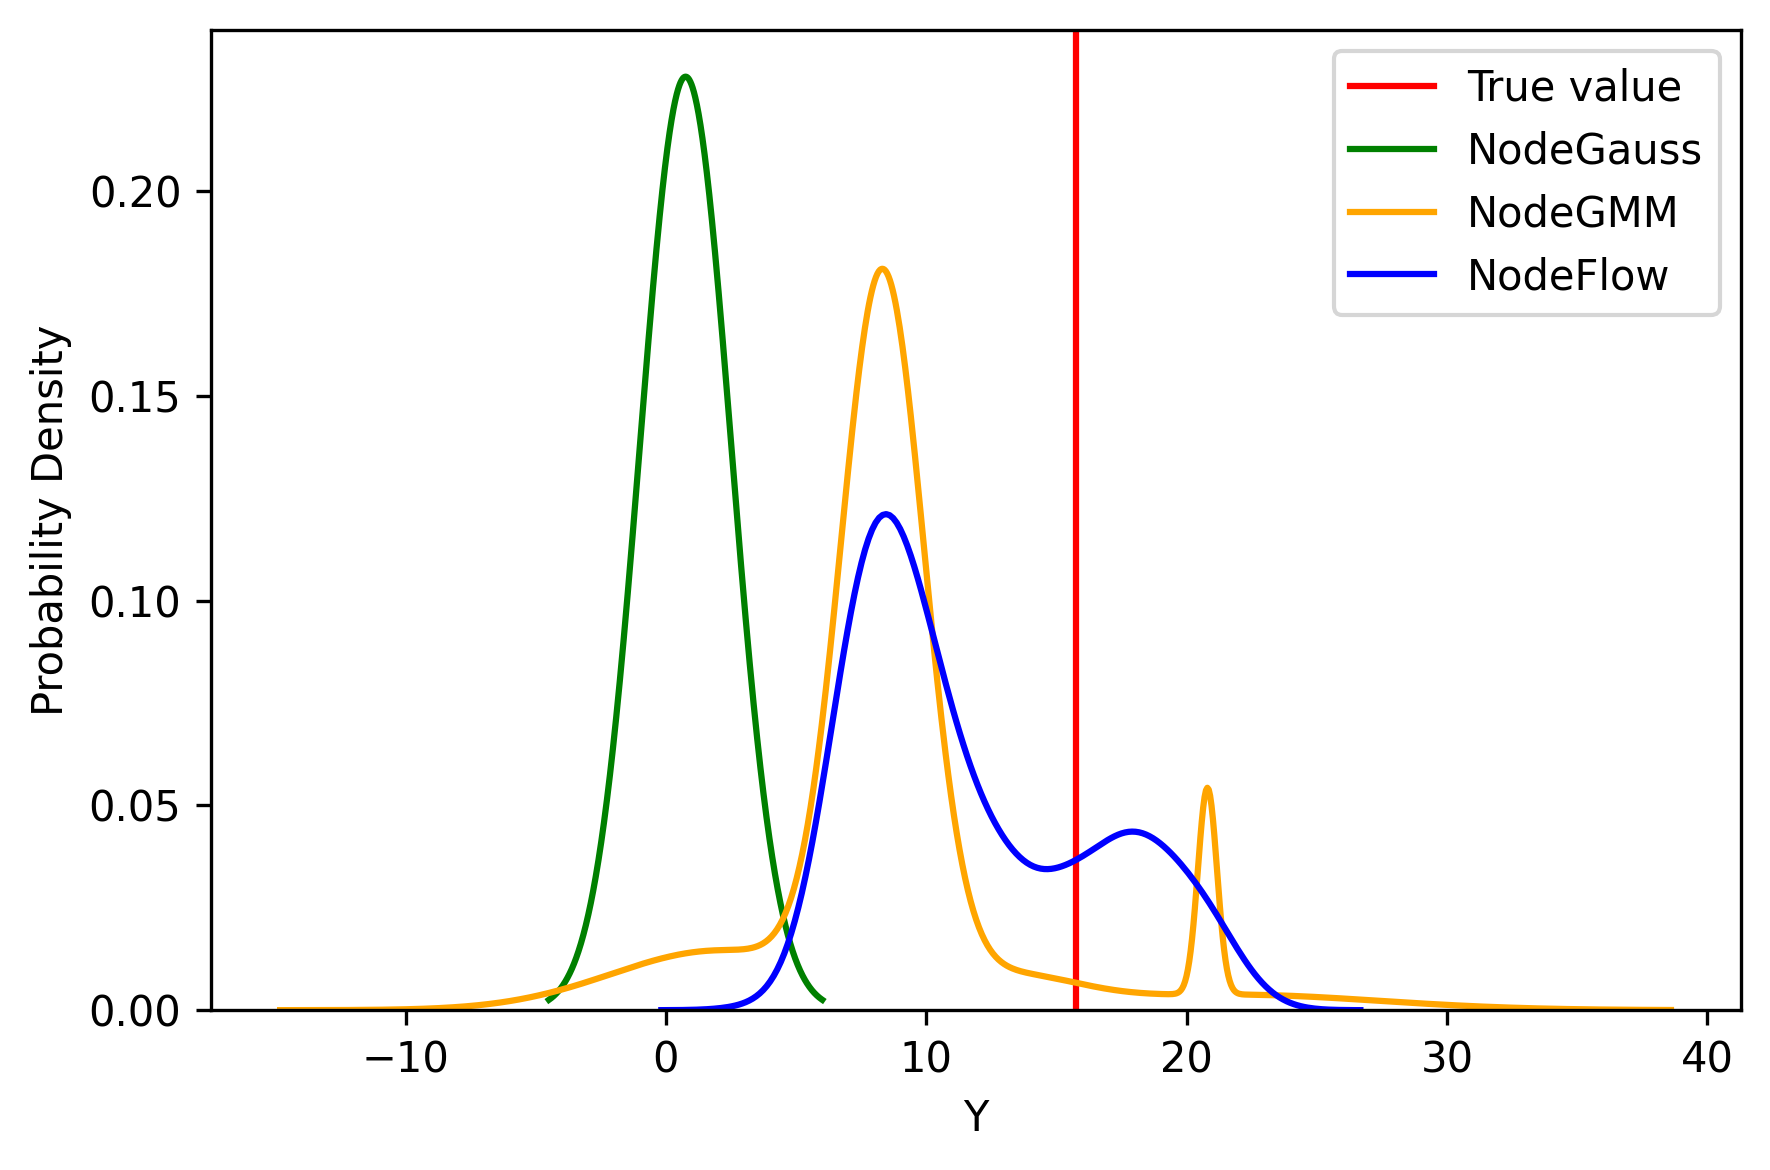

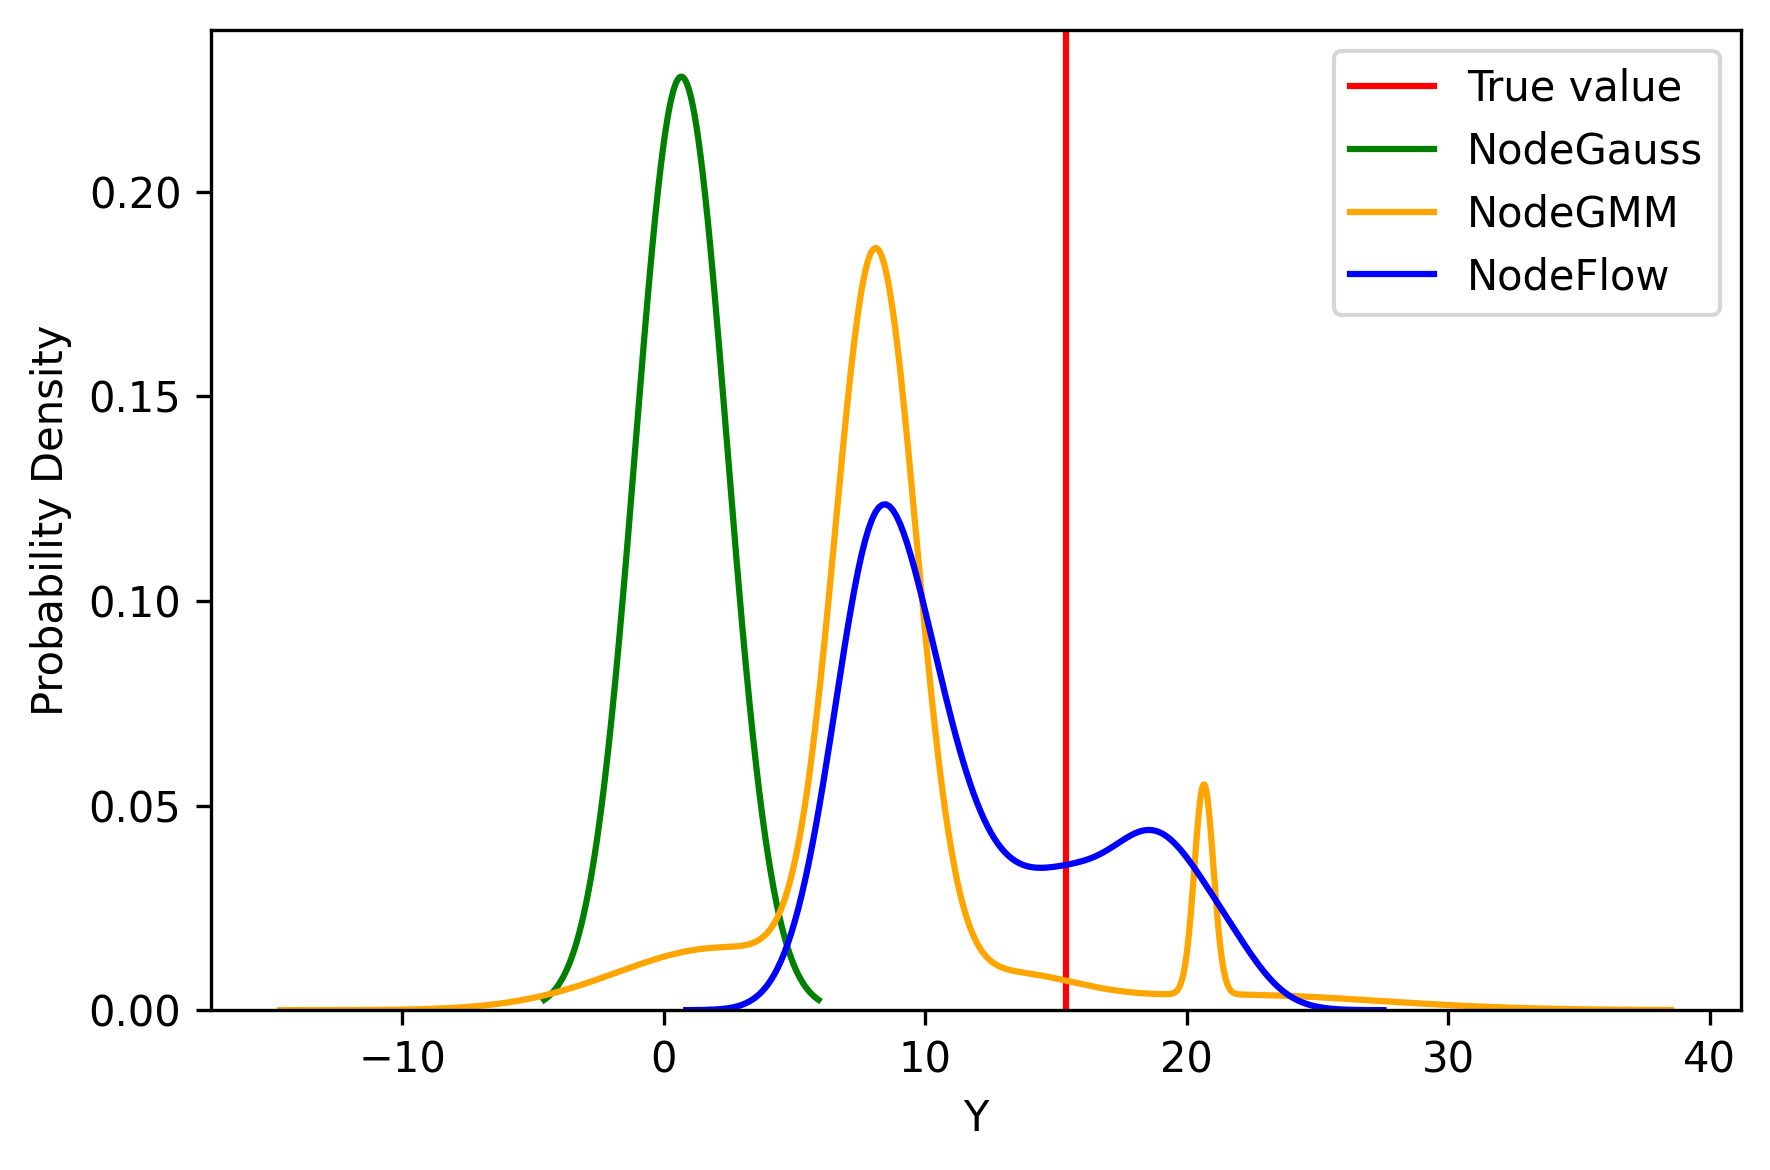

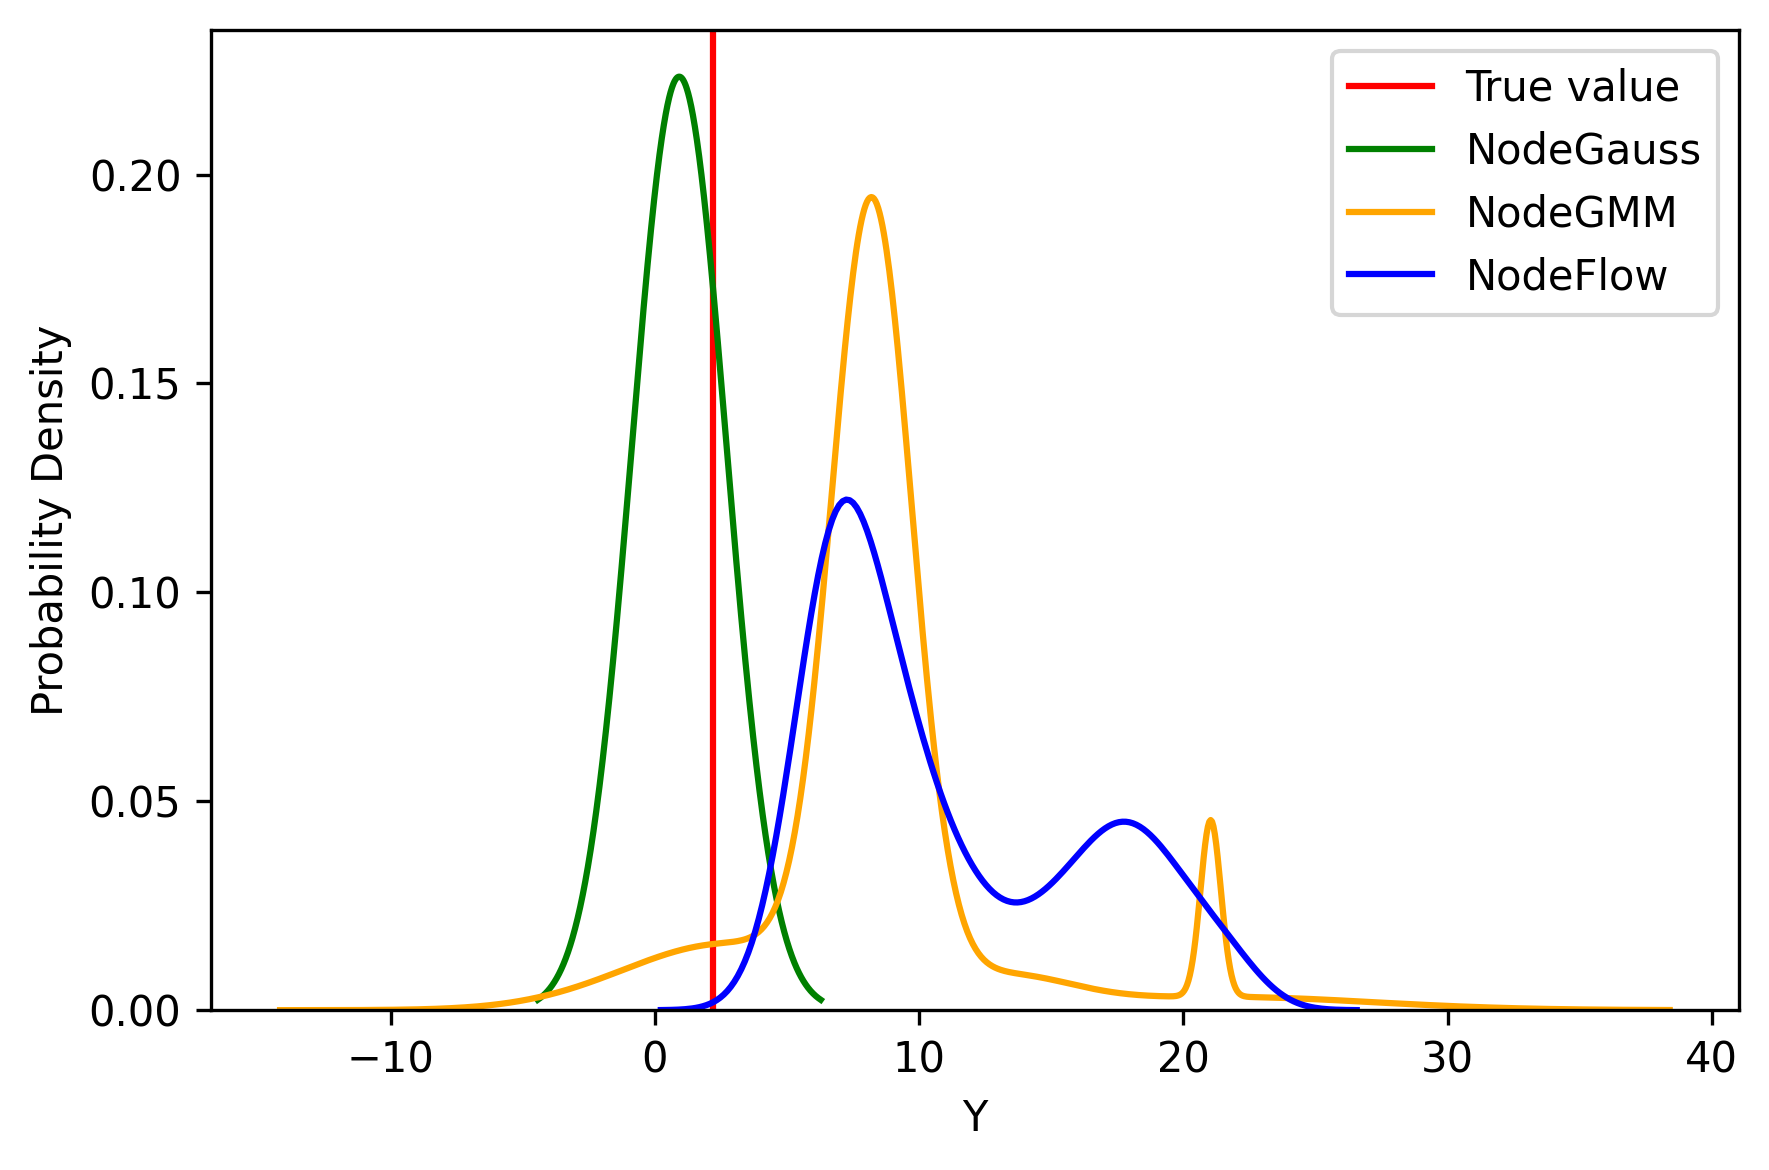

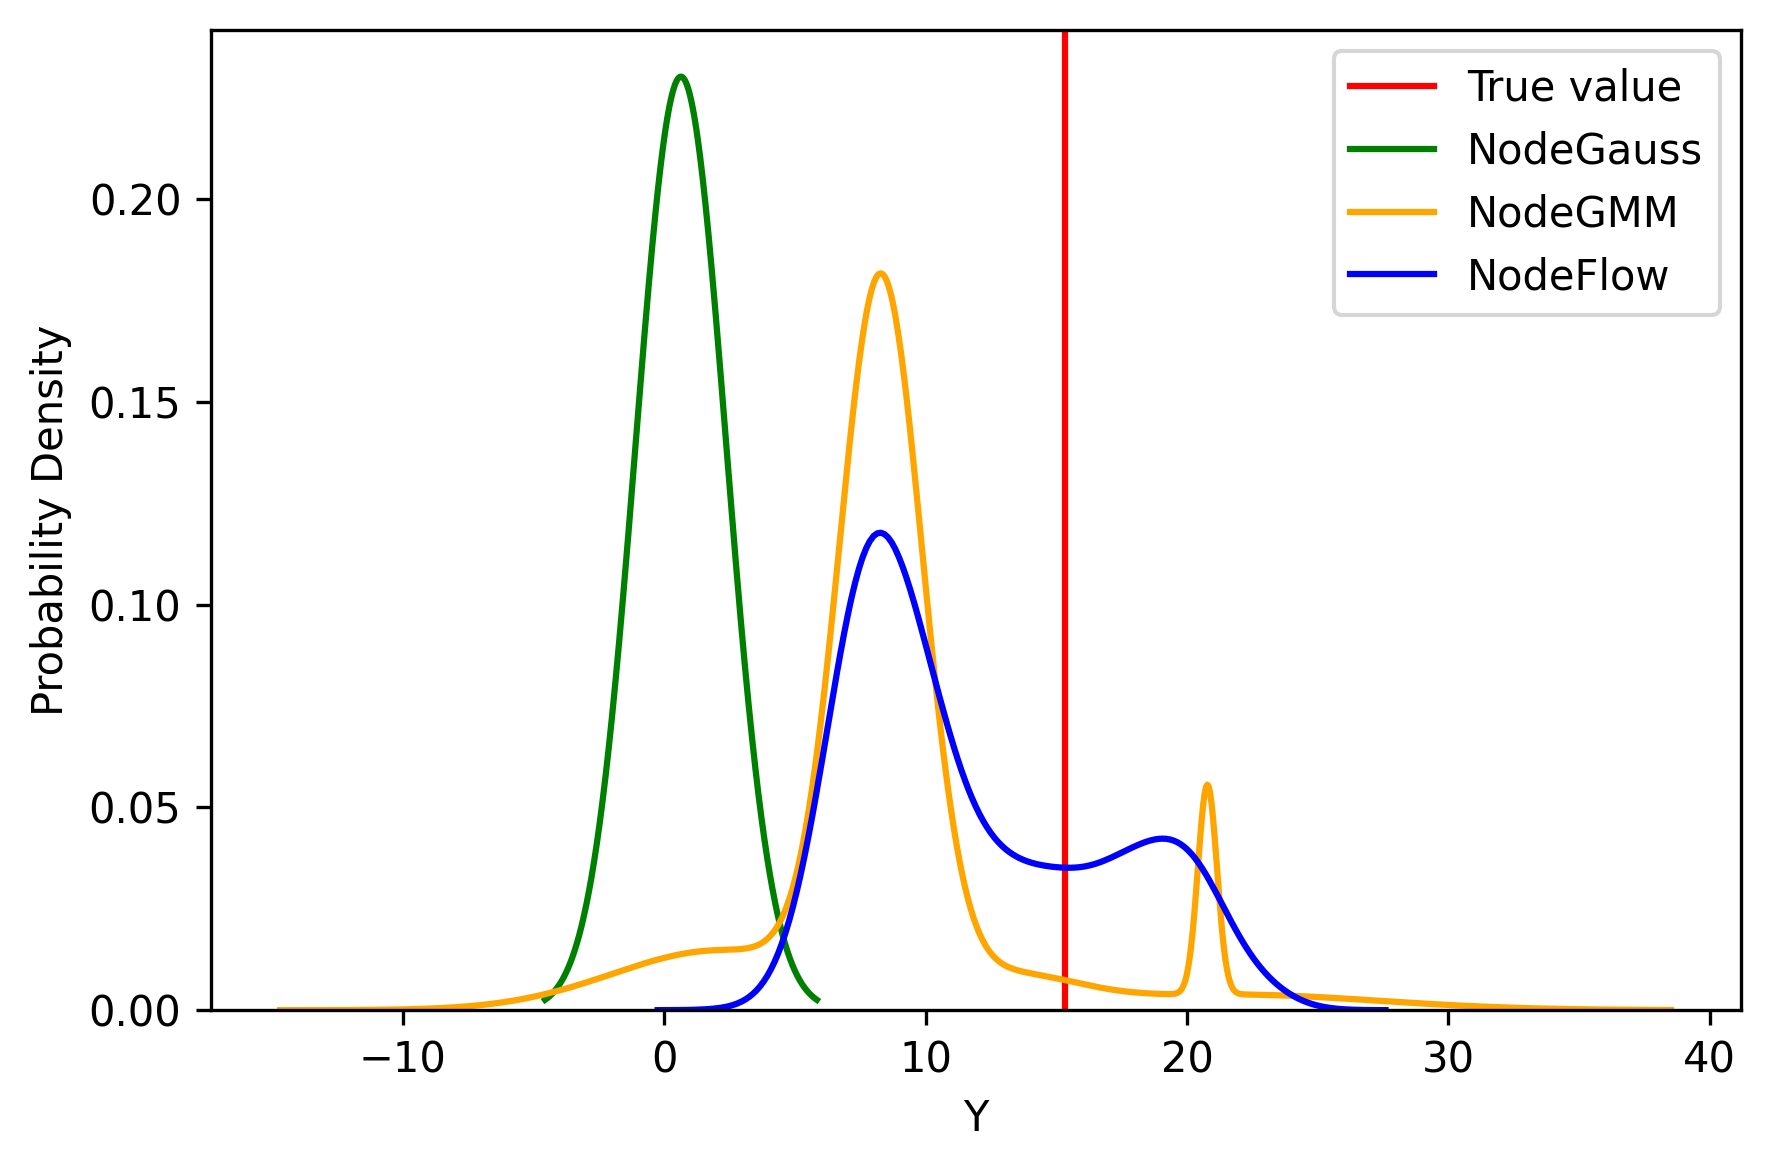

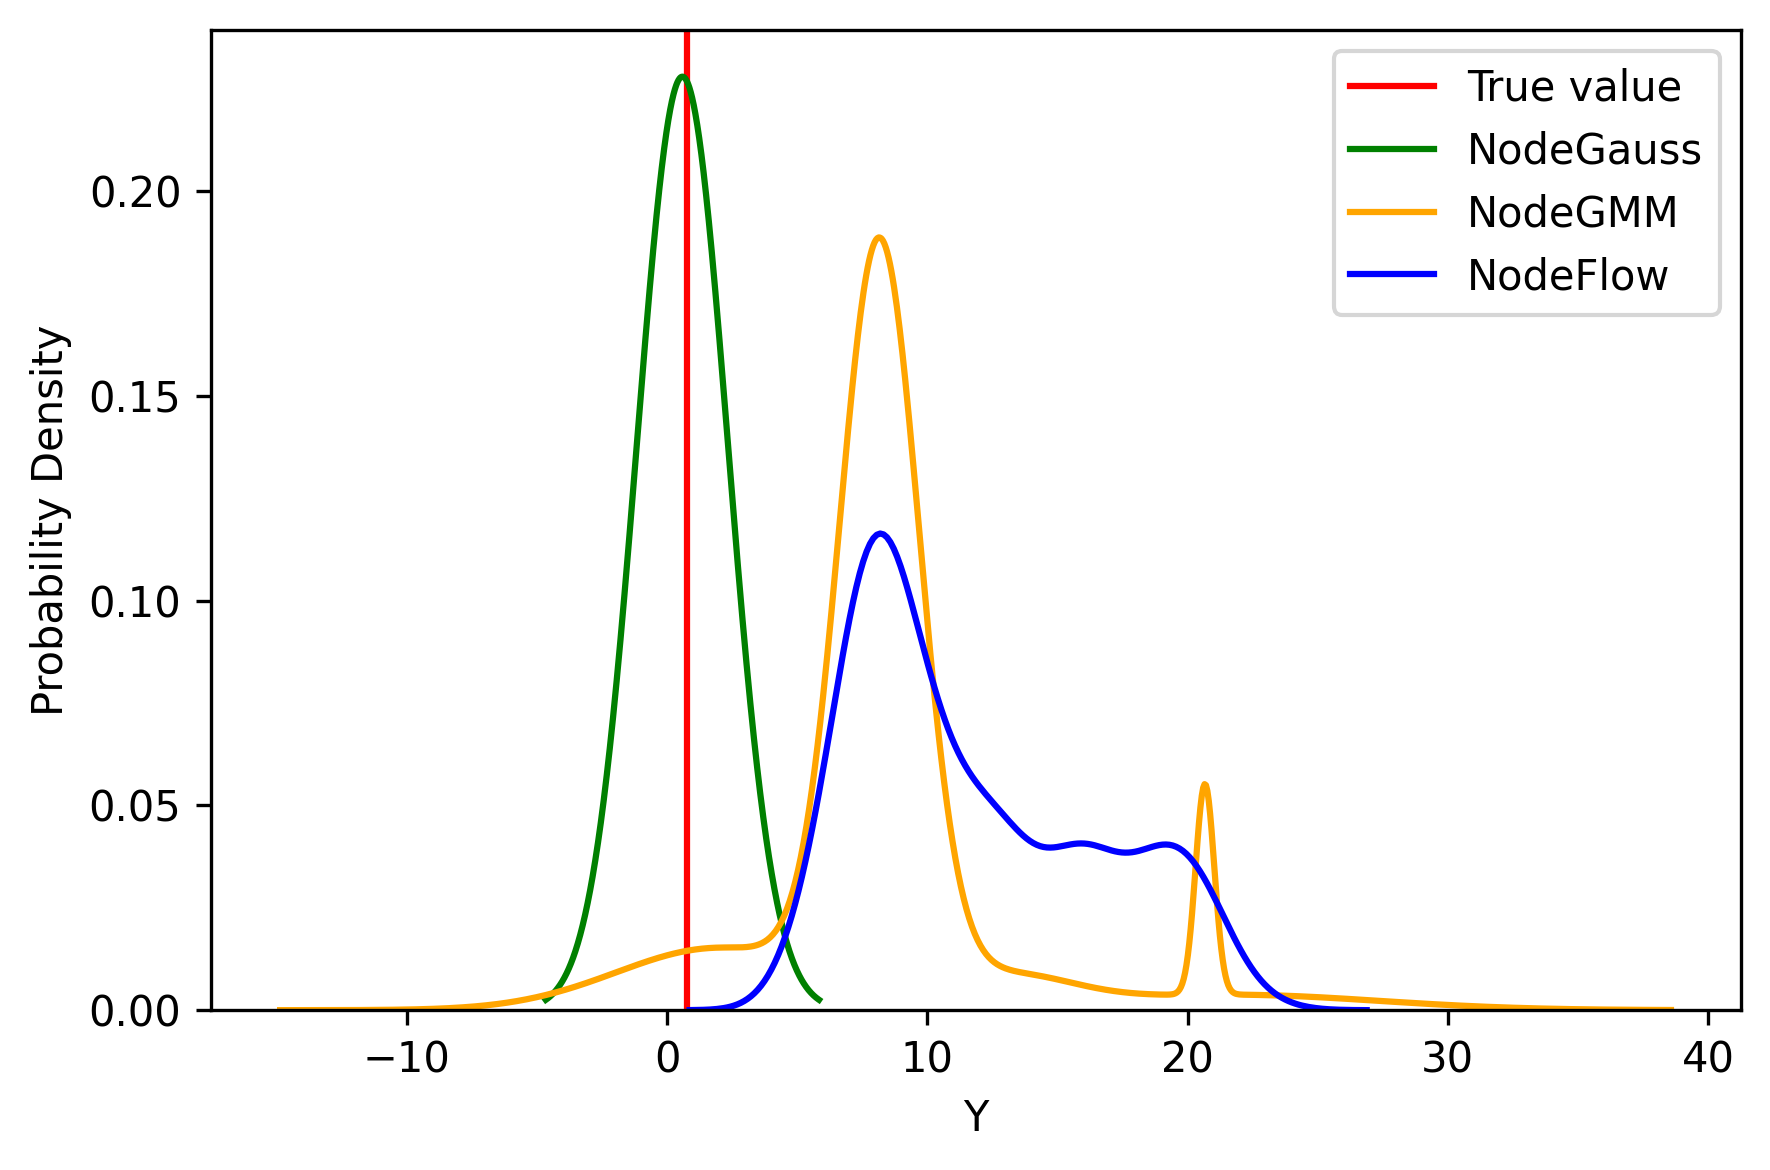

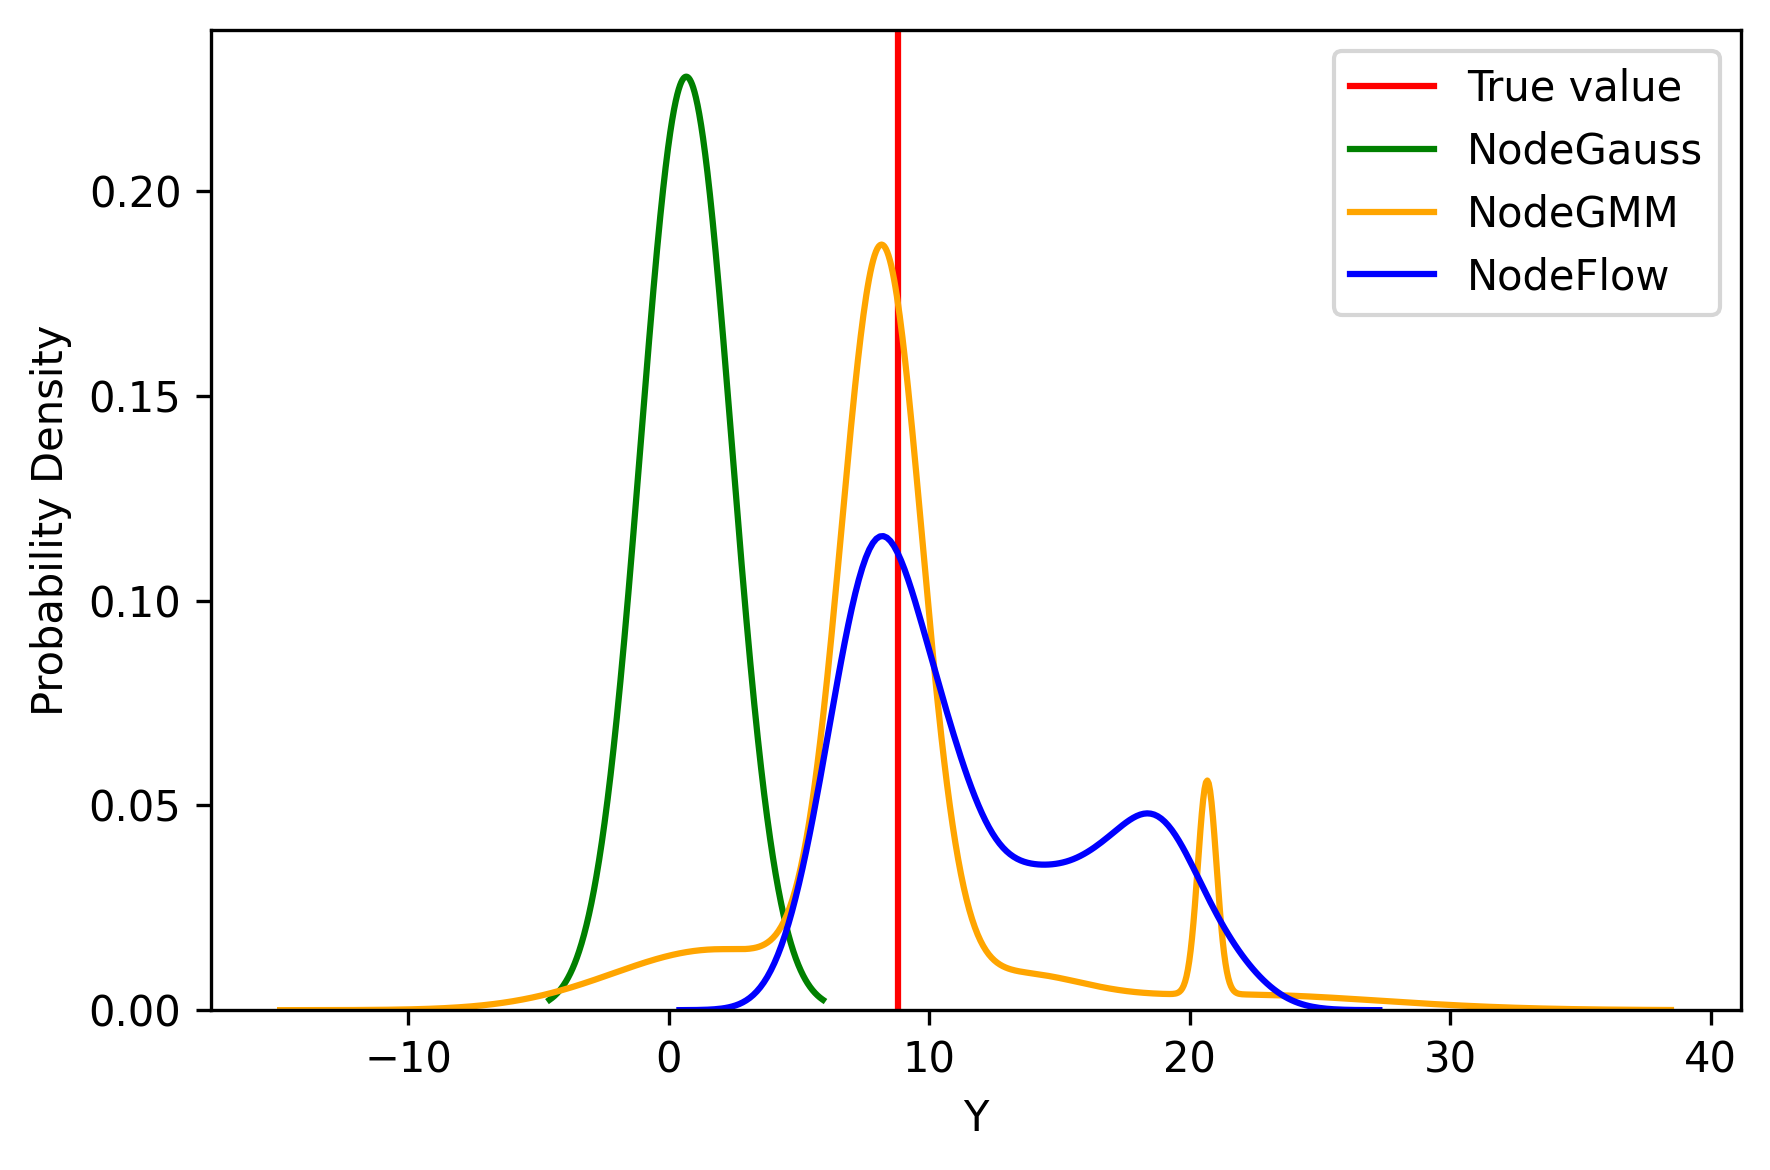

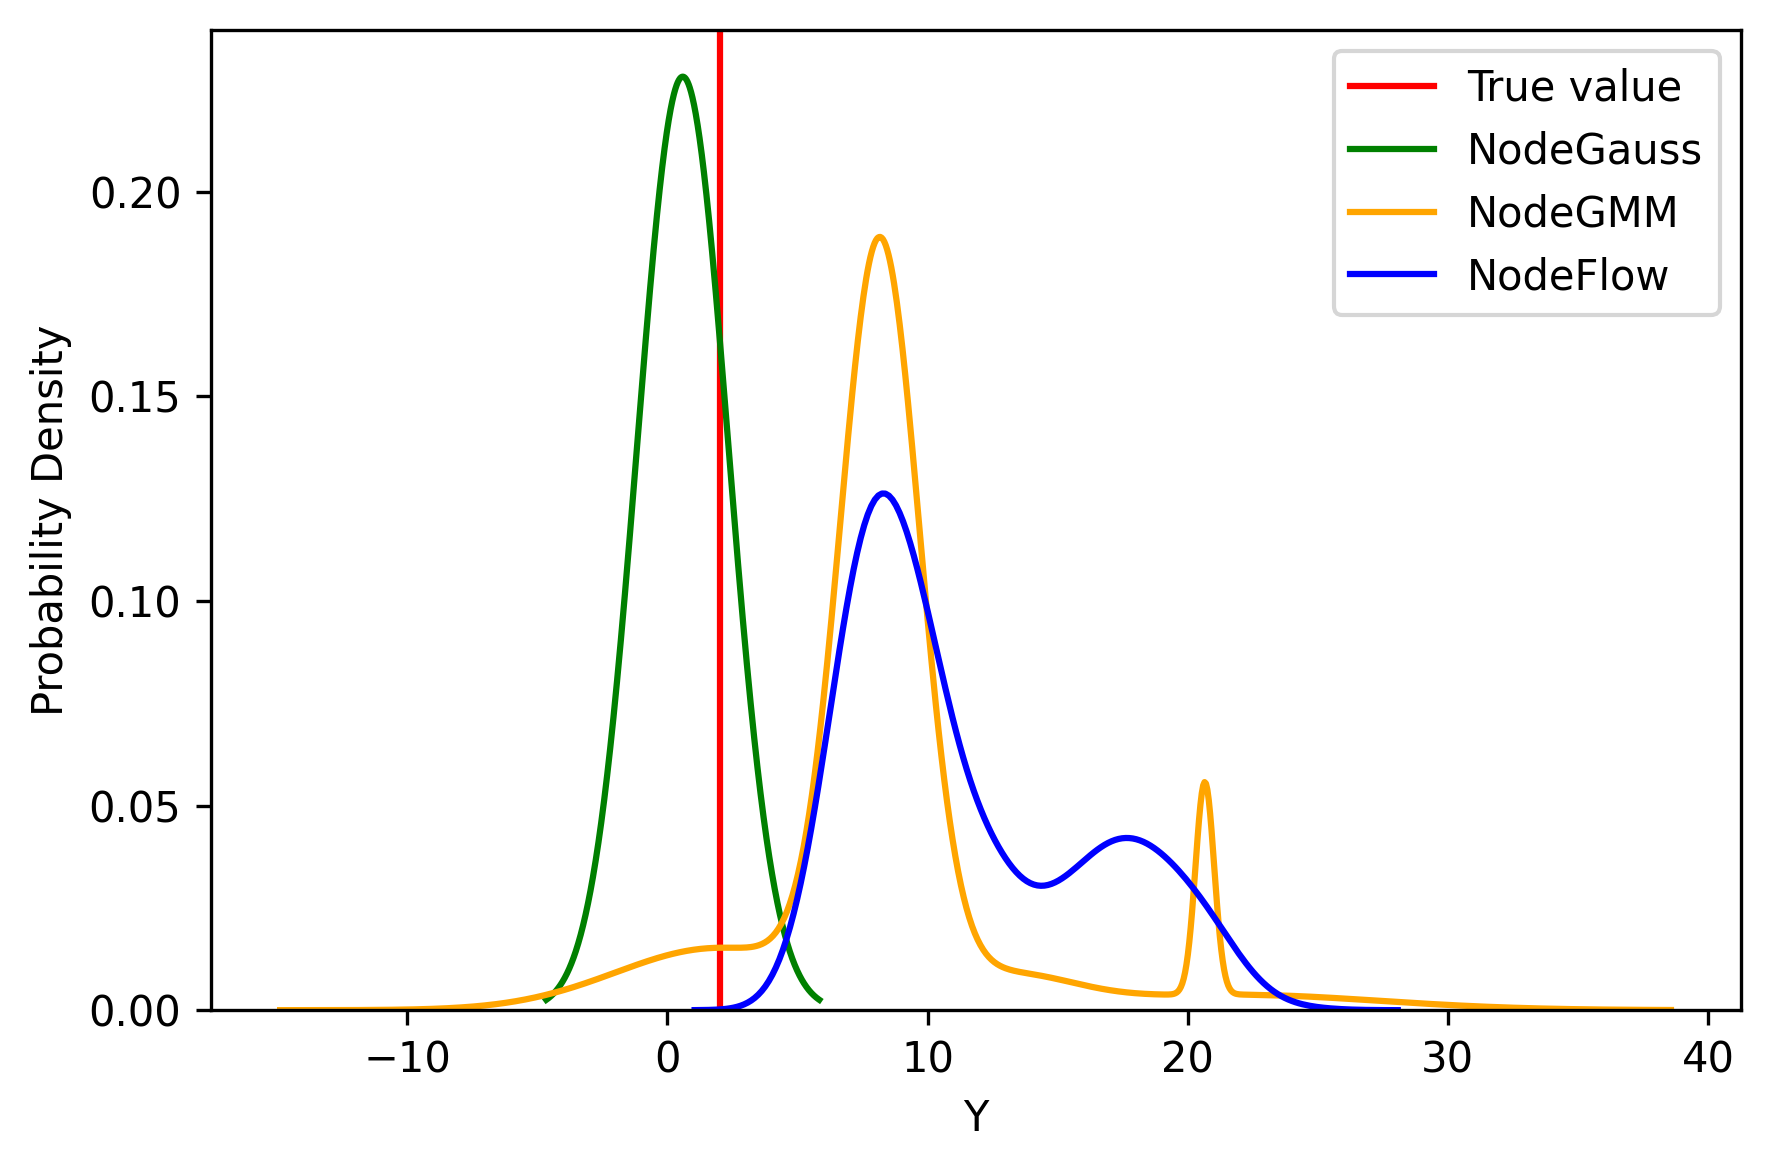

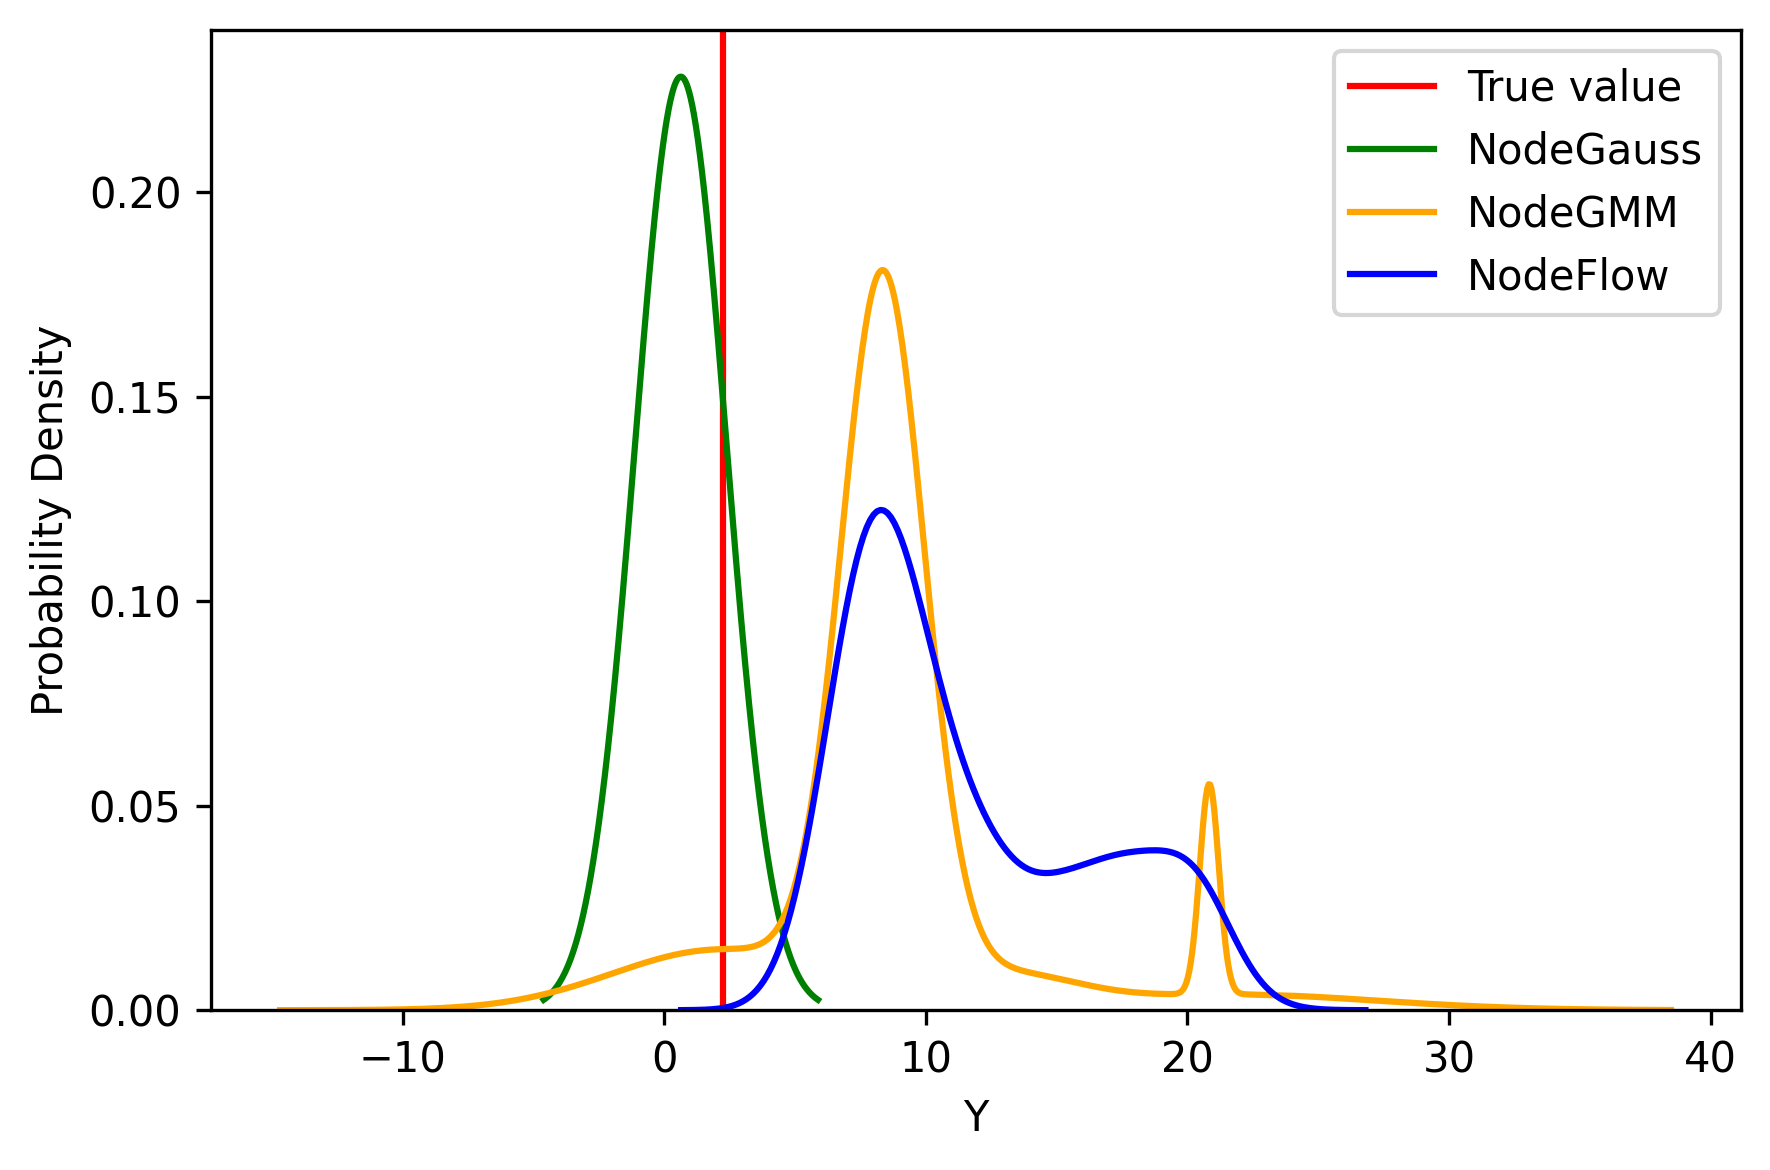

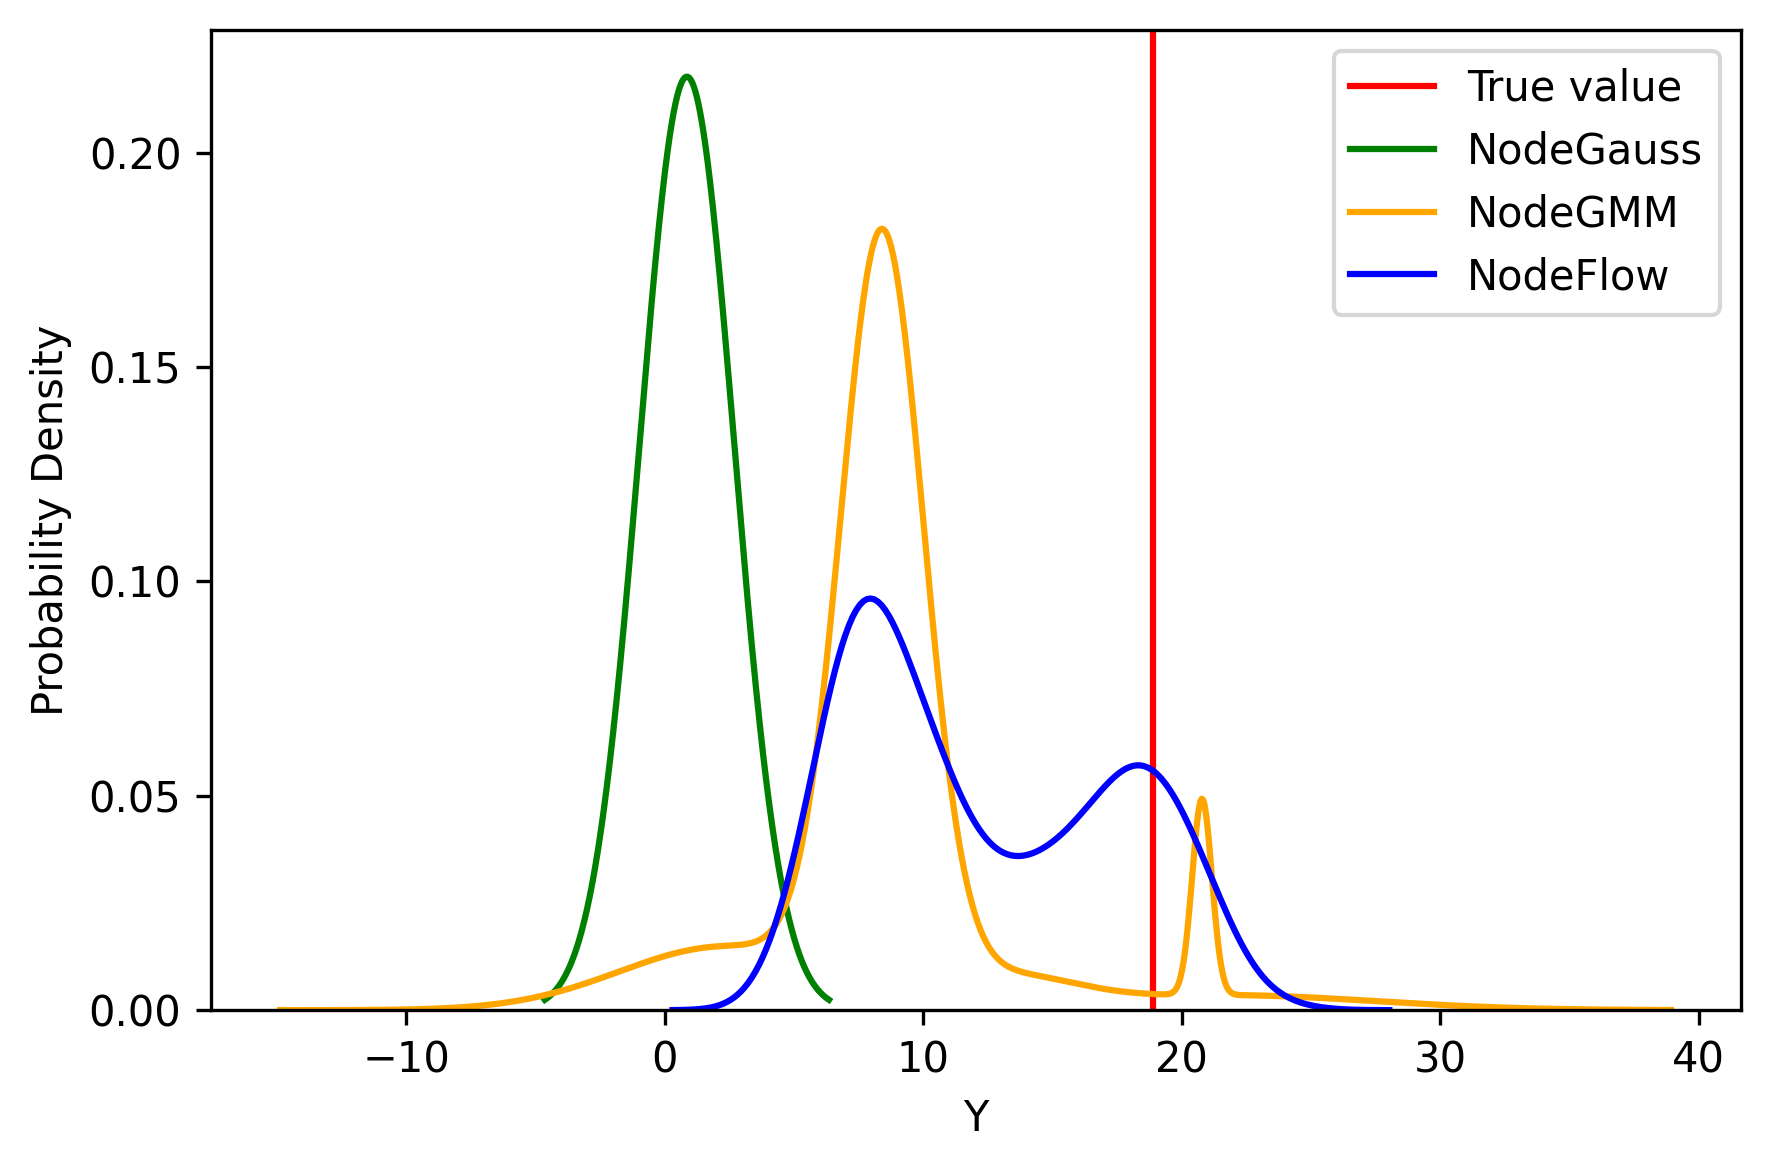

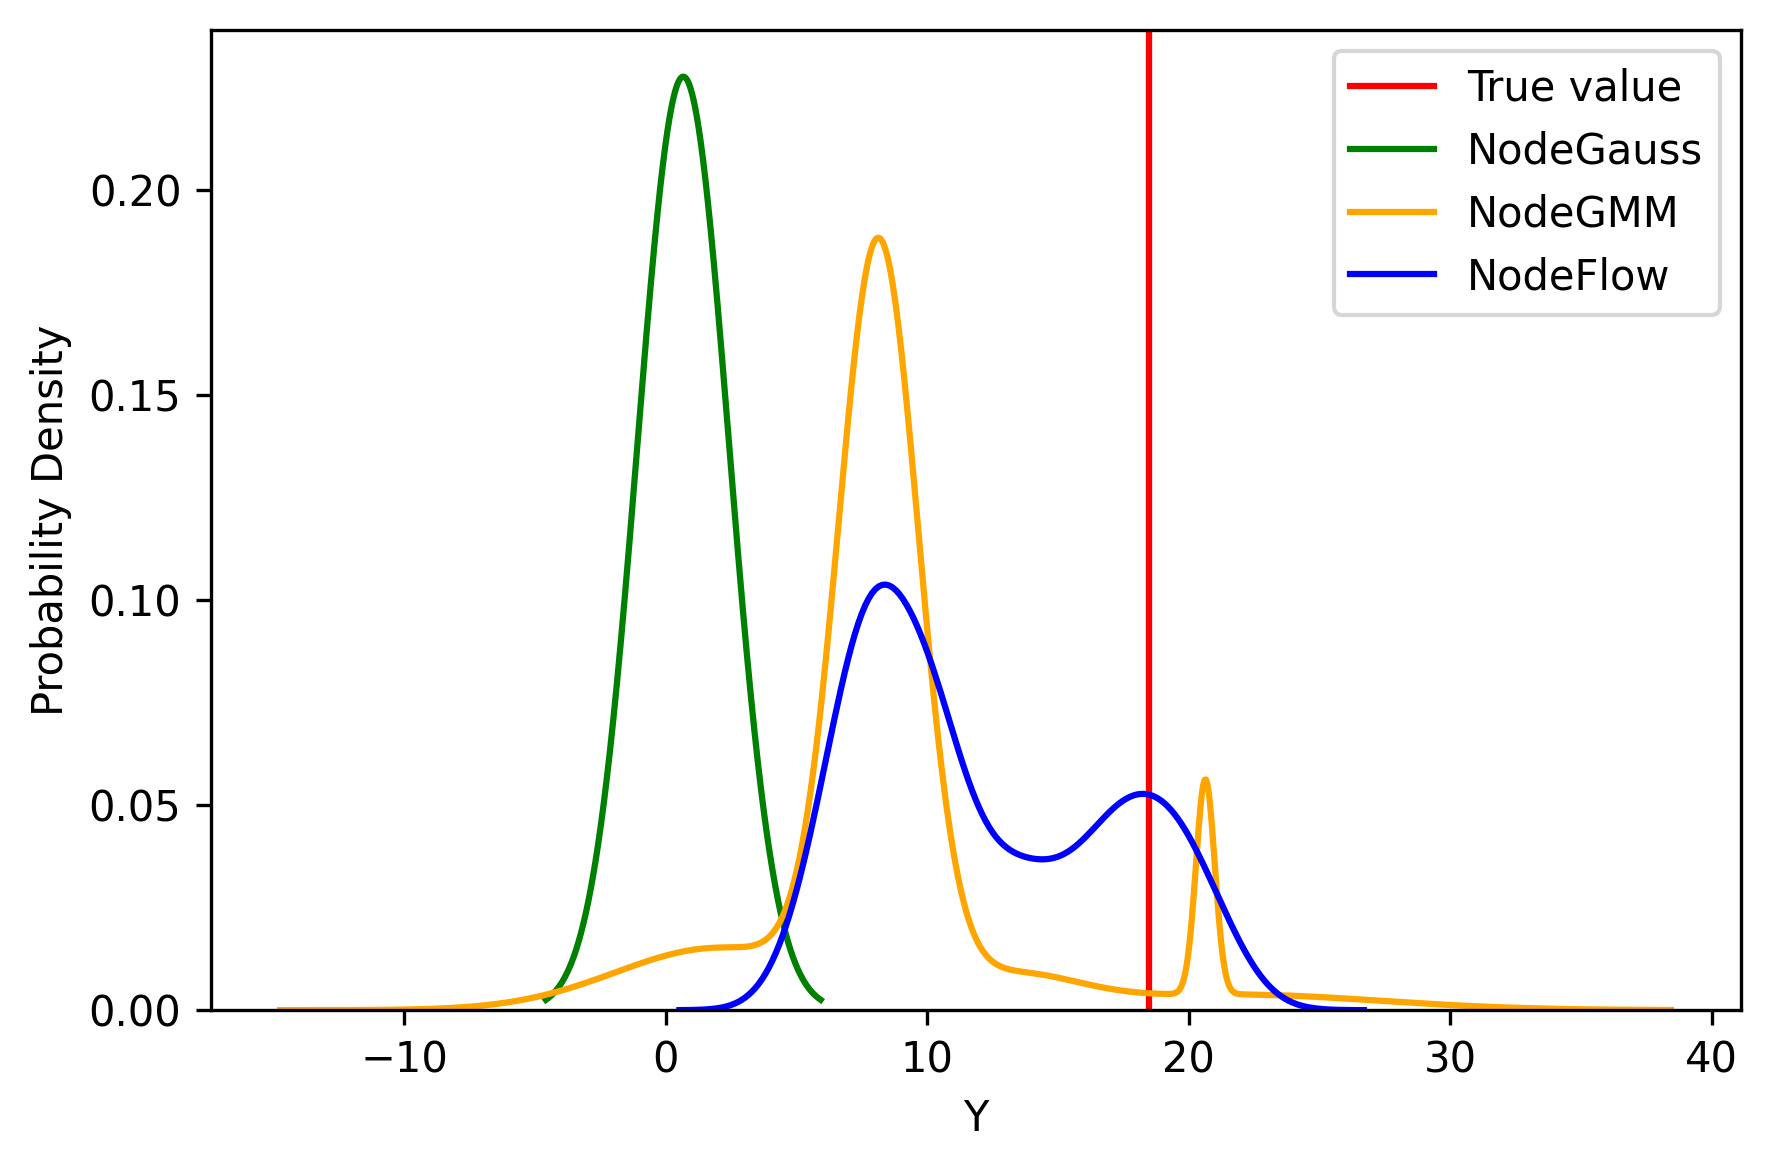

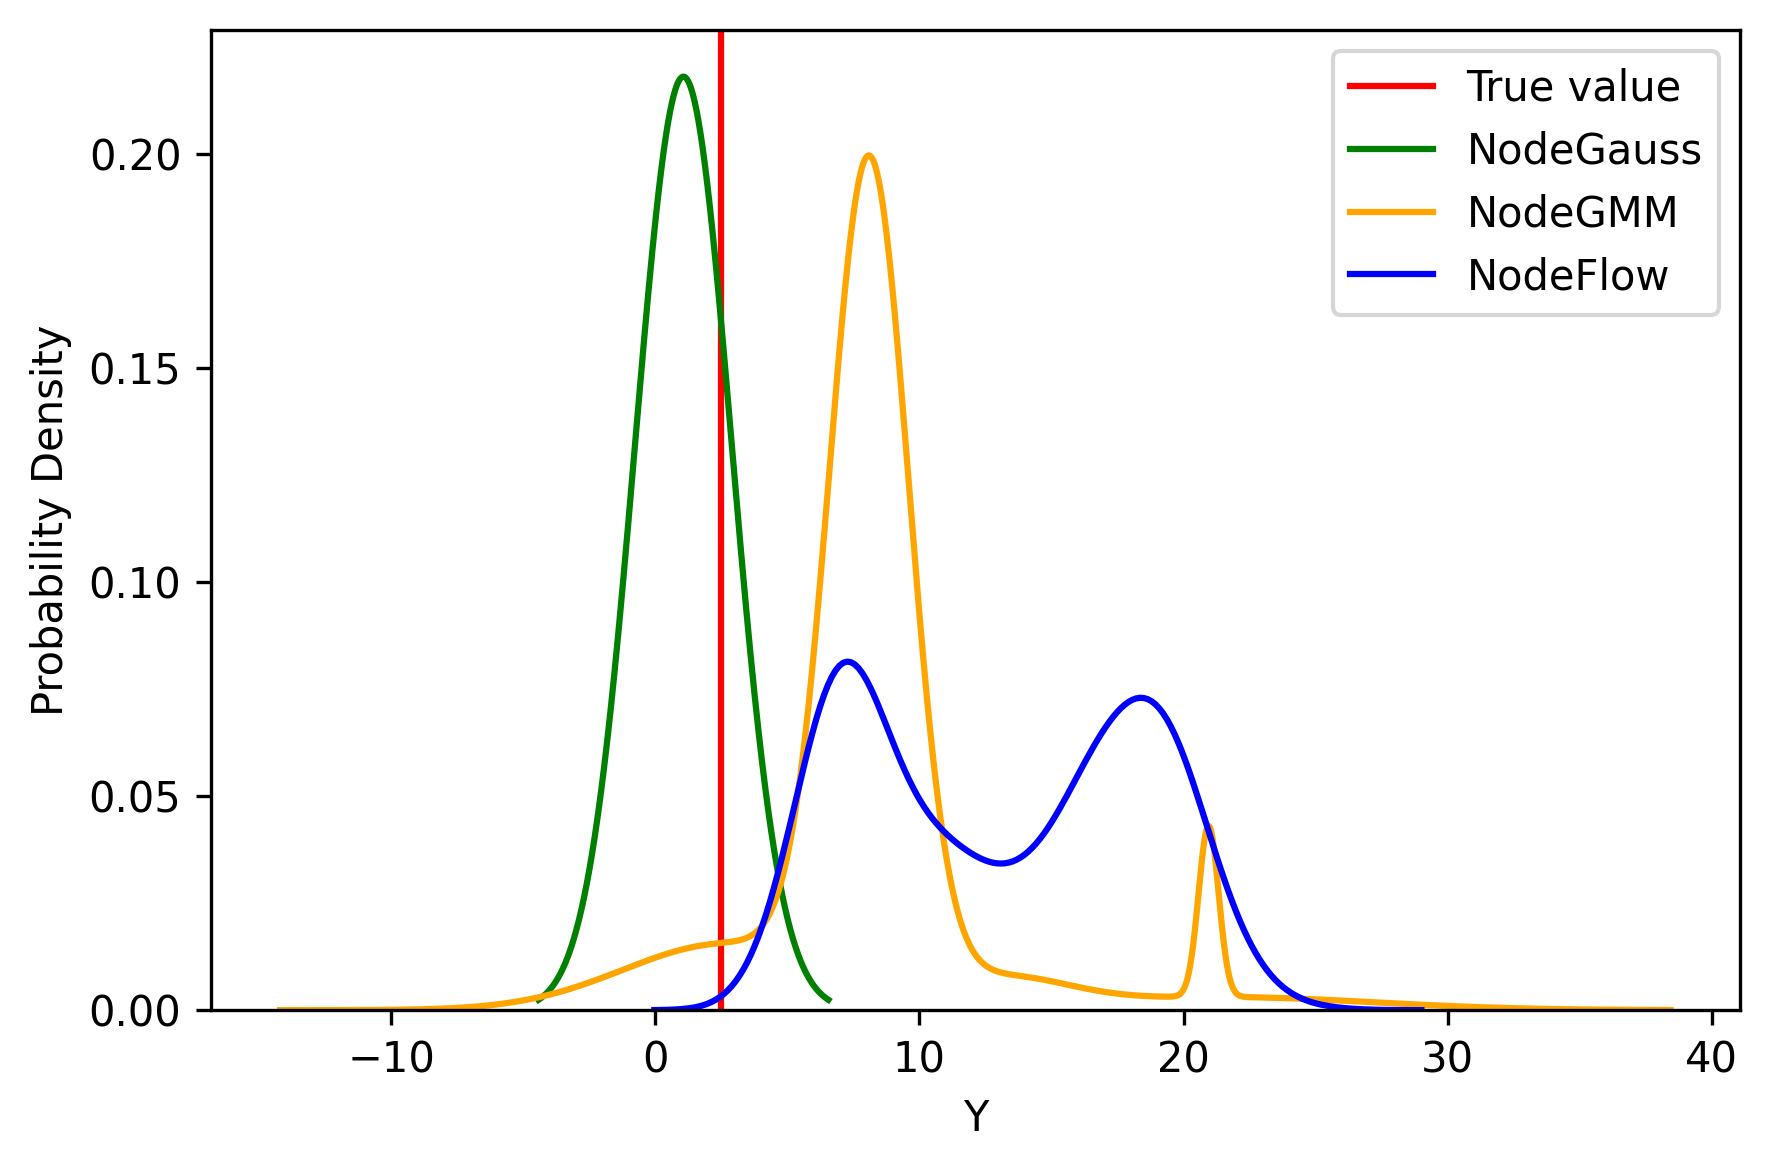

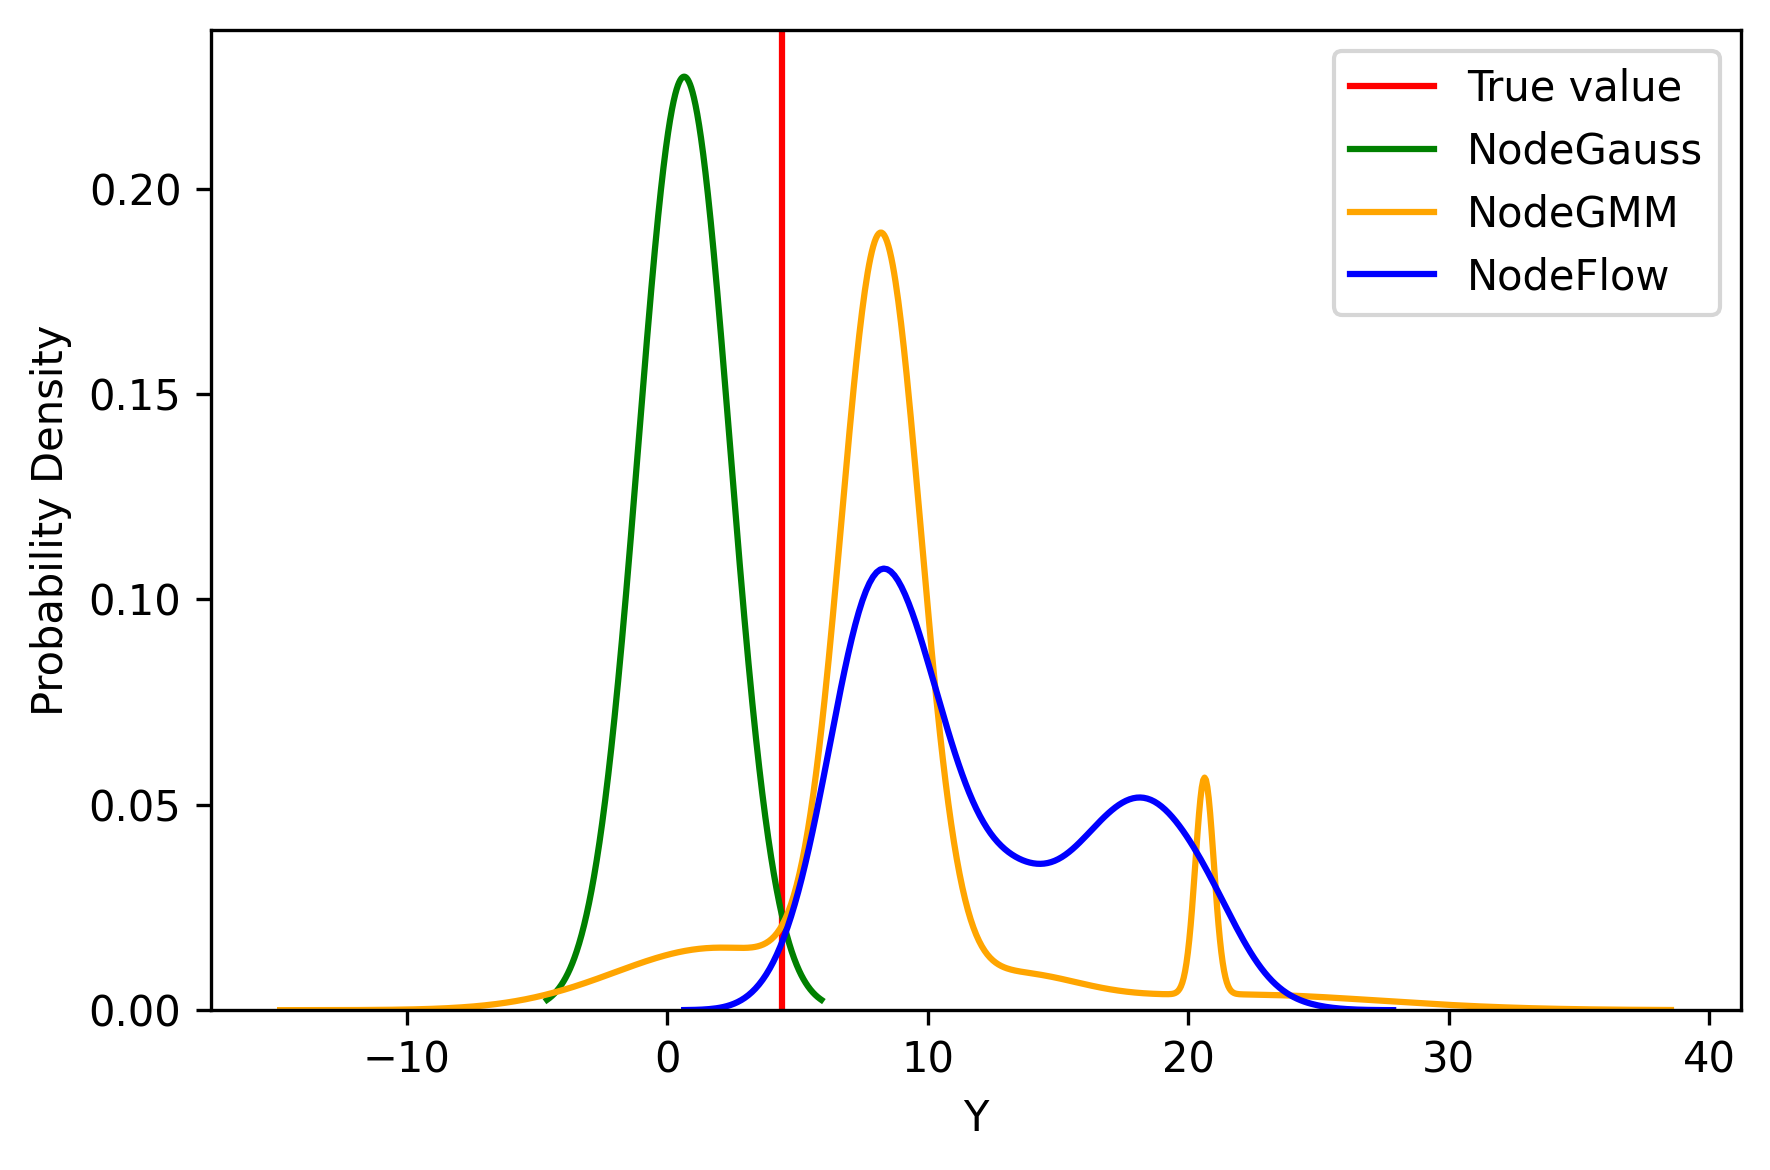

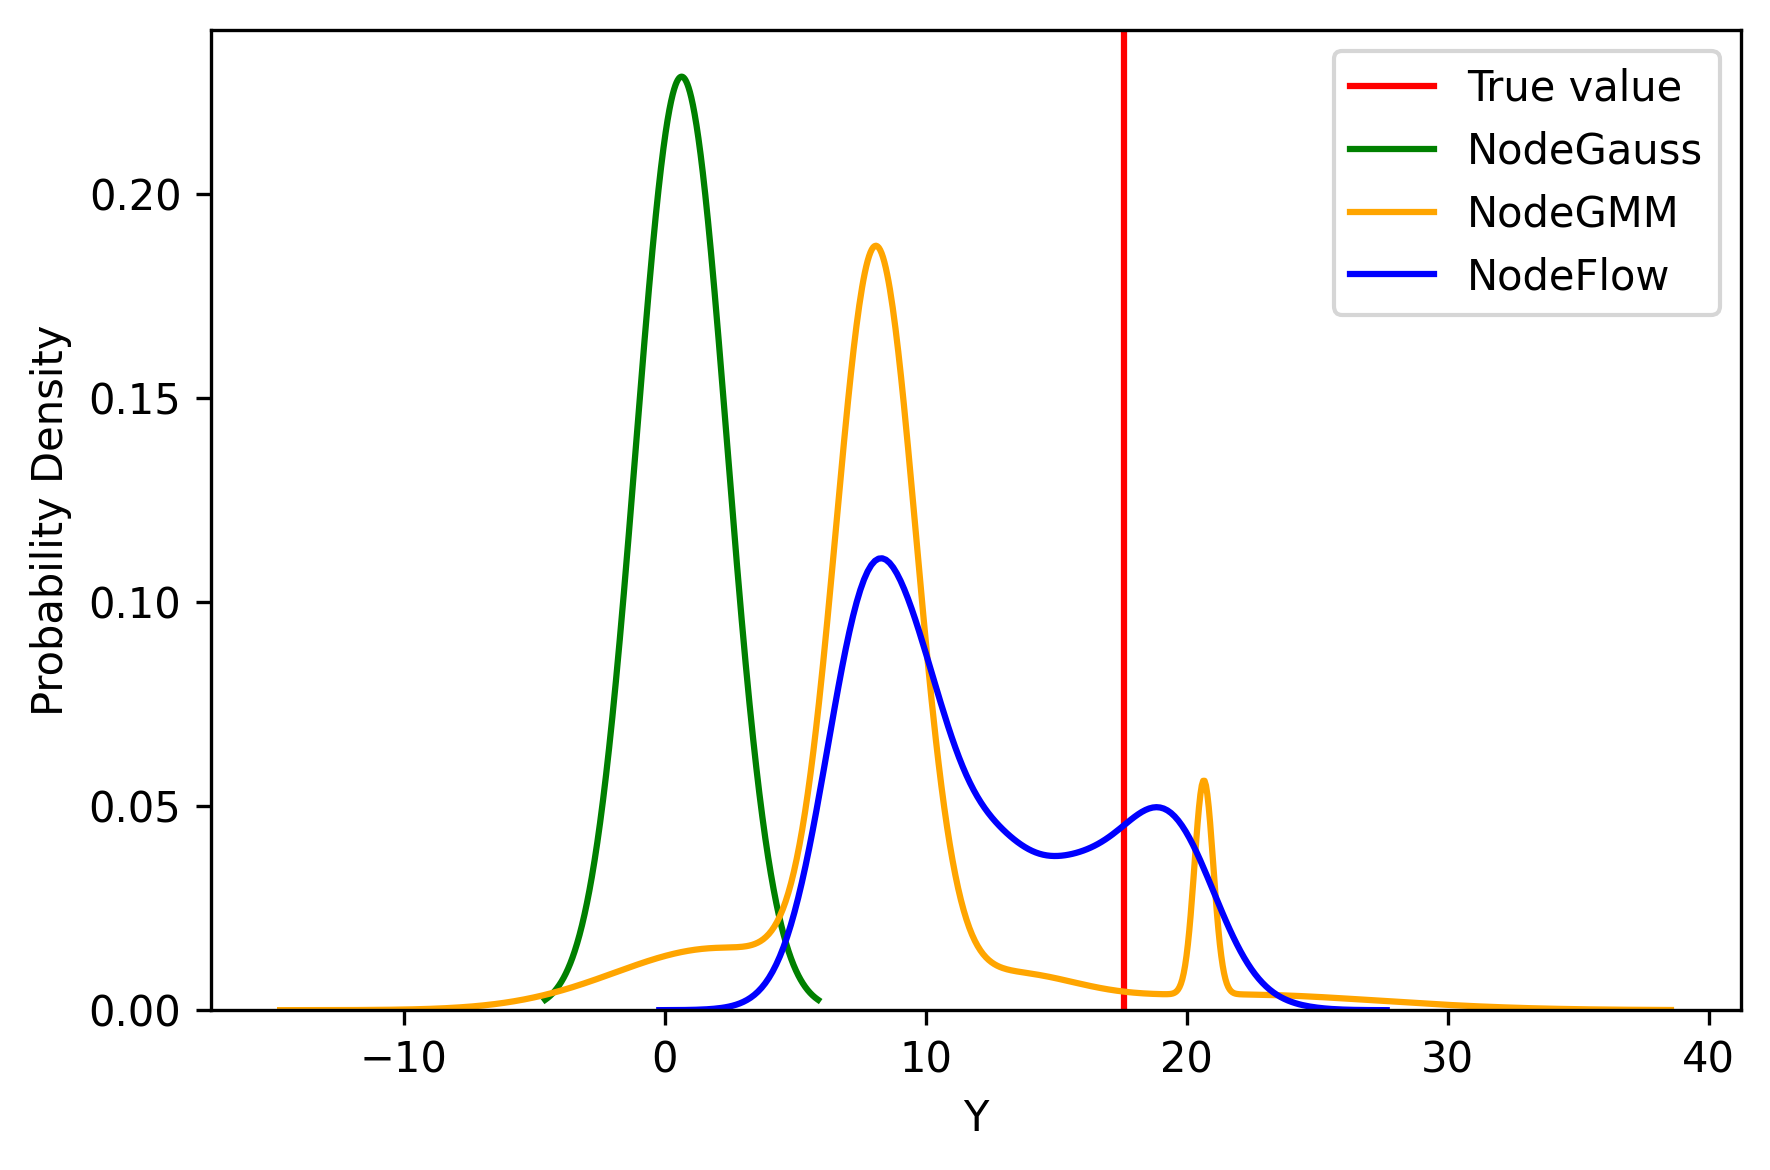

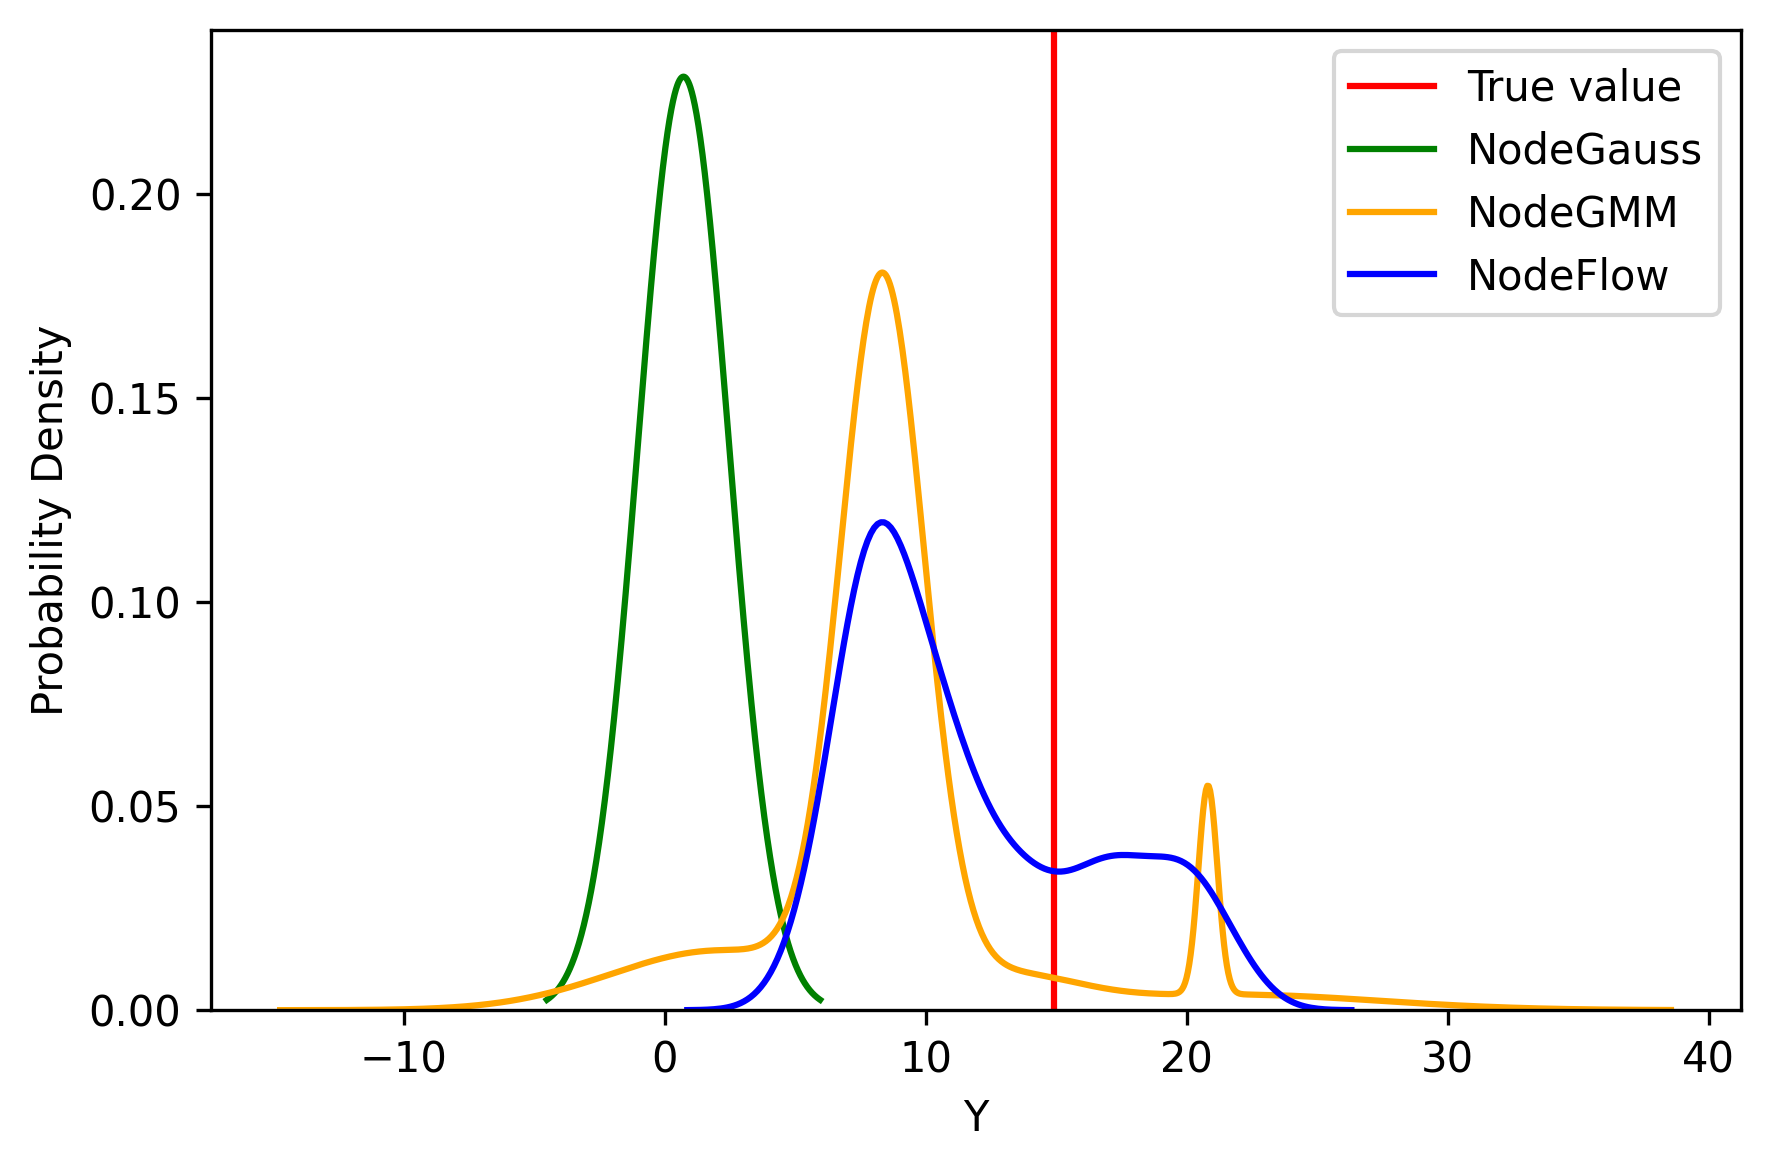

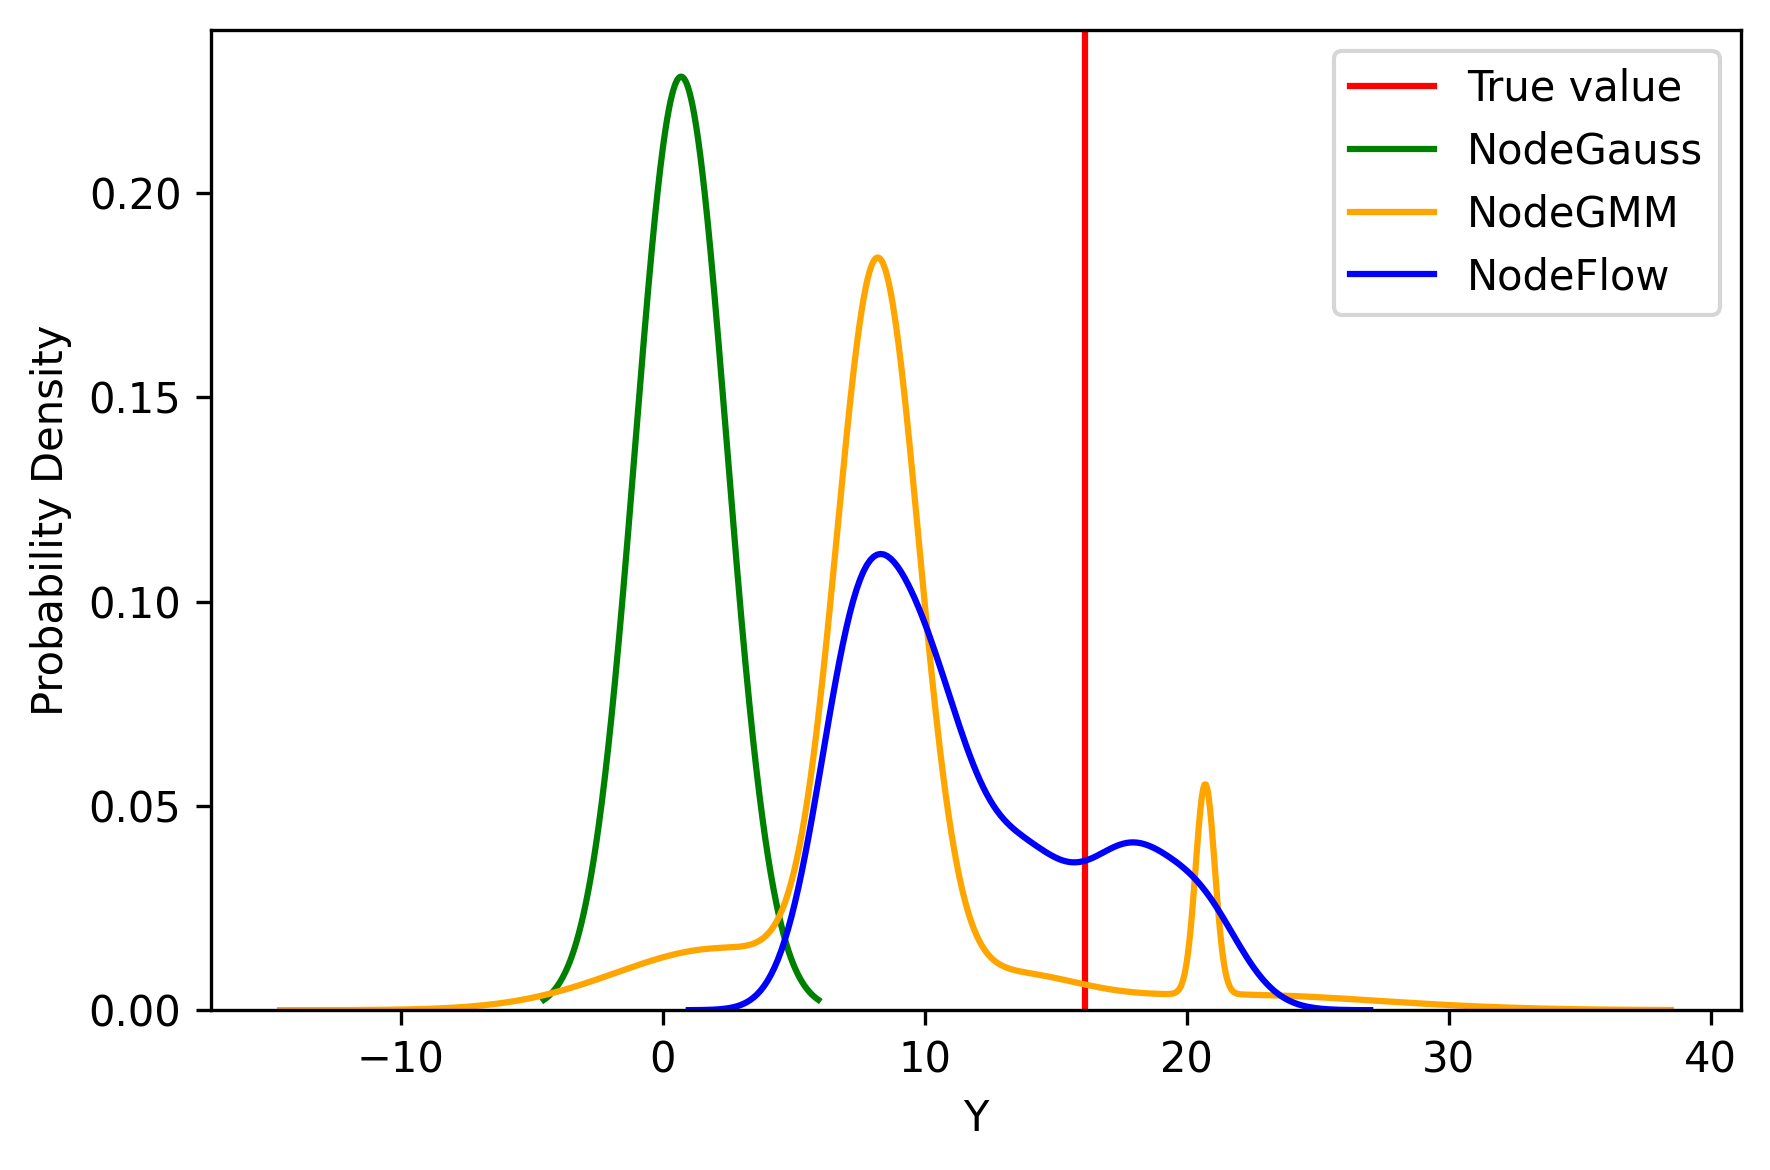

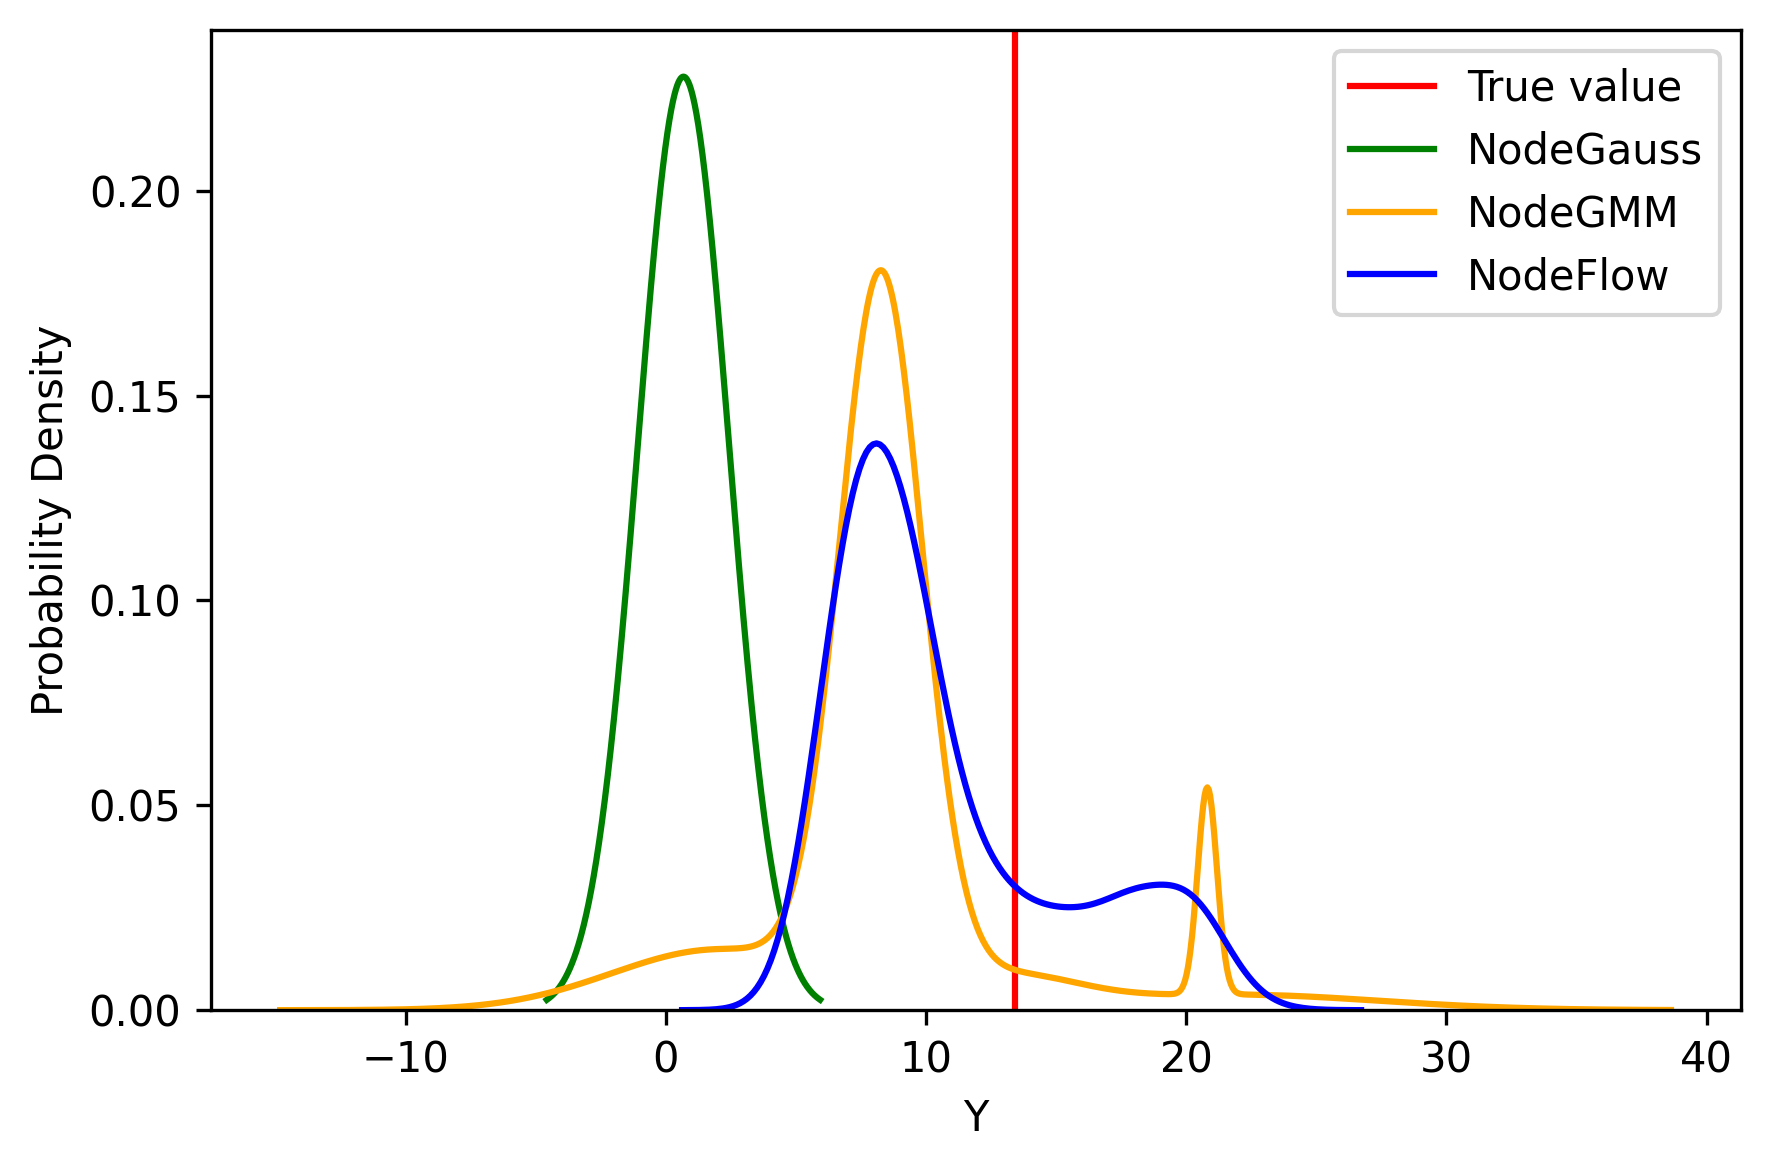

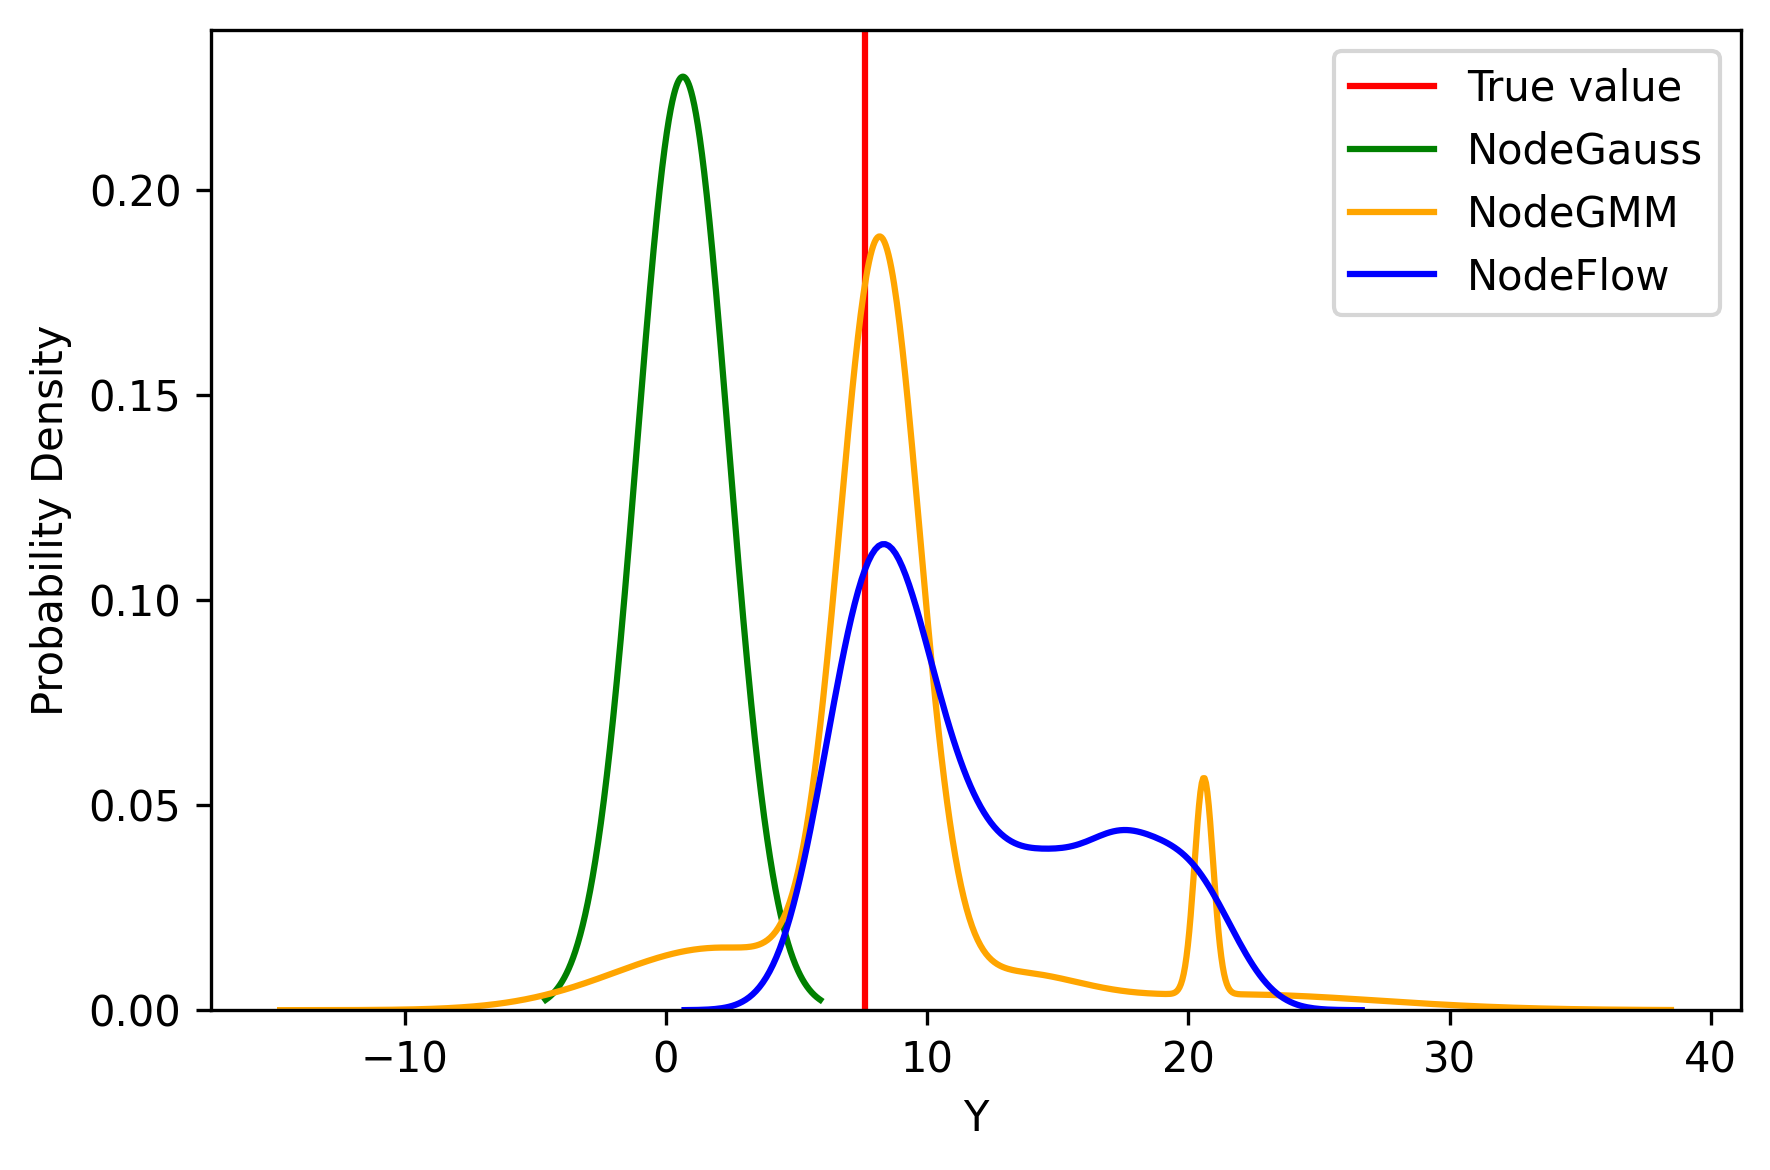

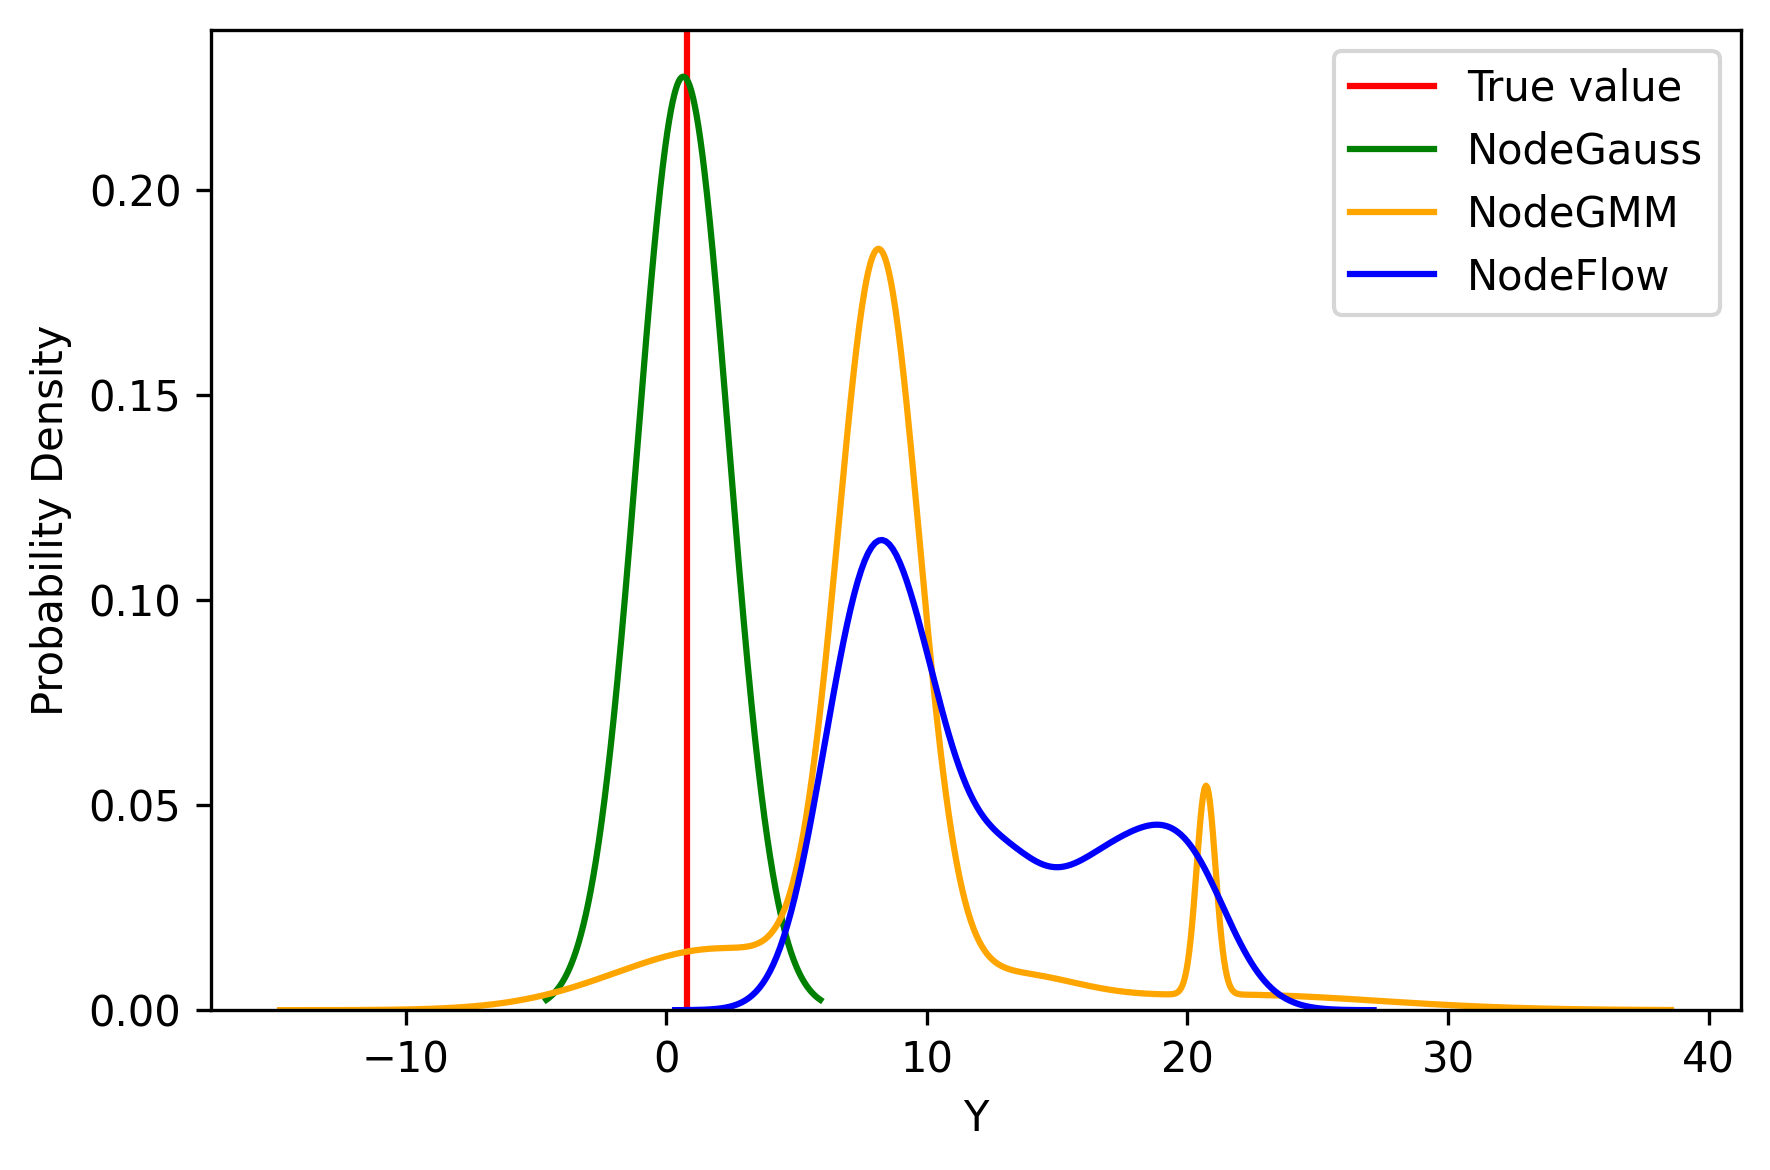

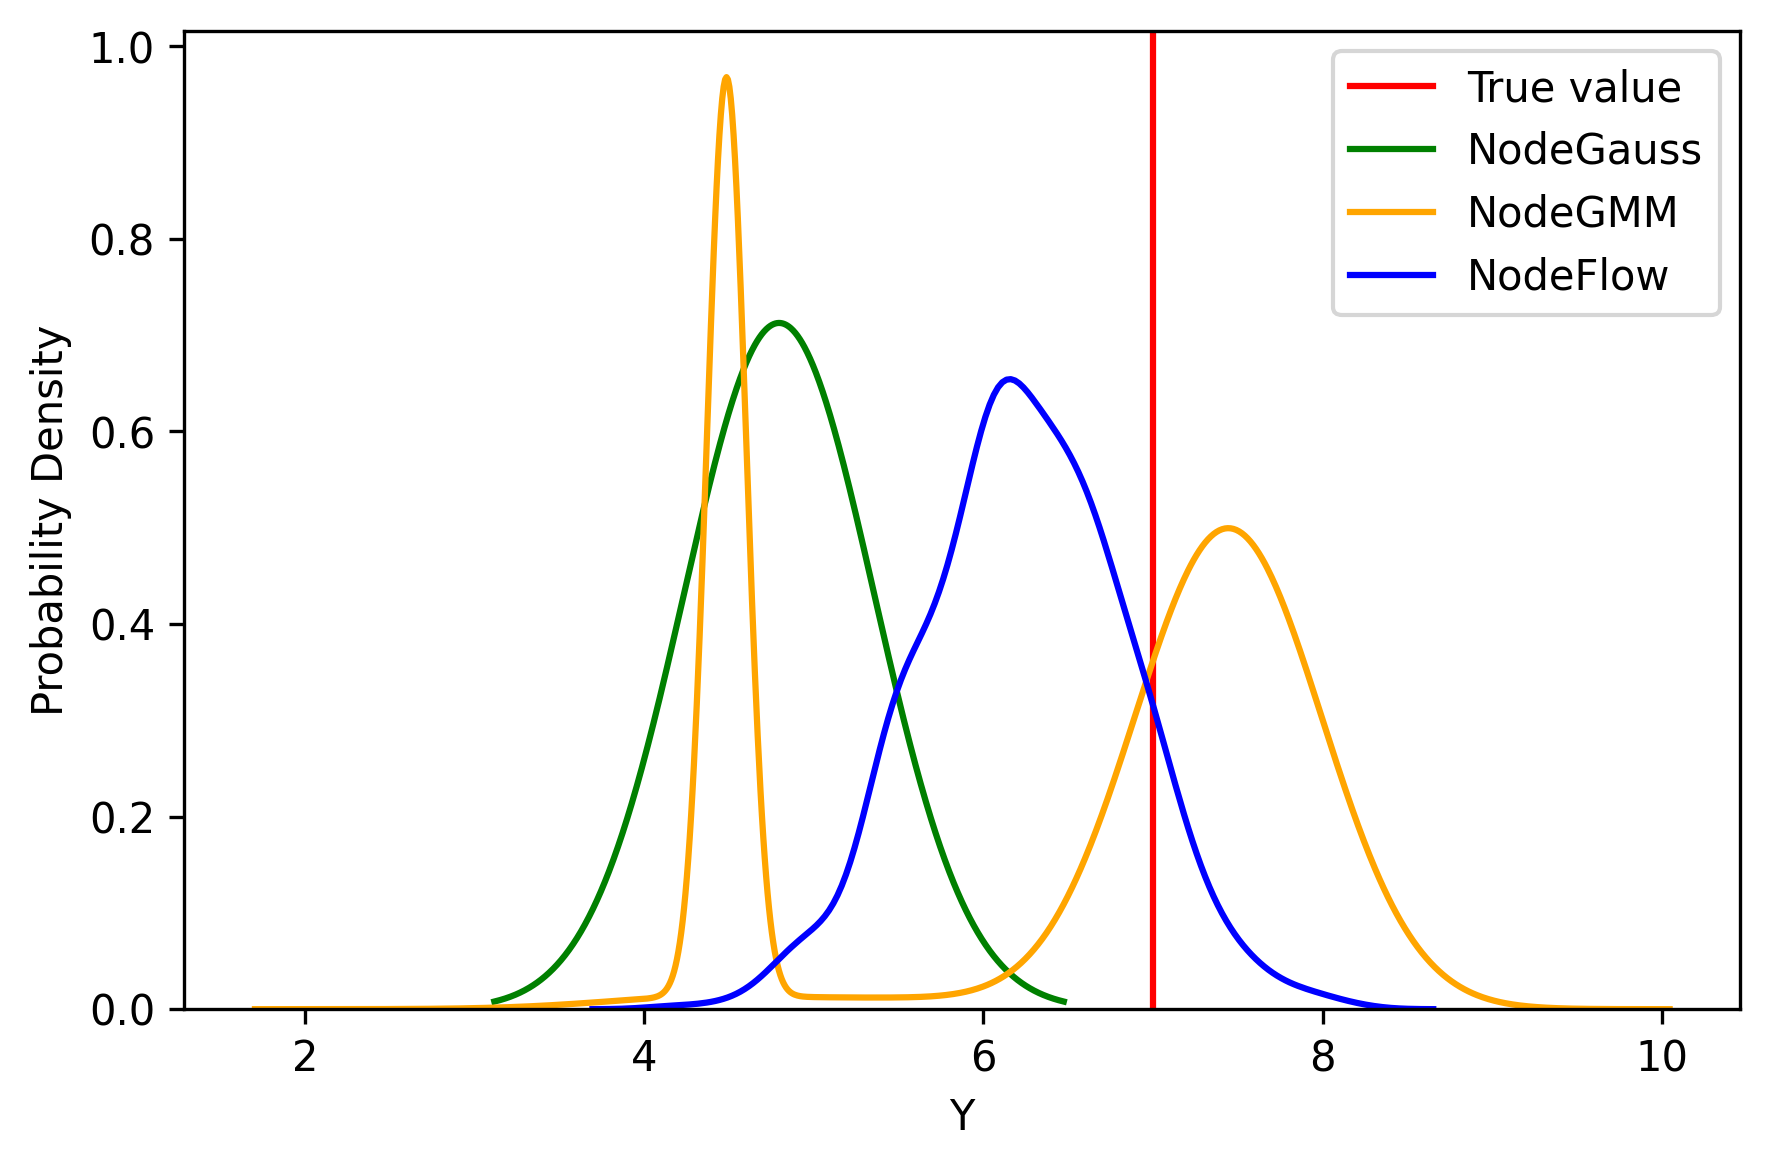

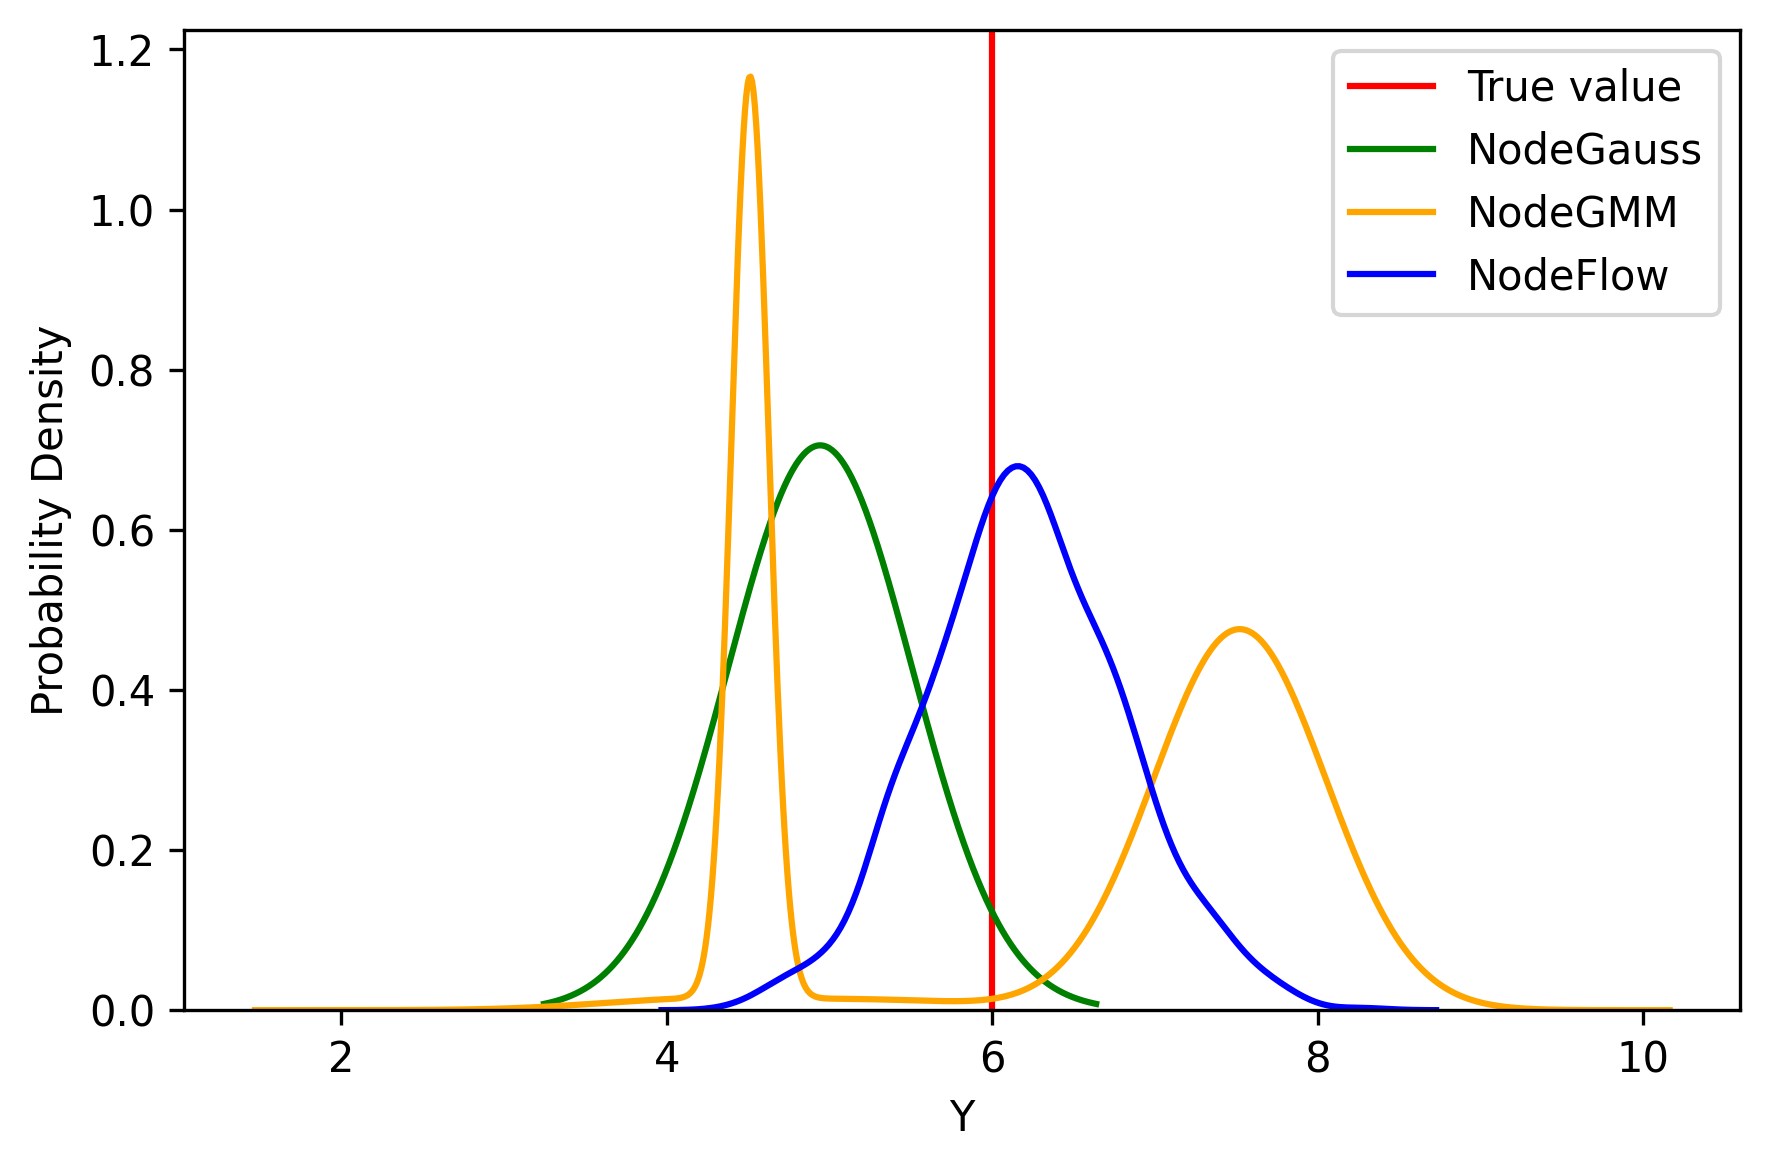

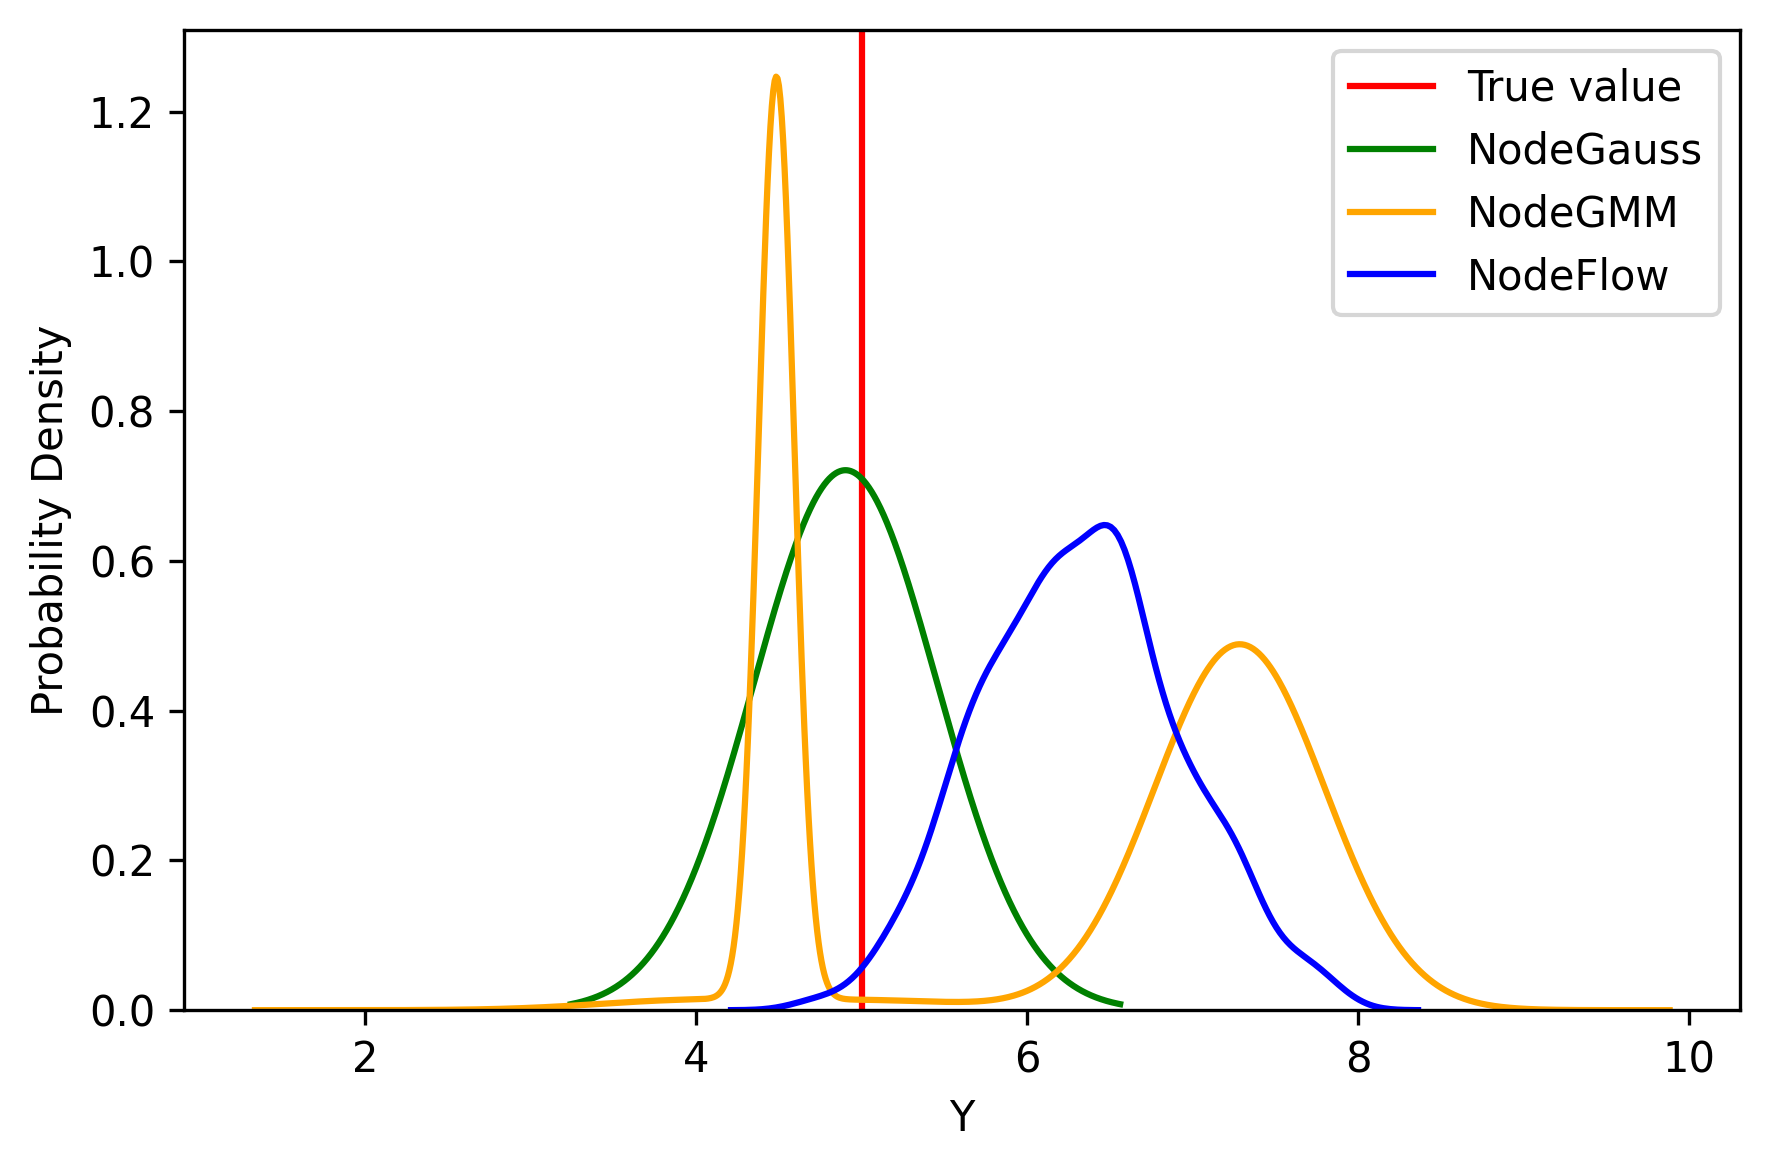

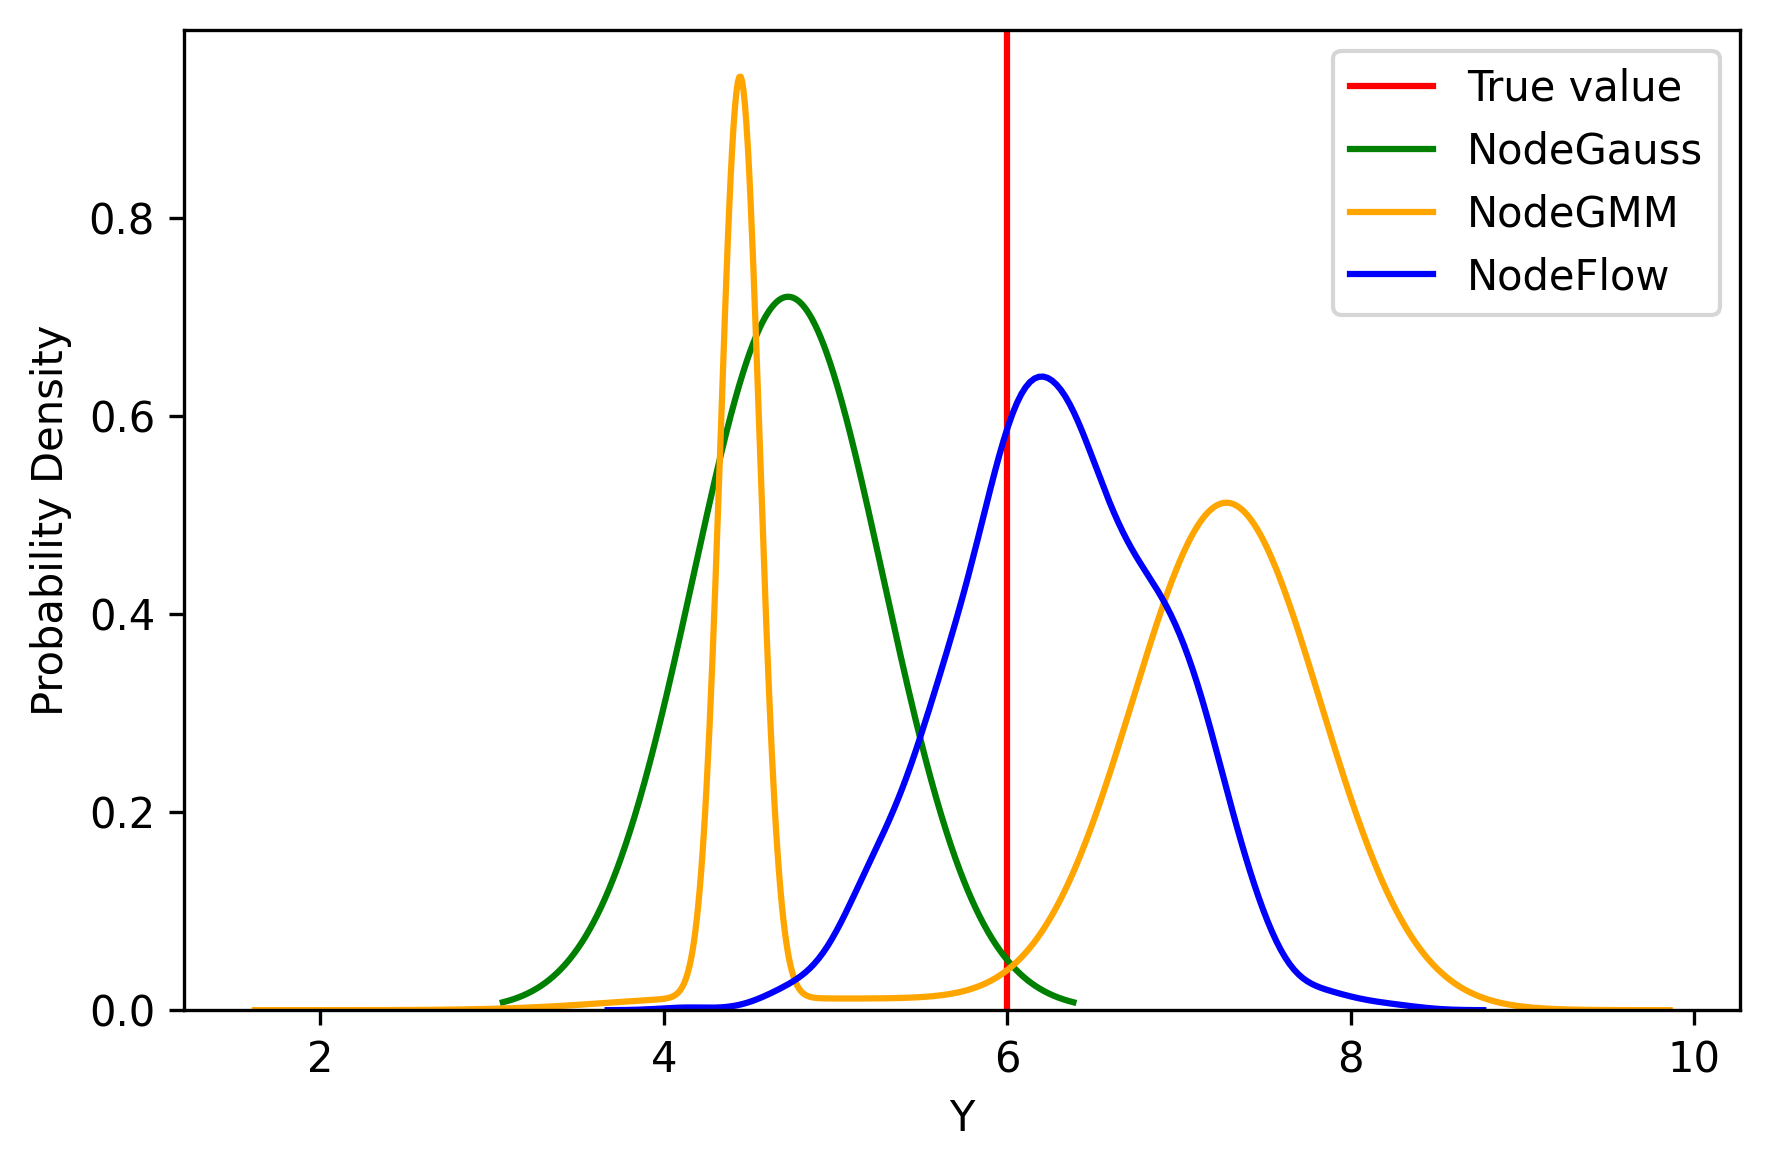

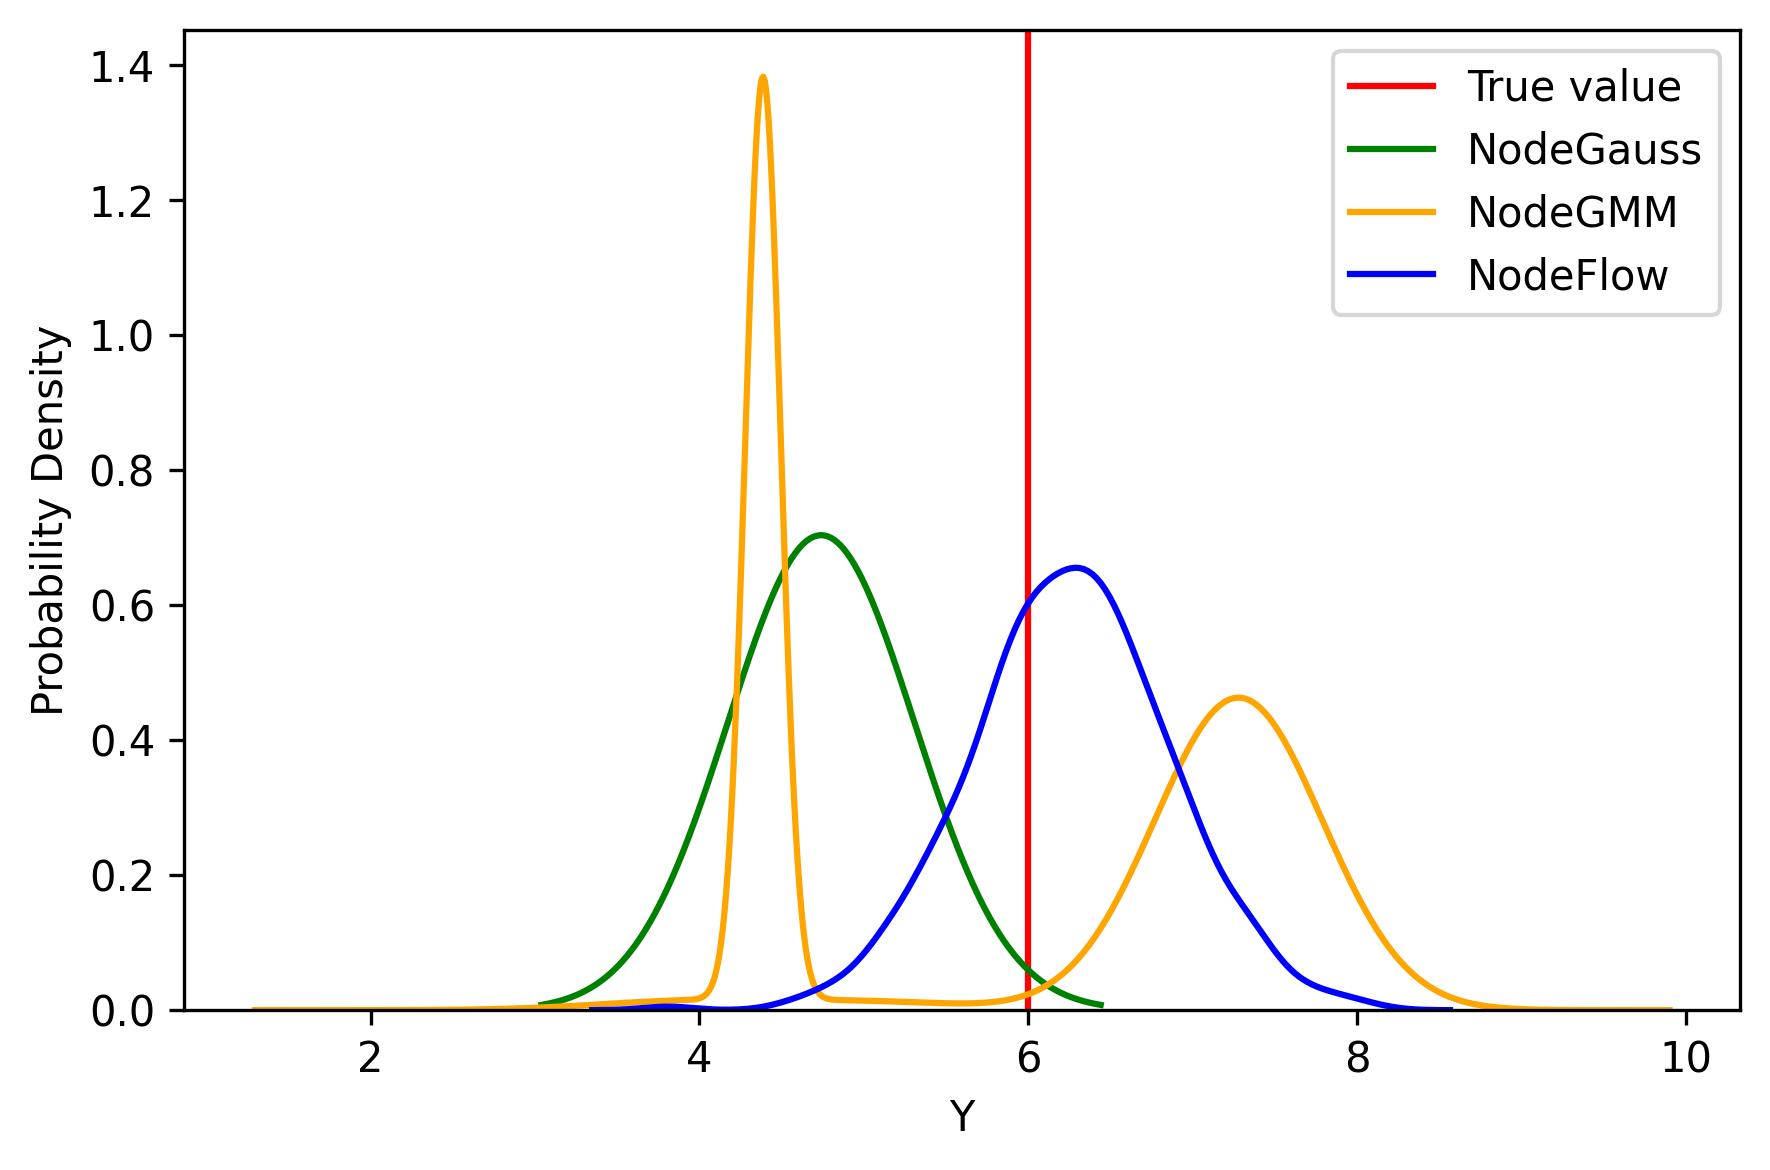

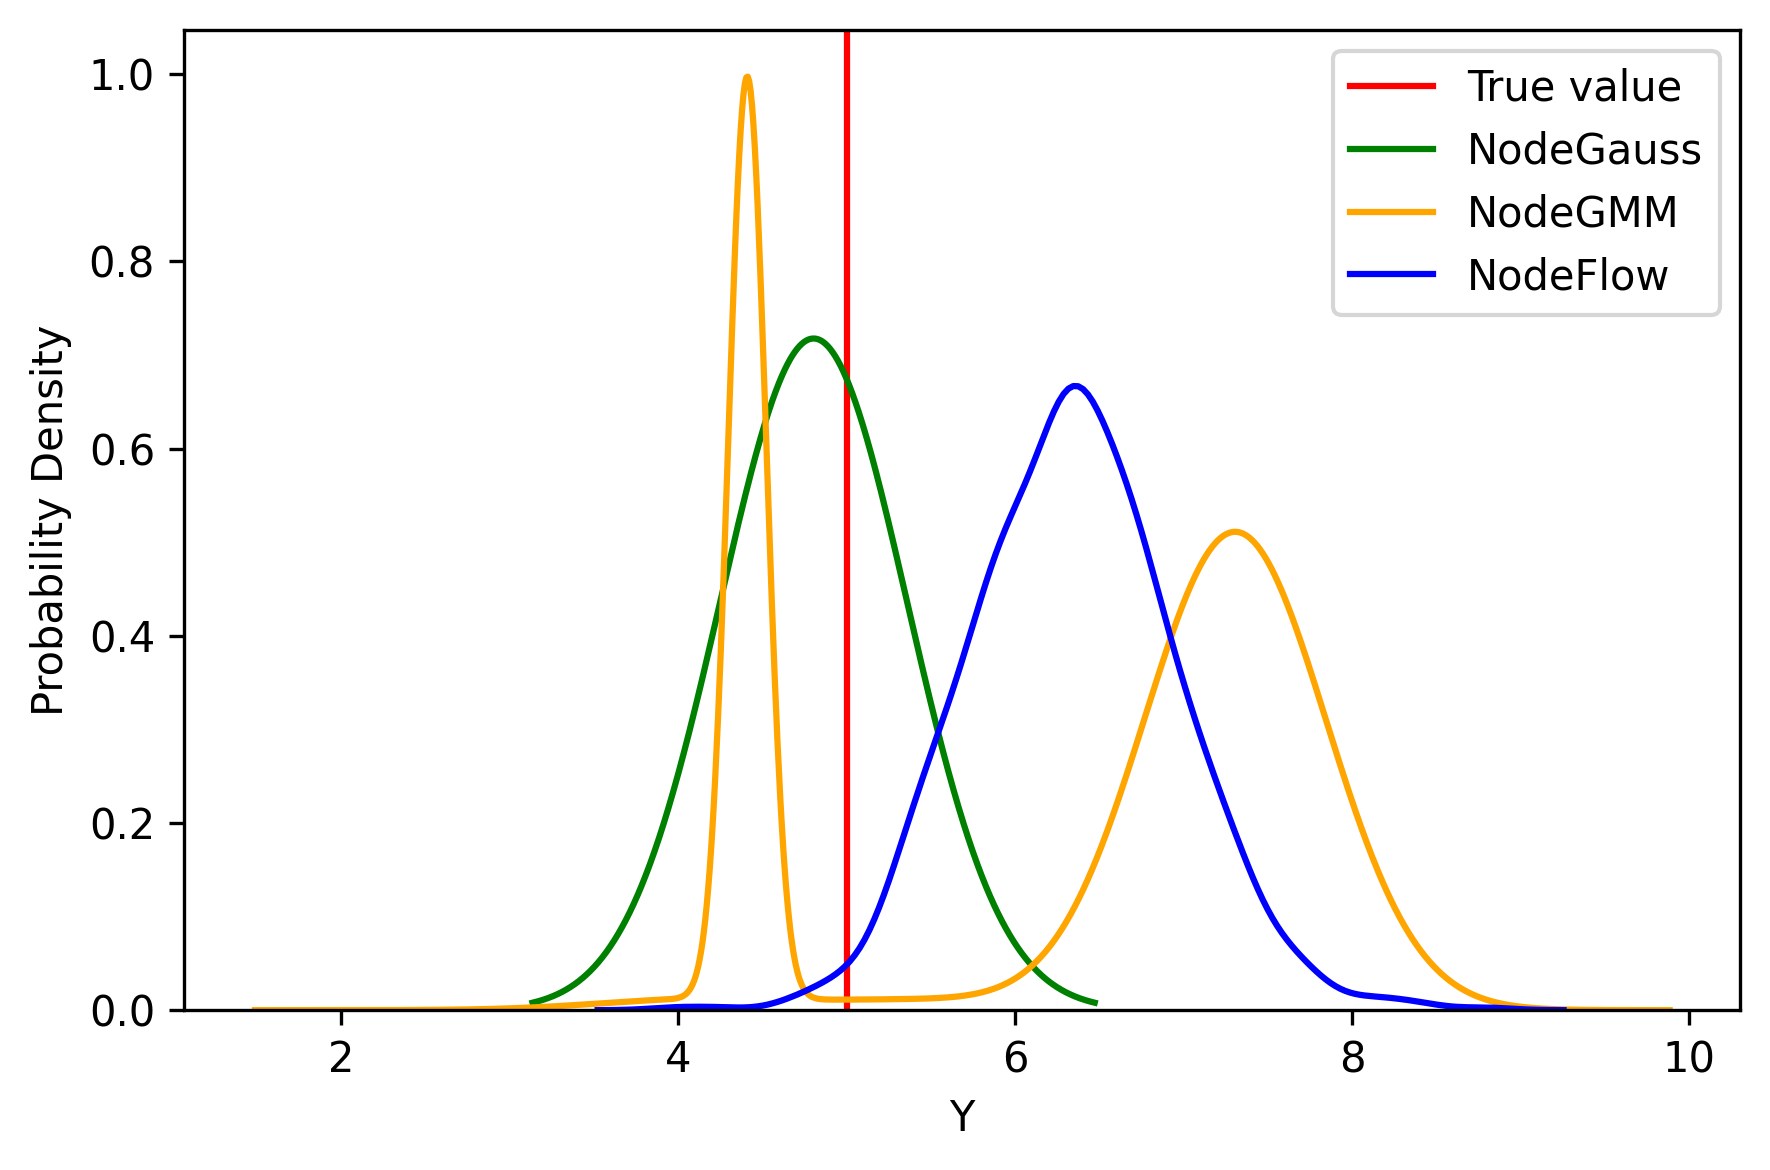

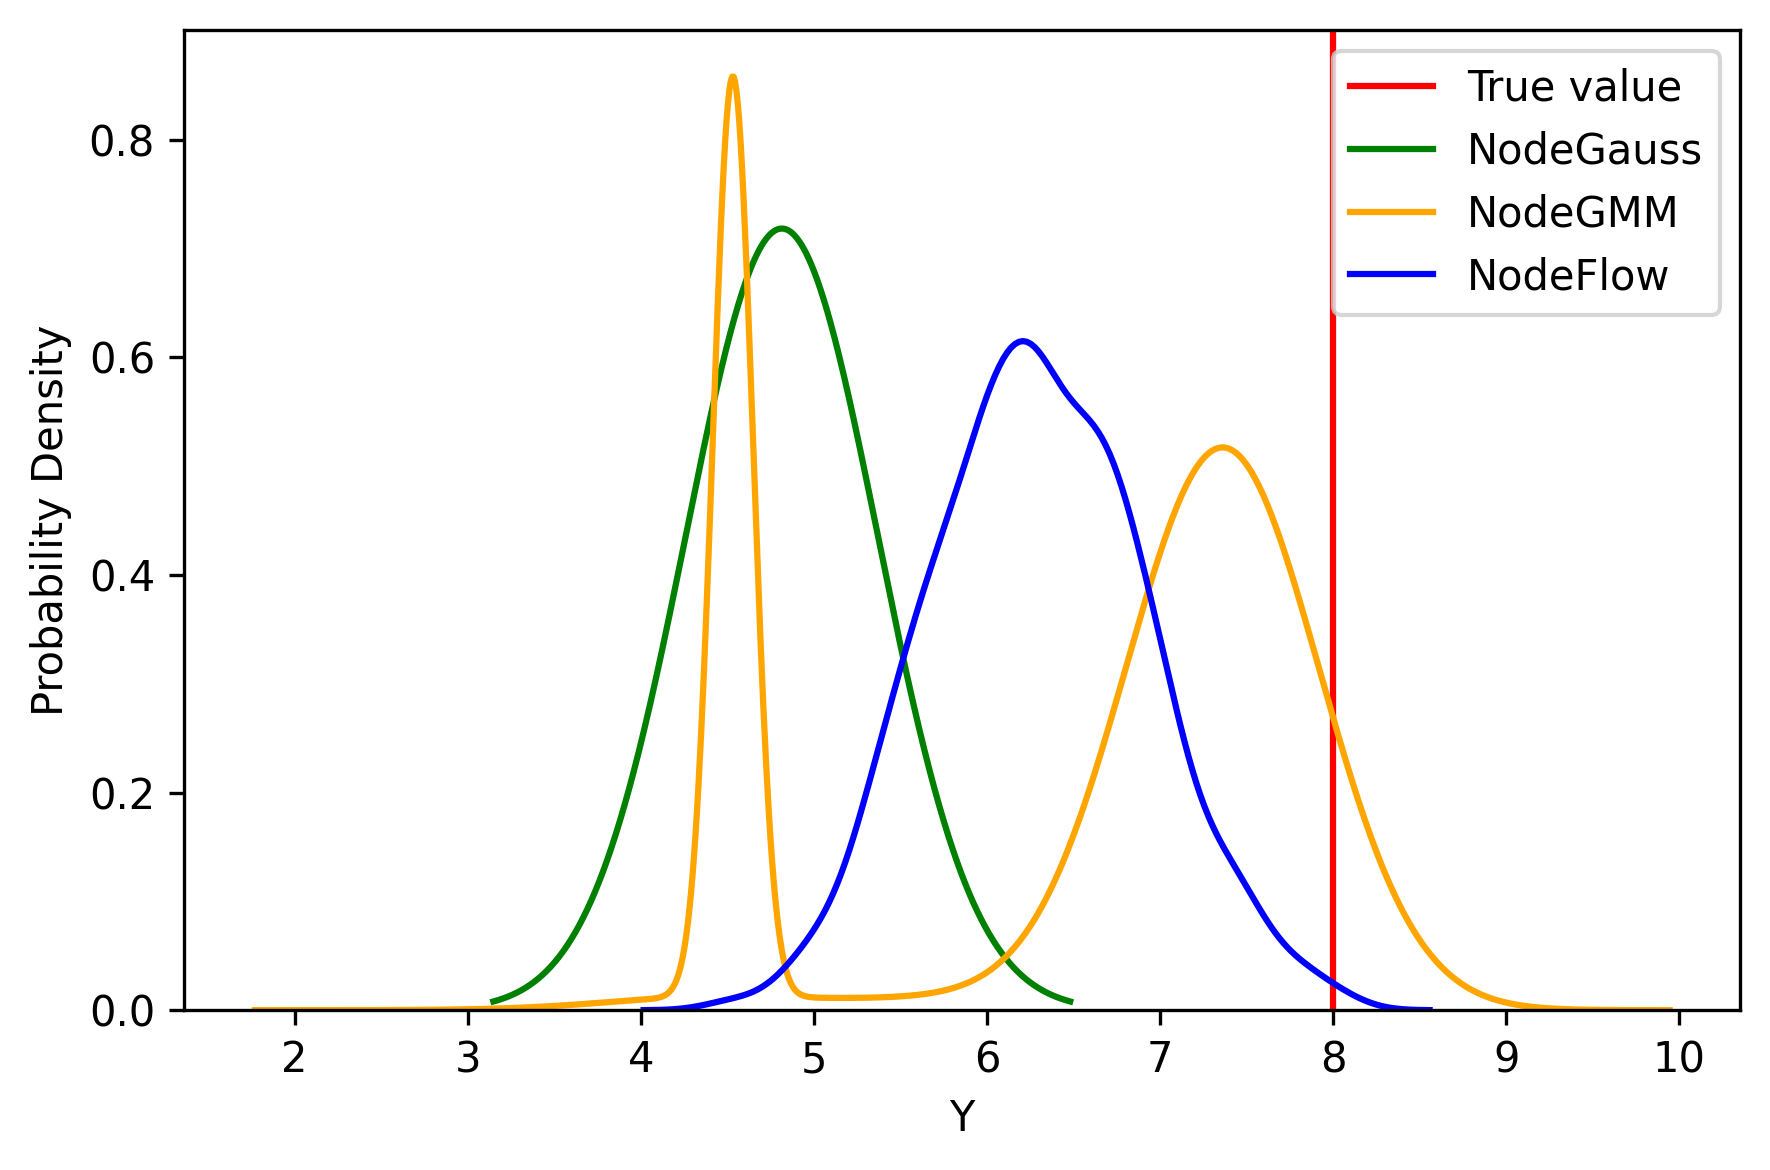

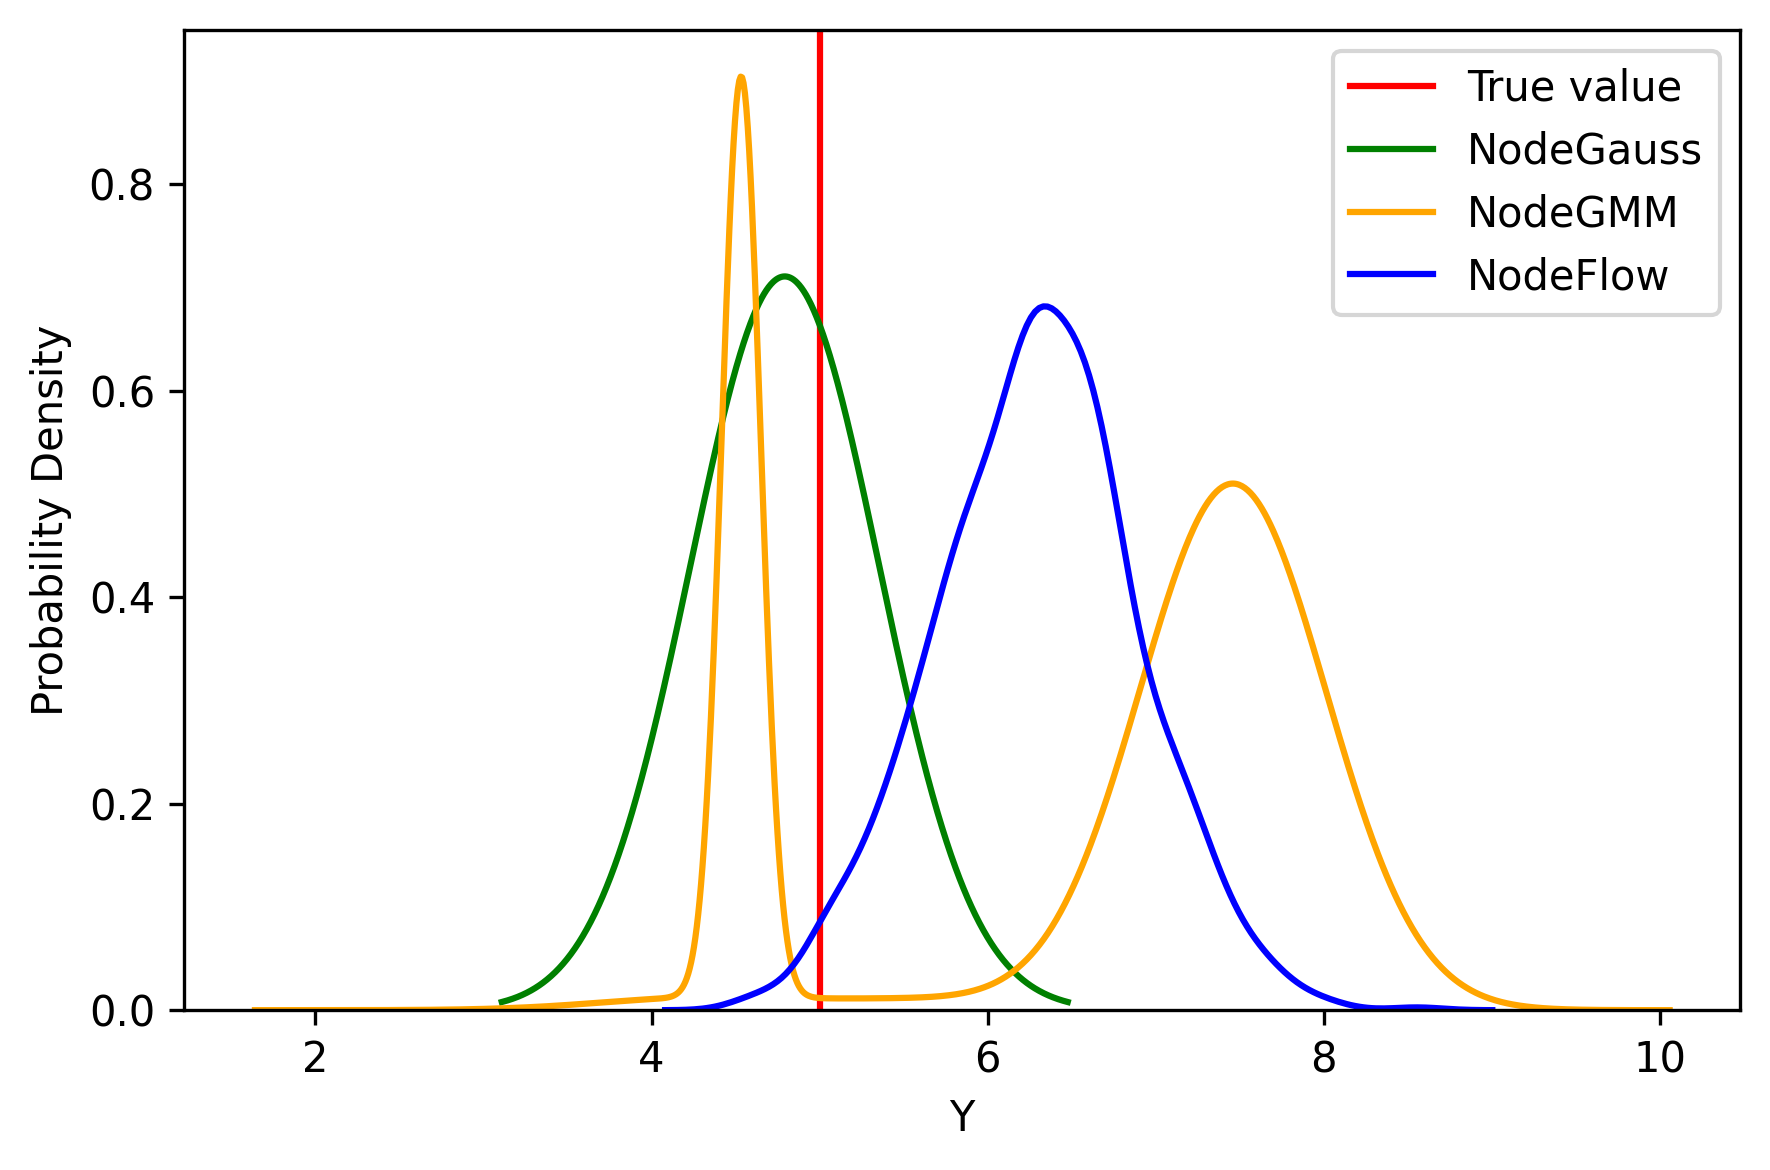

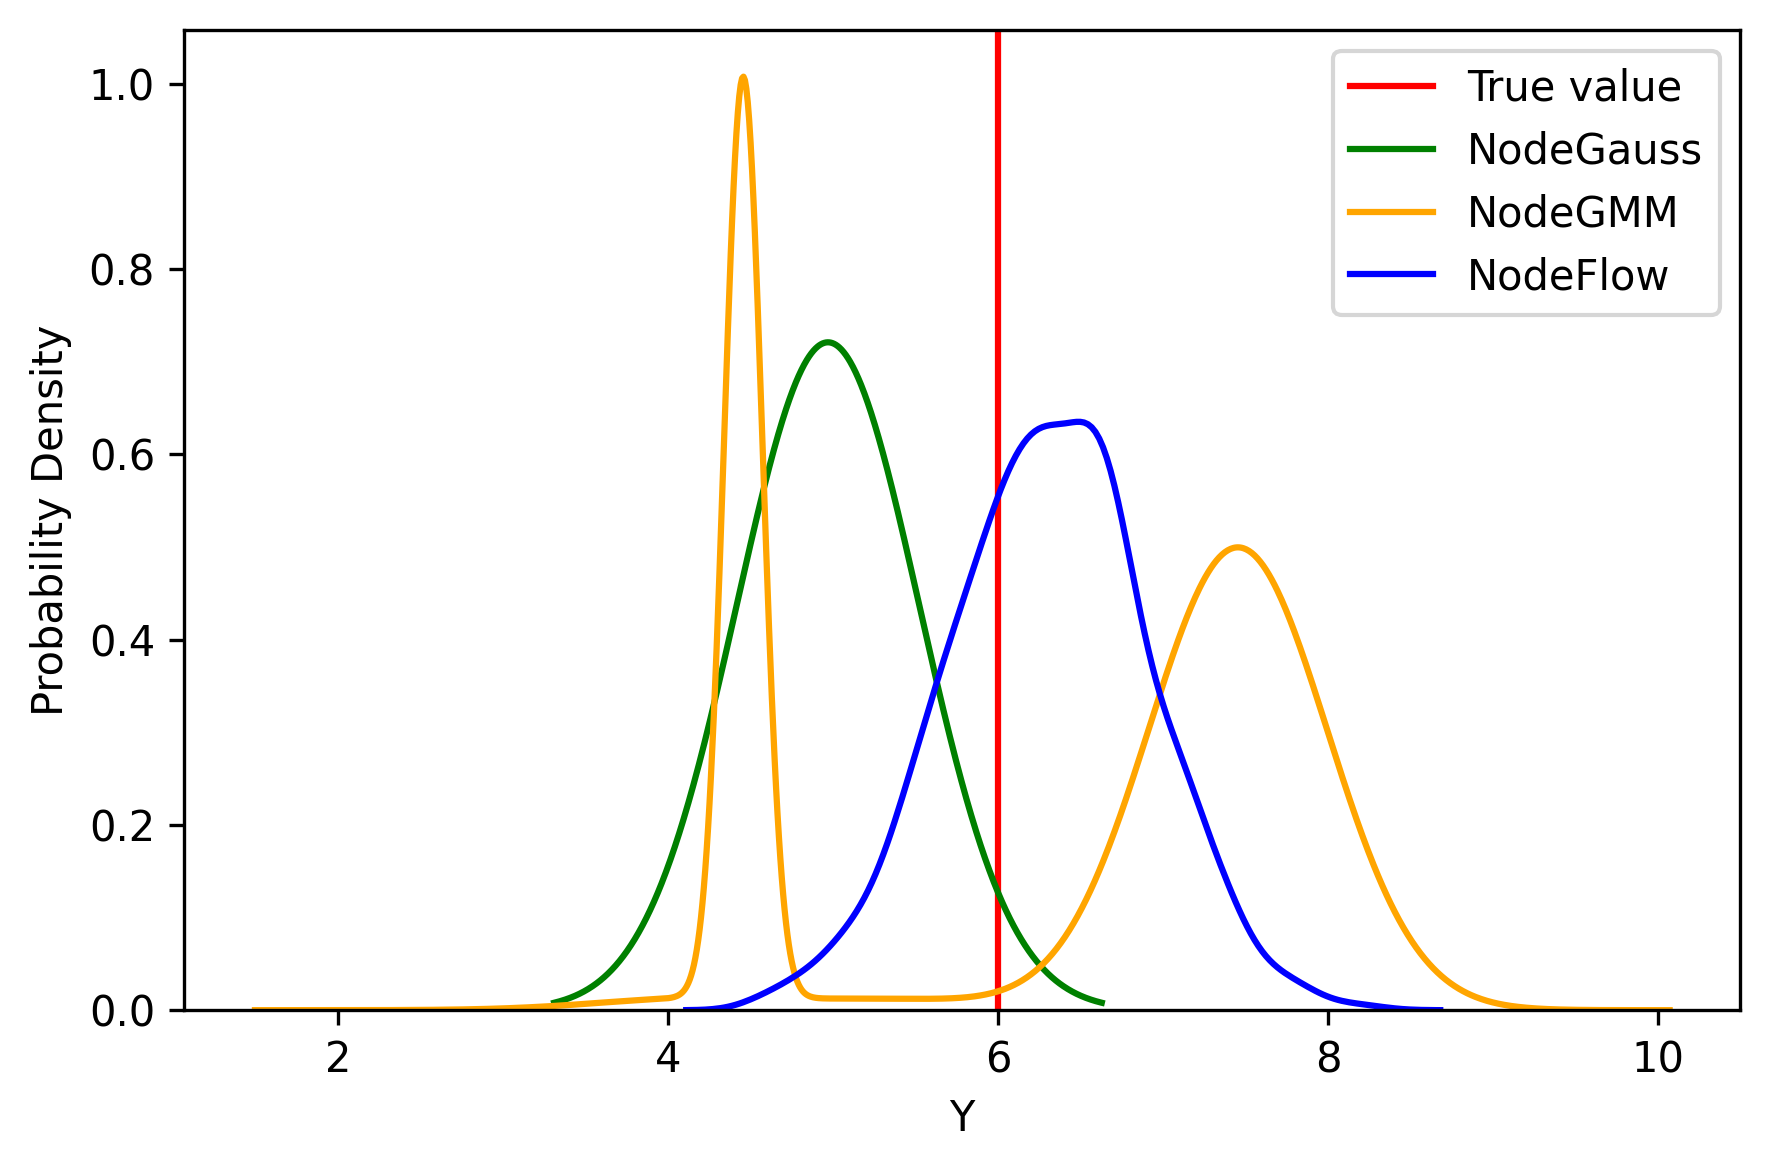

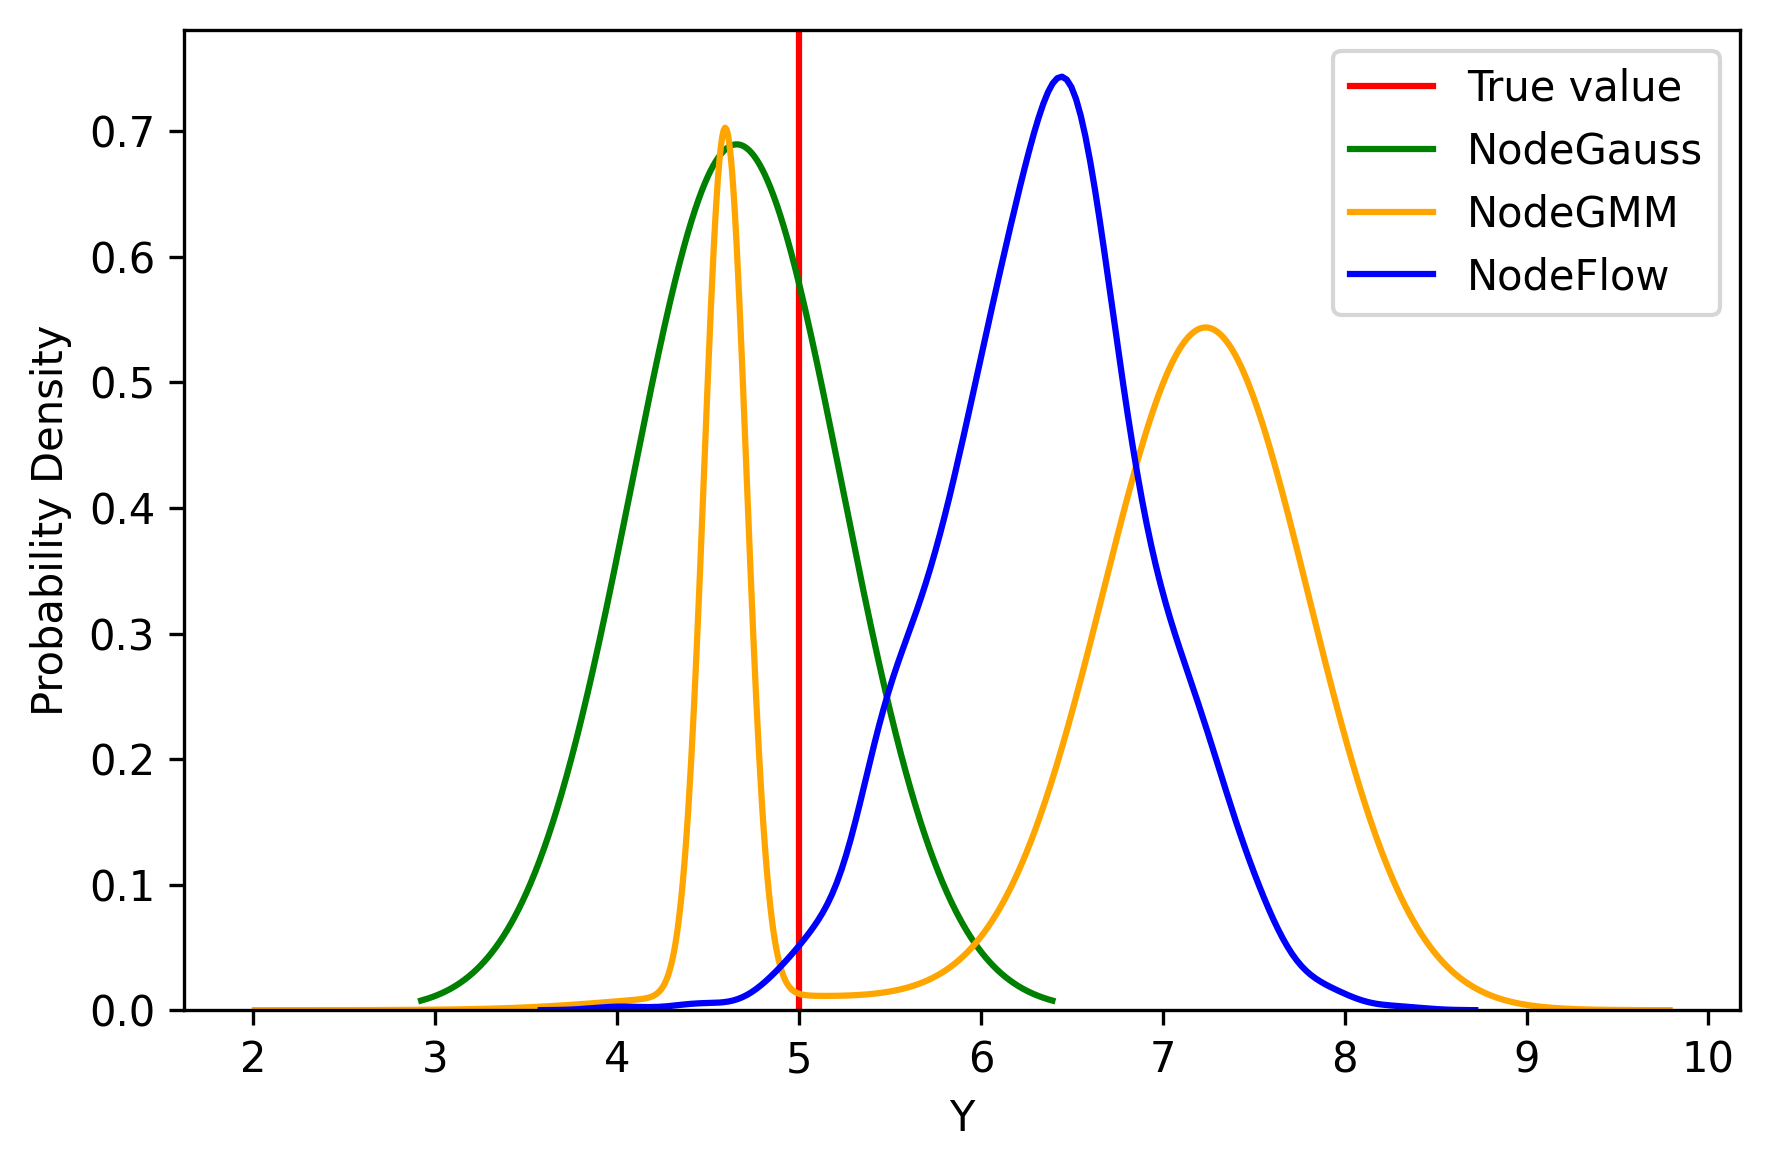

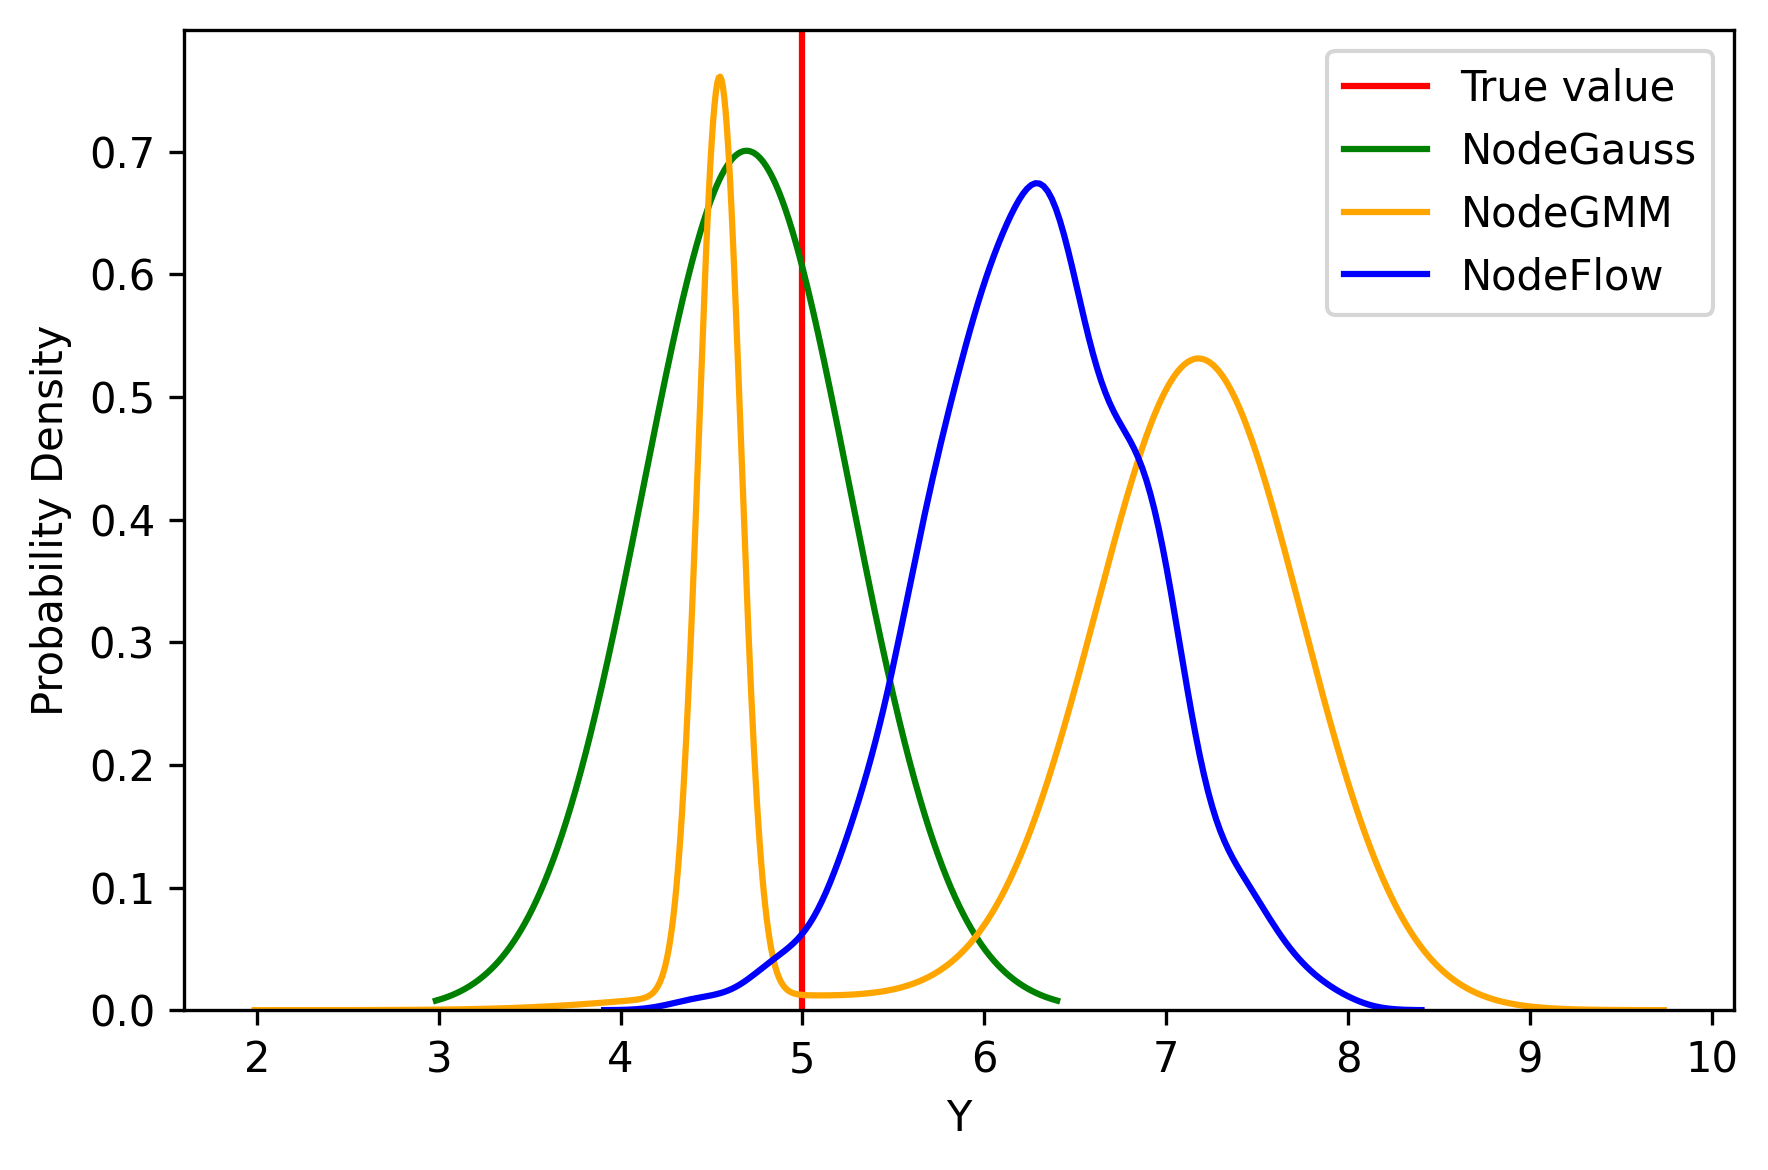

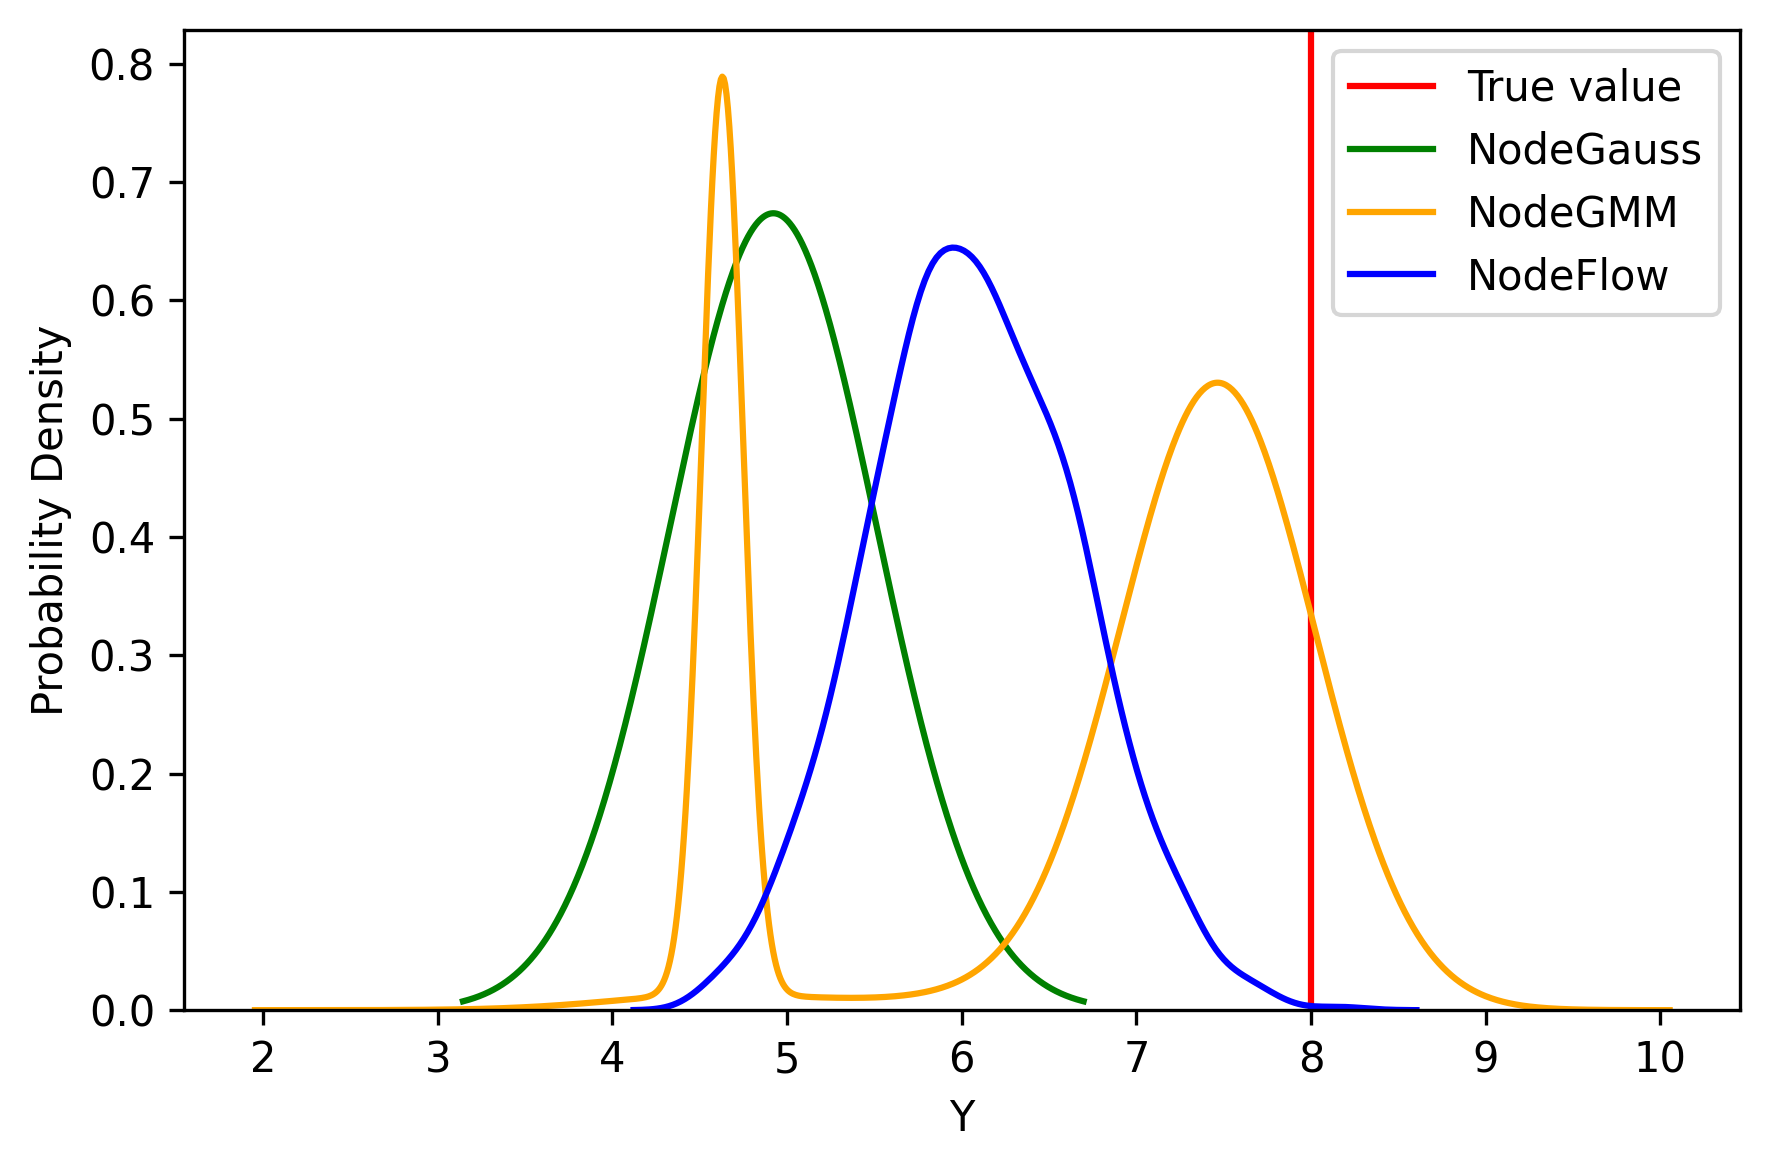

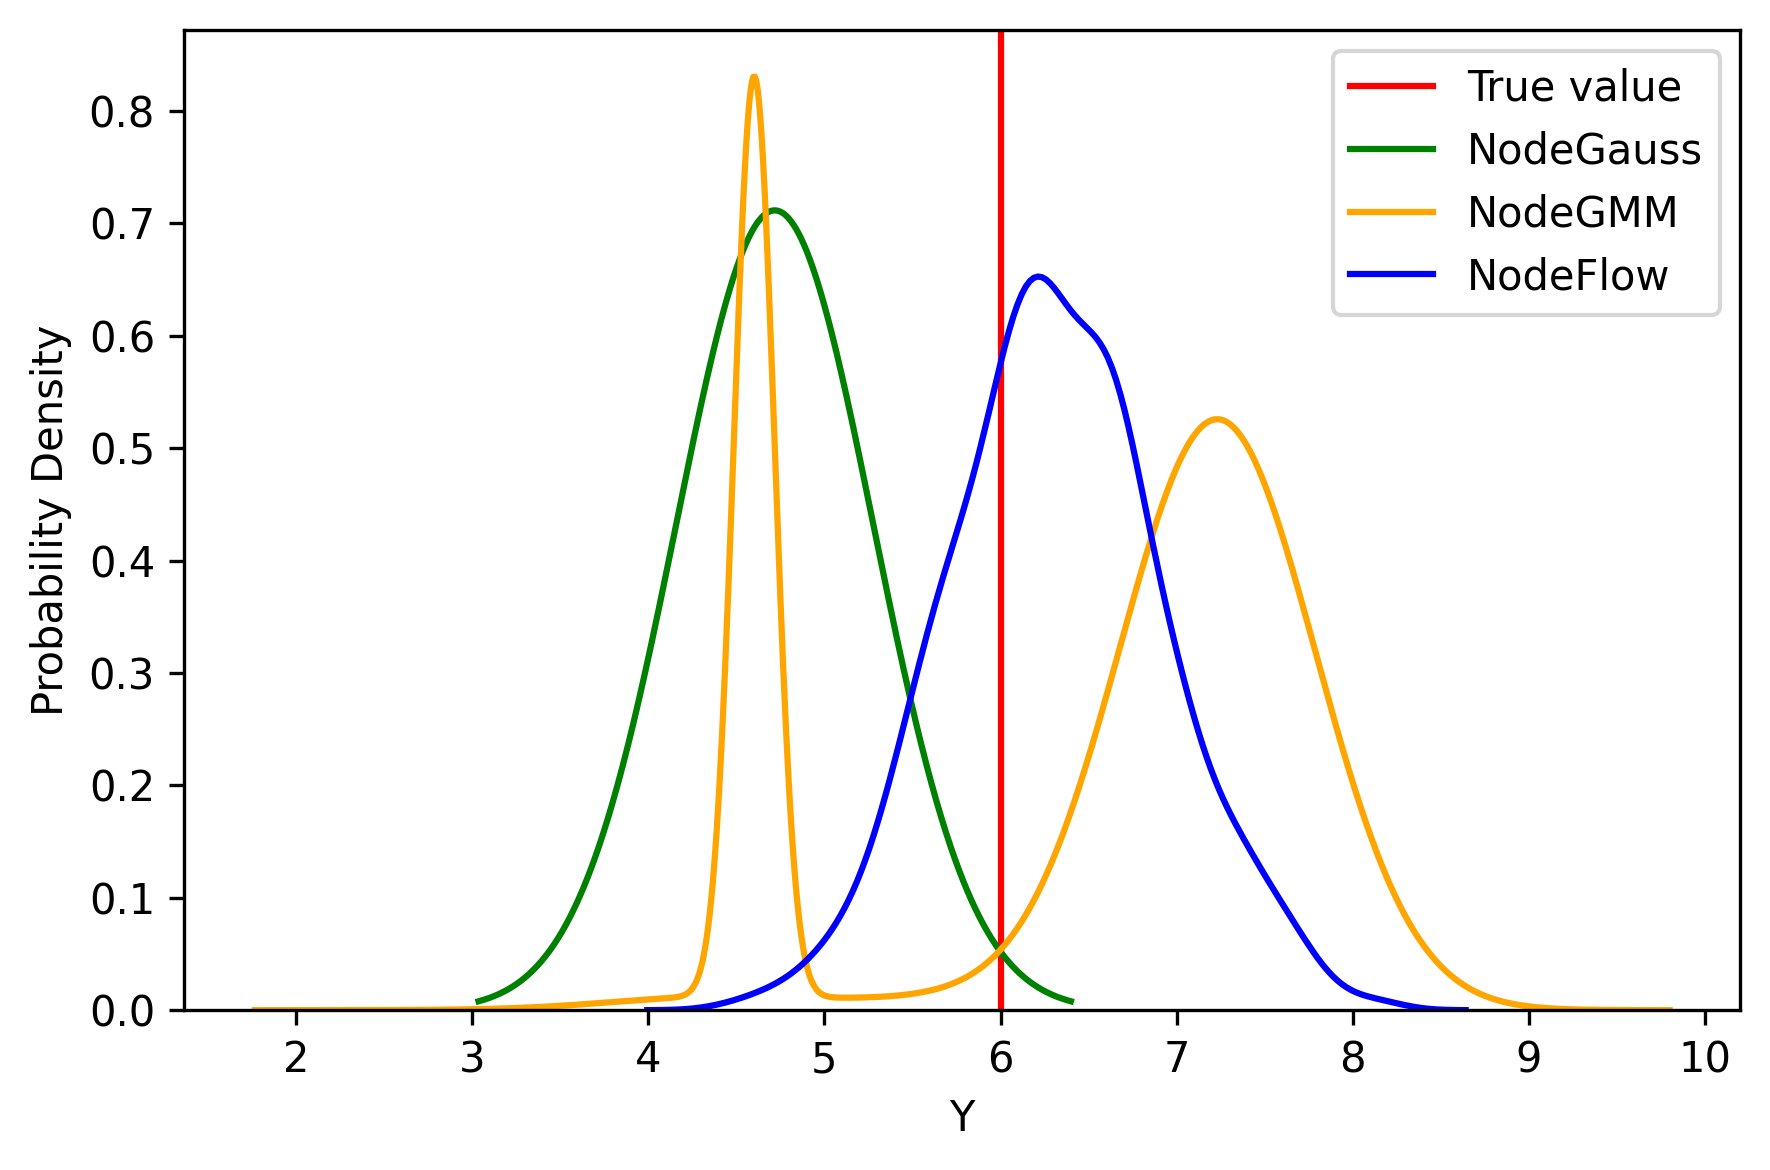

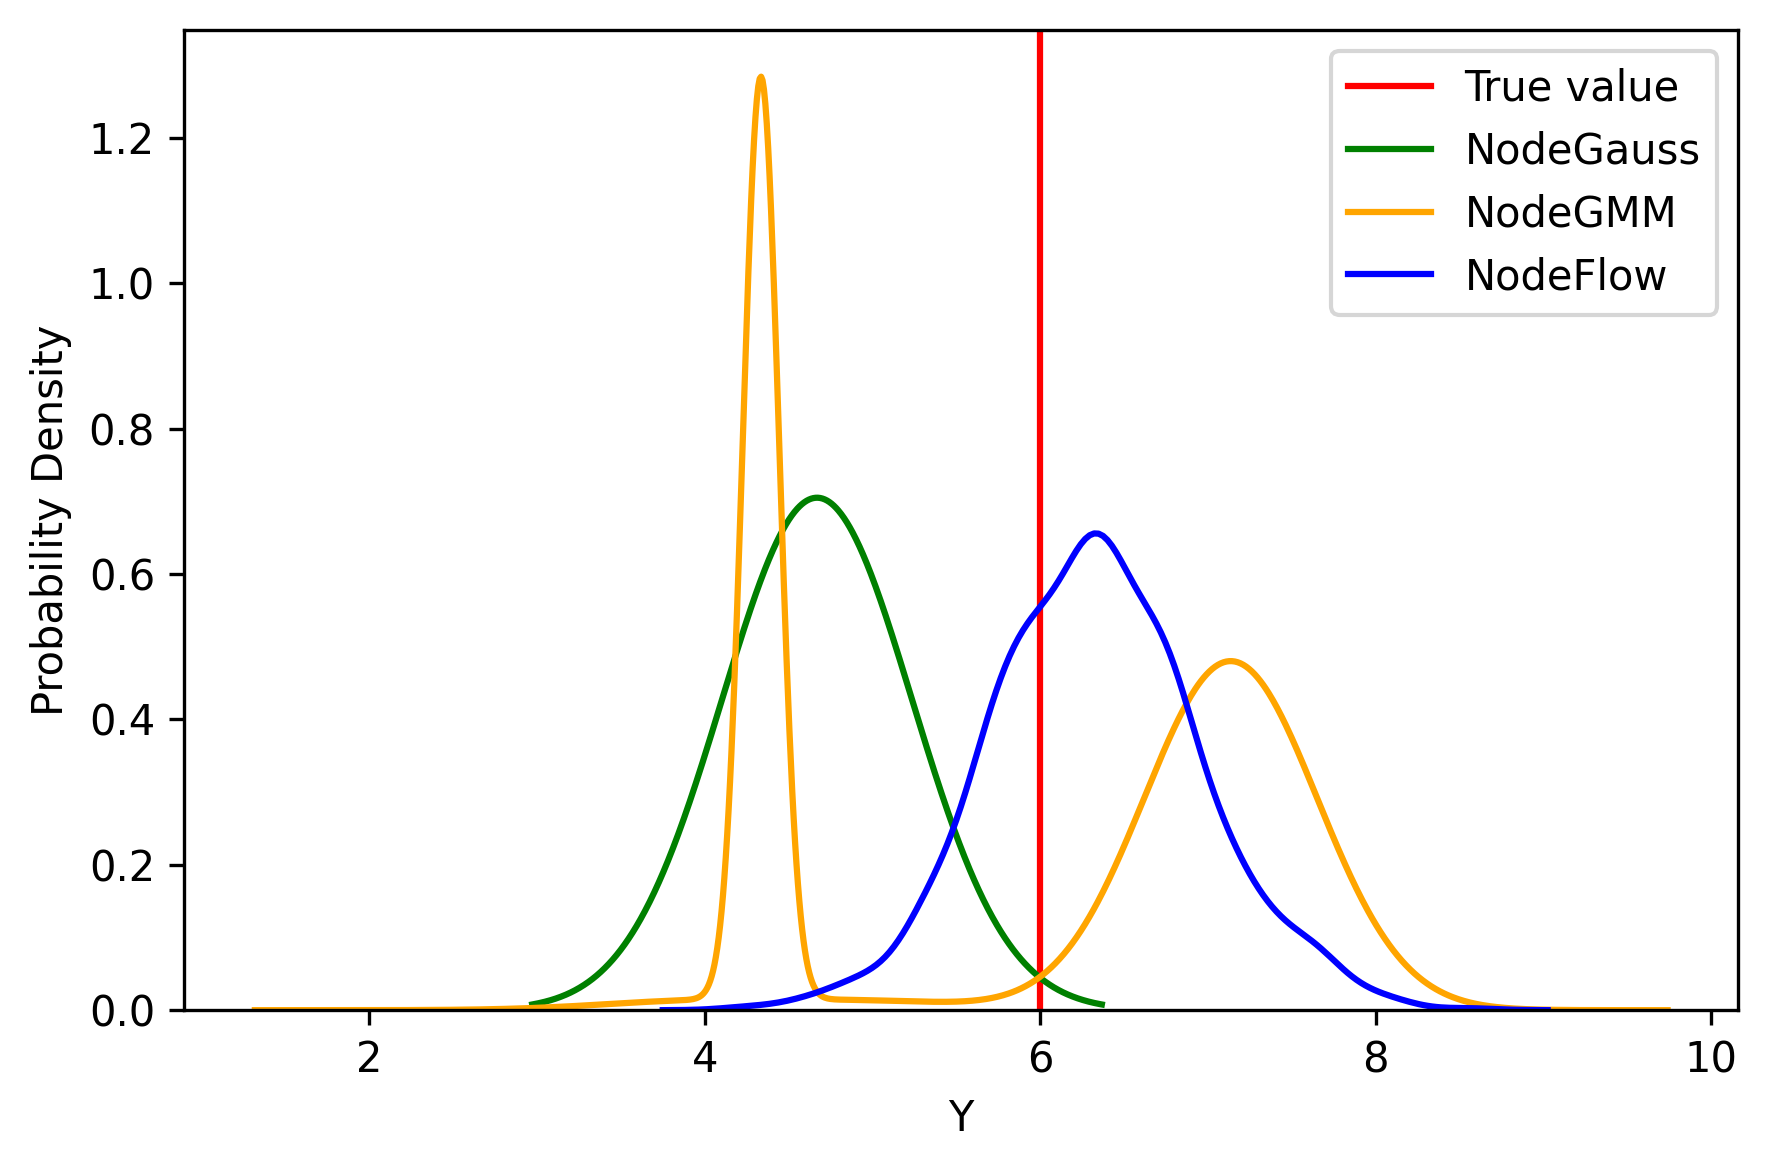

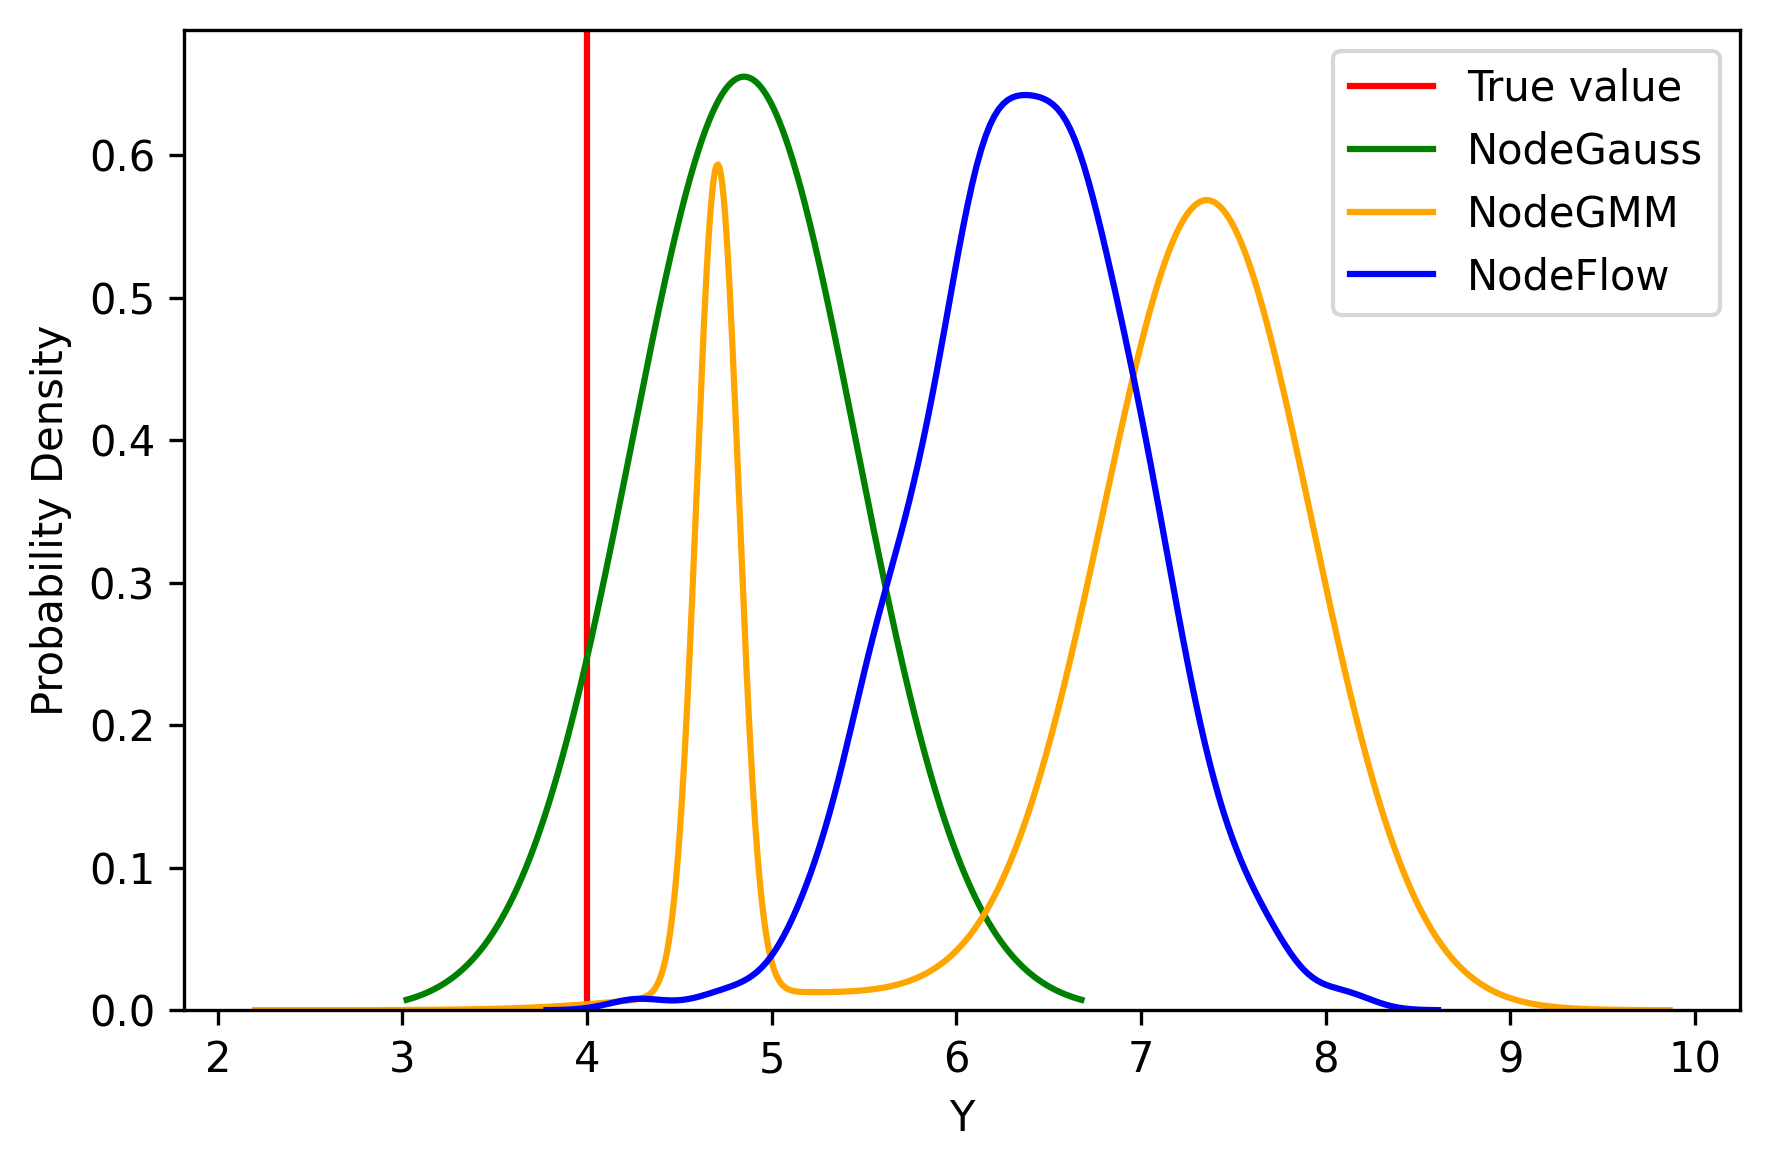

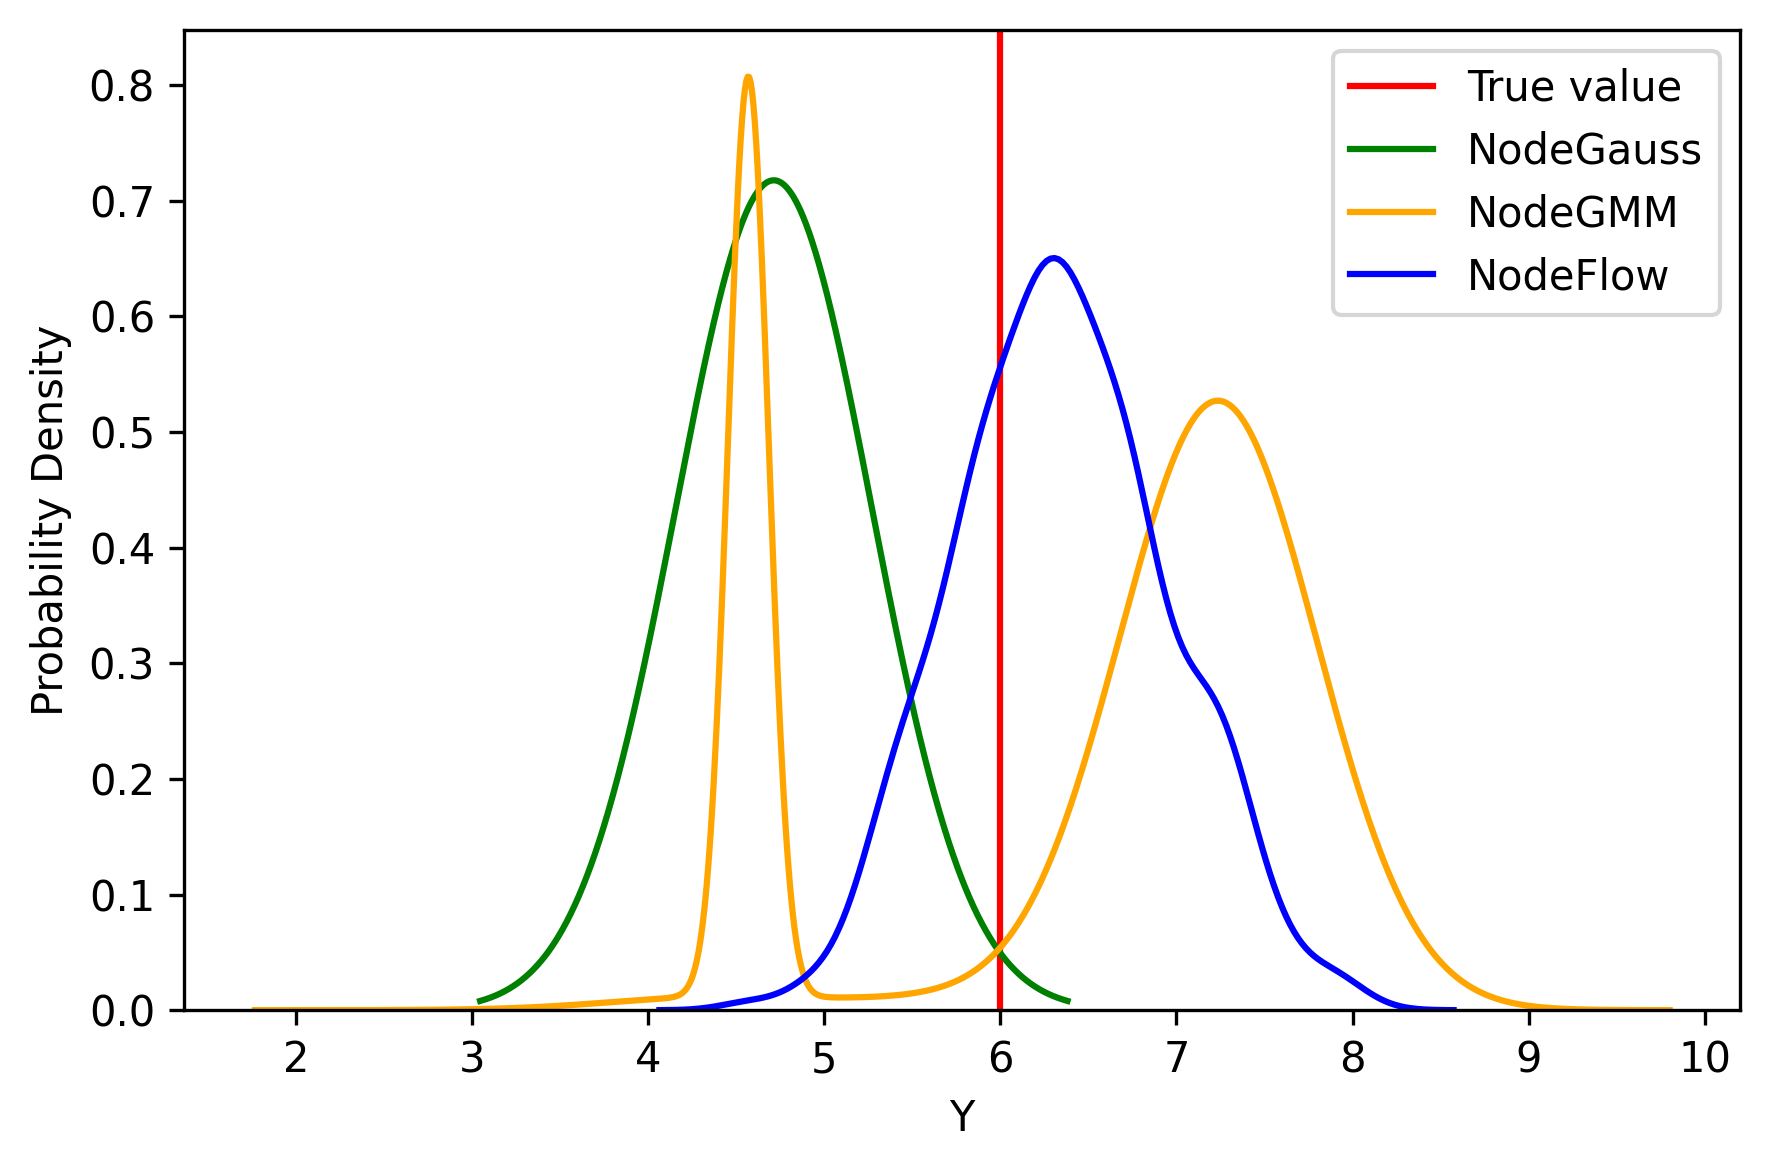

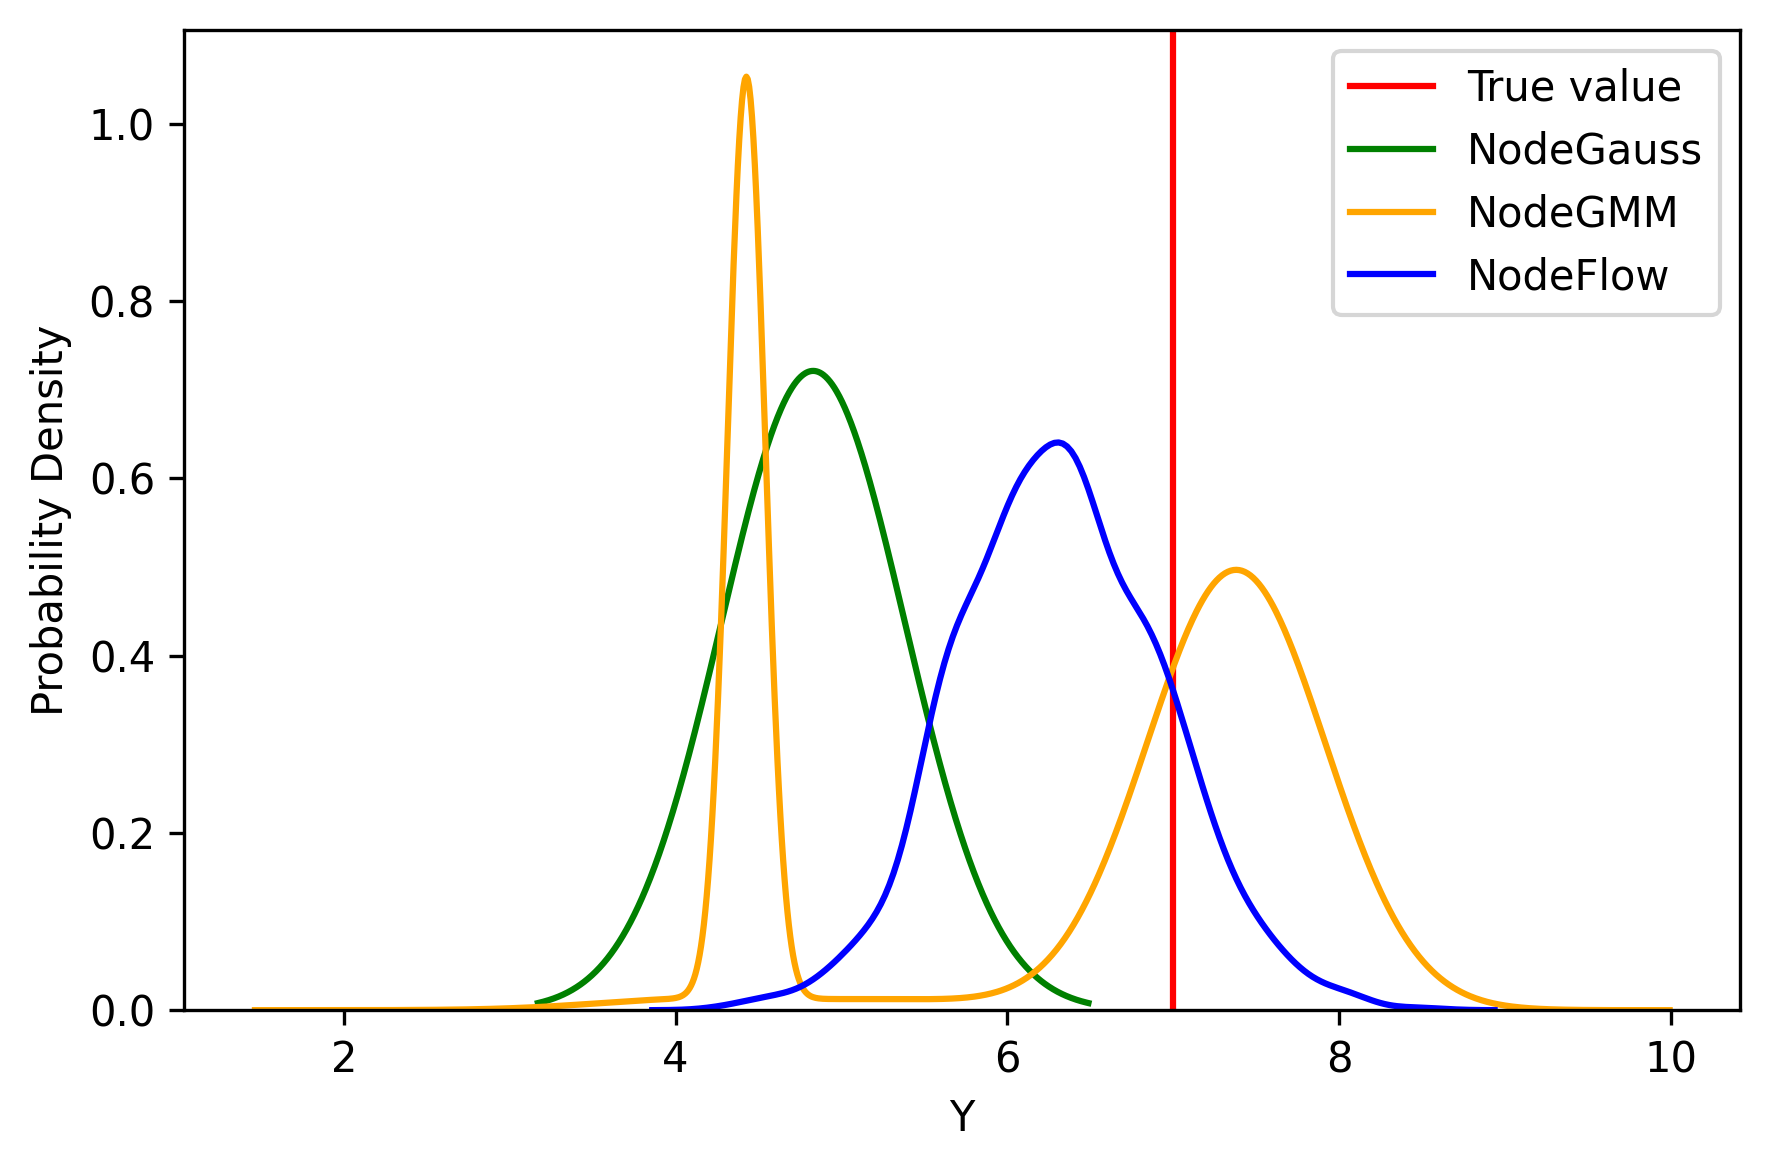

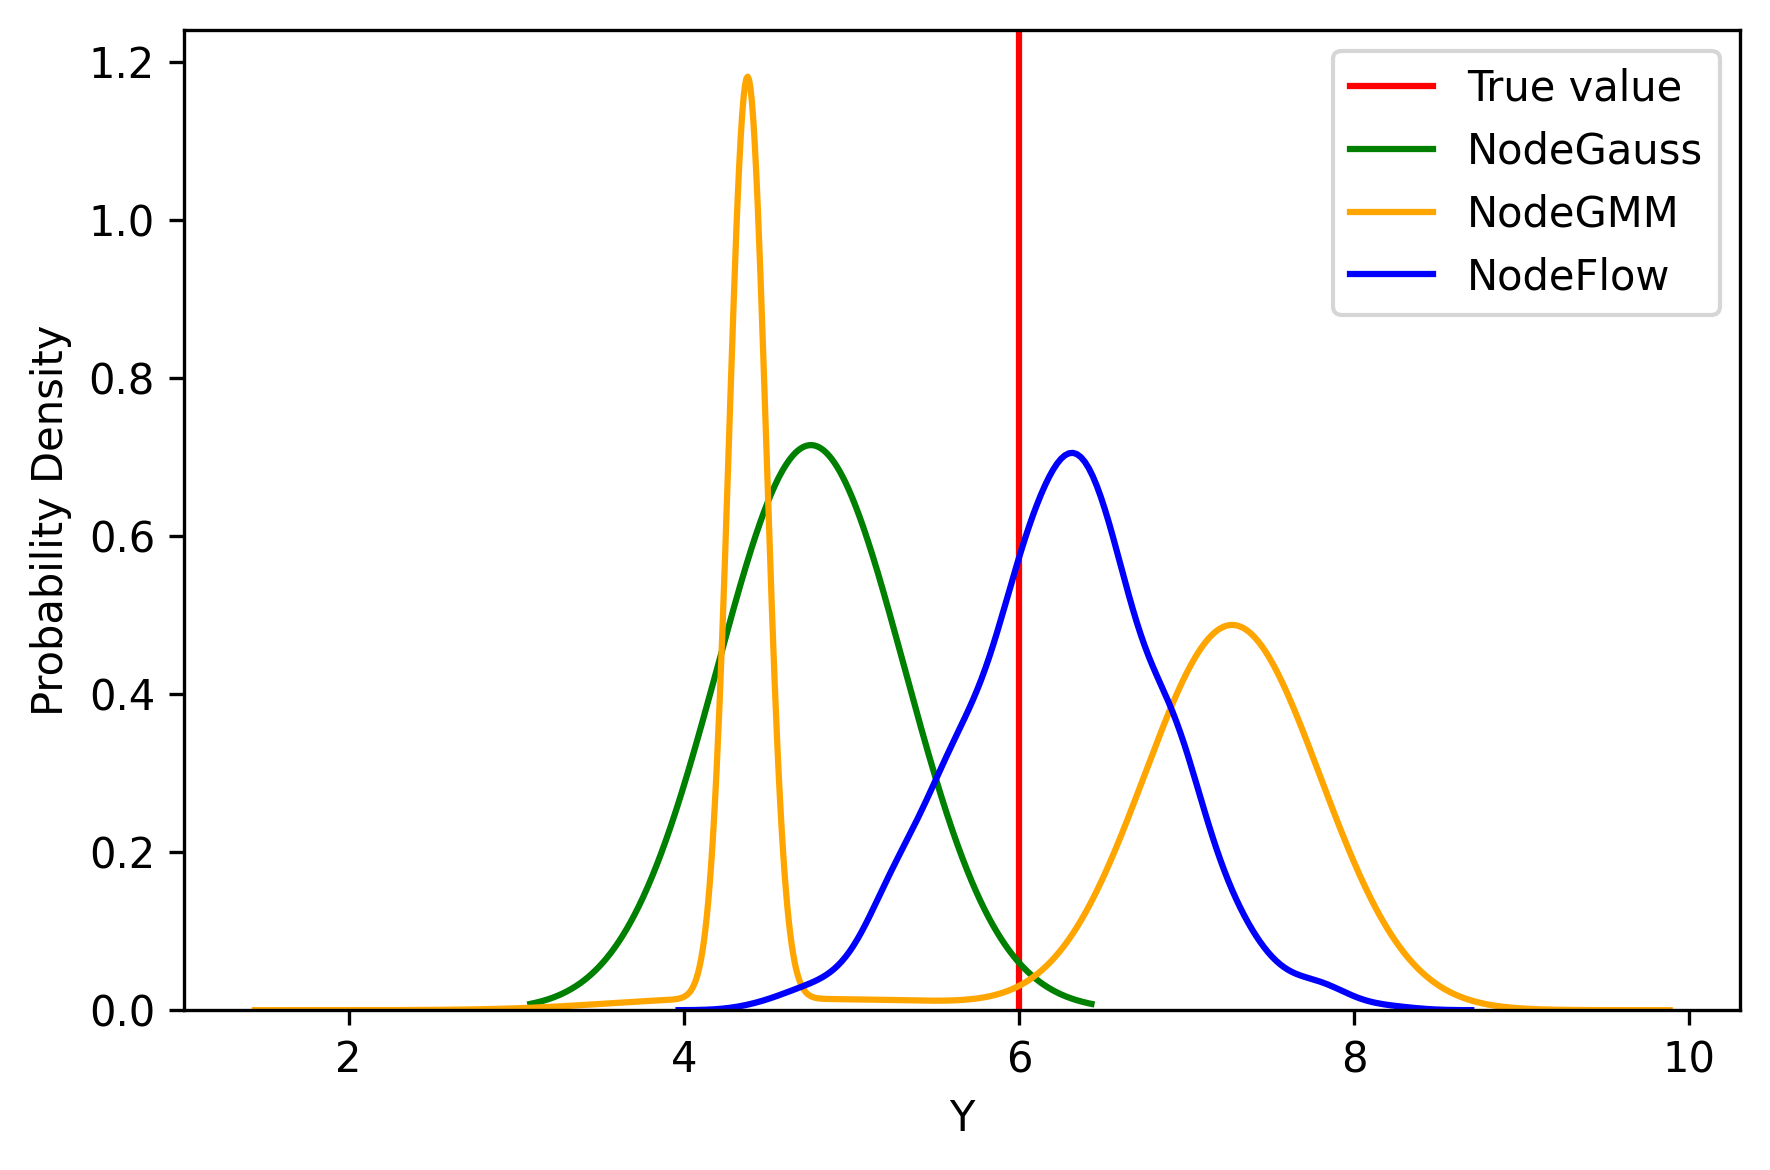

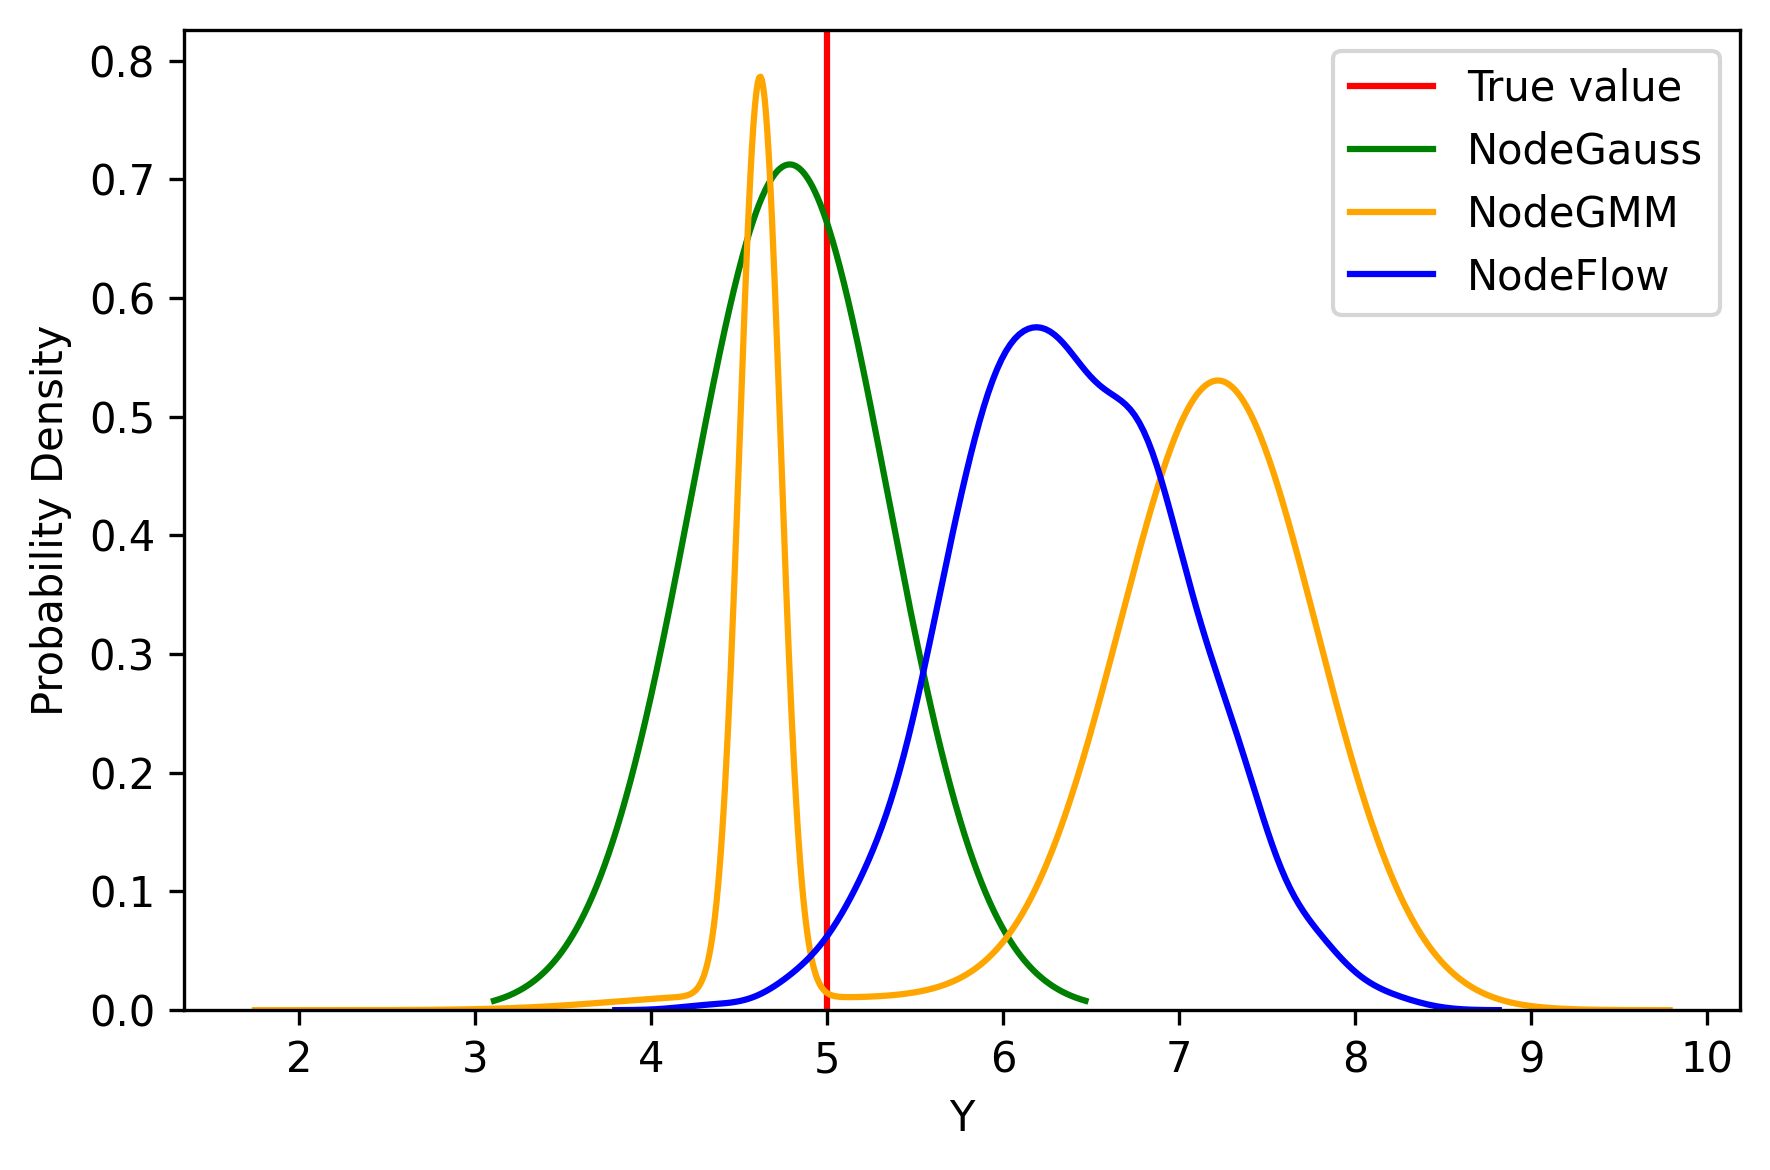

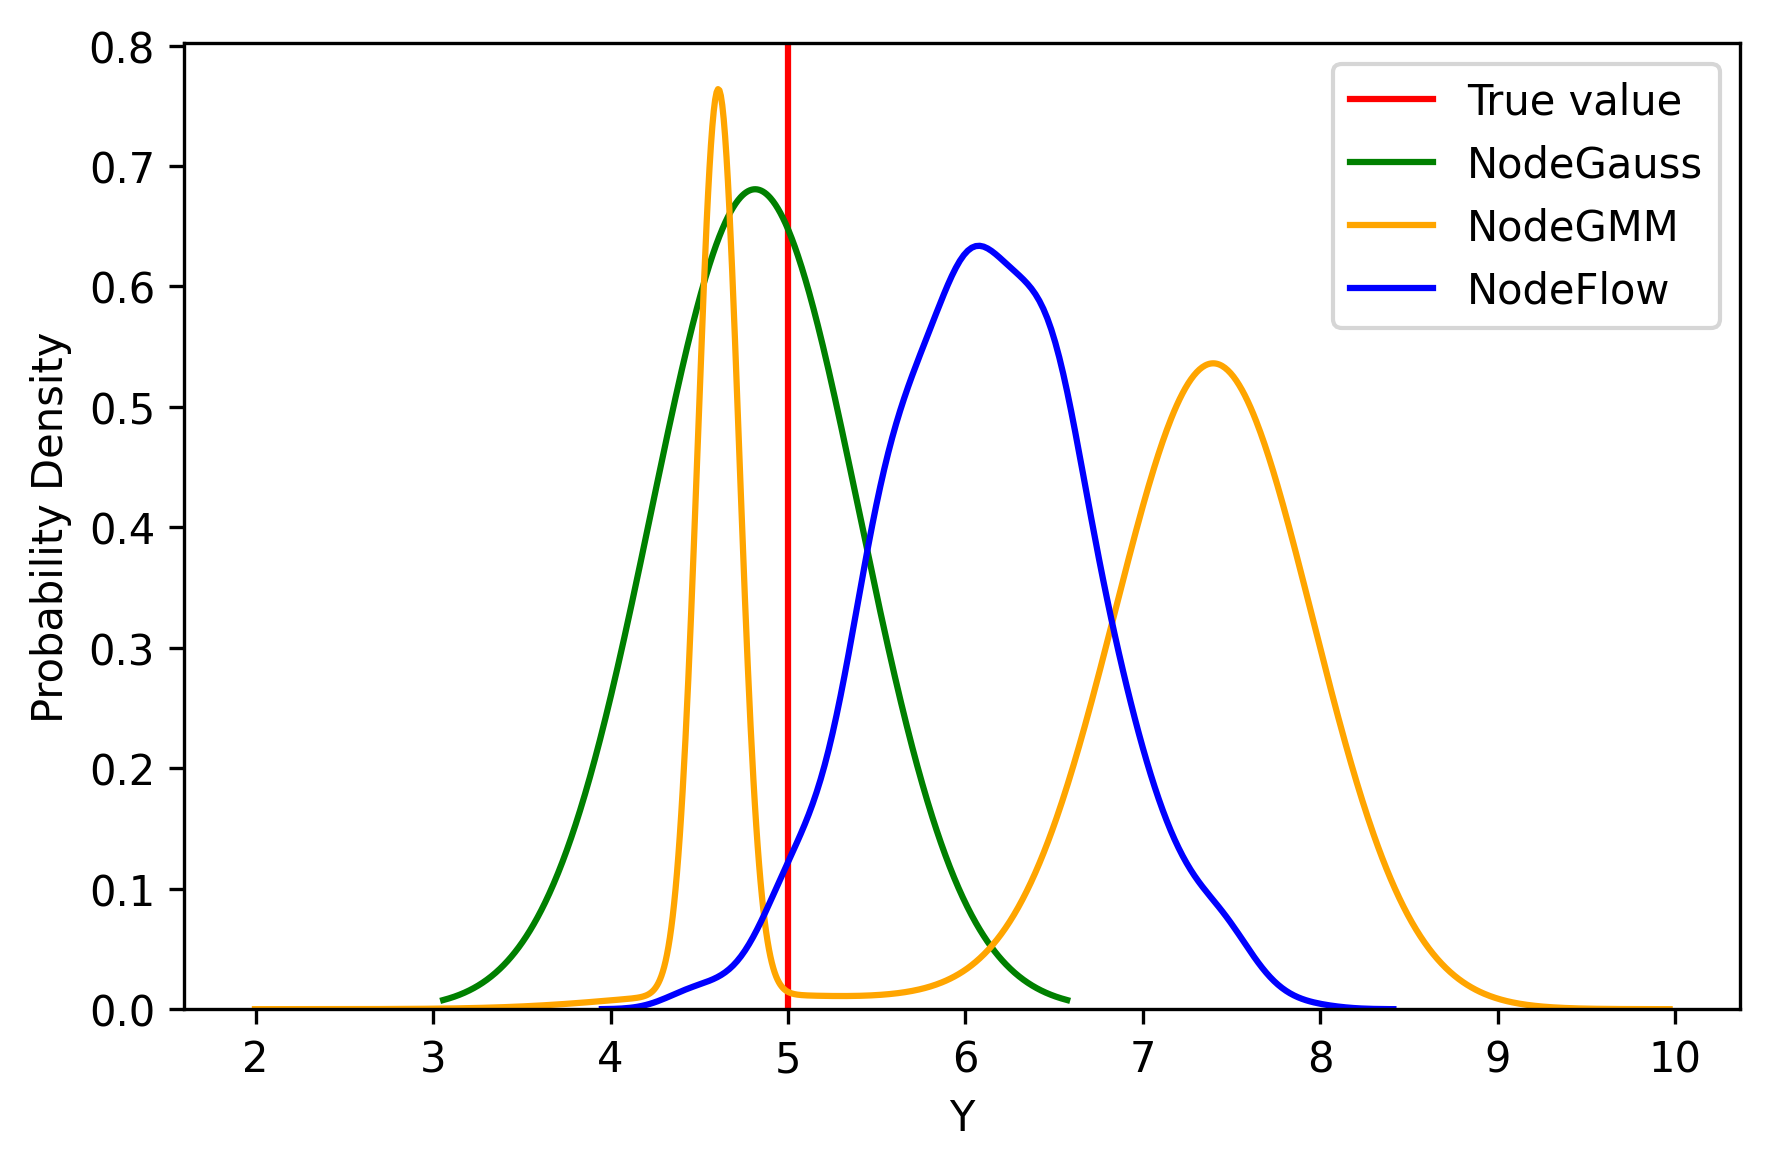

In [4]:
for DATASET in uci_datasets:
    IDX = 0
    
    ## Load data
    x_train = UCIDataSet(
        filepath_data=f"../data/01_raw/UCI/{DATASET}/data.txt",
        filepath_index_columns=f"../data/01_raw/UCI/{DATASET}/index_features.txt",
        filepath_index_rows=f"../data/01_raw/UCI/{DATASET}/index_train_{IDX}.txt"
    ).load()
    y_train = UCIDataSet(
        filepath_data=f"../data/01_raw/UCI/{DATASET}/data.txt",
        filepath_index_columns=f"../data/01_raw/UCI/{DATASET}/index_target.txt",
        filepath_index_rows=f"../data/01_raw/UCI/{DATASET}/index_train_{IDX}.txt"
    ).load()
    x_test = UCIDataSet(
        filepath_data=f"../data/01_raw/UCI/{DATASET}/data.txt",
        filepath_index_columns=f"../data/01_raw/UCI/{DATASET}/index_features.txt",
        filepath_index_rows=f"../data/01_raw/UCI/{DATASET}/index_test_{IDX}.txt"
    ).load()
    y_test = UCIDataSet(
        filepath_data=f"../data/01_raw/UCI/{DATASET}/data.txt",
        filepath_index_columns=f"../data/01_raw/UCI/{DATASET}/index_target.txt",
        filepath_index_rows=f"../data/01_raw/UCI/{DATASET}/index_test_{IDX}.txt"
    ).load()

    x_train_tensor = torch.Tensor(x_train.values)
    x_test_tensor = torch.Tensor(x_test.values)
    y_train_tensor = torch.Tensor(y_train.values)
    y_test_tensor = torch.Tensor(y_test.values)

    datamodule = NodeFlowDataModule(x_train, y_train, x_test, y_test, split_size=0.8, batch_size=2048)
    datamodule.target_scaler.fit(datamodule.y_tr)


    ## Load models
    model_filepath = f"../models/nodegmm_1d/UCI/{DATASET}/model_nodegmm_1d_{IDX}-nodegmm.pt"
    nodegauss = torch.load(model_filepath, map_location="cpu")
    nodegauss.eval()
    
    model_filepath = f"../models/nodegmm/UCI/{DATASET}/model_nodegmm_{IDX}-nodegmm.pt"
    nodegmm = torch.load(model_filepath, map_location="cpu")
    nodegmm.eval()

    model_filepath = f"../models/nodeflow/UCI/{DATASET}/model_{IDX}"
    nodeflow = NodeFlow.load(model_filepath, map_location="cpu")
    nodeflow.eval()

    ## Do things
    for i in range(20):
        print(DATASET, i)
        observation = x_test_tensor[i, :].reshape(1, -1)
        
        nodegauss_x, nodegauss_pdf_values  = generate_kde_plot_gaussian(nodegauss, datamodule, observation, num_samples=1000)
        nodegmm_x, nodegmm_pdf_values = generate_kde_plot_gaussian(nodegmm, datamodule, observation, num_samples=1000)

        nodeflow_samples = generate_samples_nodeflow(nodeflow, datamodule, observation, num_samples=1000)

        plt.figure(figsize=(6, 4))
        plt.axvline(x=y_test_tensor[i].item(), color='r', label='True value')
        plt.plot(nodegauss_x, nodegauss_pdf_values, color = "green", label="NodeGauss")
        plt.plot(nodegmm_x, nodegmm_pdf_values, color = "orange", label="NodeGMM")
        sns.kdeplot(nodeflow_samples, color="blue", label="NodeFlow")
        
        plt.xlabel("Y")
        plt.ylabel("Probability Density")
        plt.legend()

        plt.tight_layout()
        plt.gcf().set_dpi(300)
        plt.savefig(f"../figures/distribution/{DATASET}_{i}.pdf")

    